[<img src="https://www.scenerepresentations.org/assets/logo/logo+text-negative@2x.png" alt="TODO: make logo work better on Colab background" width="212"/>](https://www.scenerepresentations.org)

[`MIT 6.S980, Machine Learning for Inverse Graphics`](https://www.scenerepresentations.org/courses/inverse-graphics/)
# Homework 2: 3D Representations and Differentiable Rendering

### About this notebook
This course publishes its assignments as Jupyter notebooks, hosted on Google Colab. This way, you don't need any local development setup. If you're more comfortable with your local dev environment, feel free to download this notebook instead ("File -> Download -> Download .ipynb") and edit it in your local environment. Else, make sure you're logged into your Google Account and click "File -> Save a copy in Drive". You can then edit your copy of the notebook to complete your assignment. You'll find instructions for submitting your work at the [end of this notebook](#scrollTo=Submission_Instructions).

In this notebook, we will explore different volumetric 3D representations, with a focus on neural fields and locally conditioned neural fields (also referred to as hybrid discrete-continuous representations). We will use them to parameterize occupancy functions, Signed Distance Functions, and appearance.

We will then explore how we may fit them via differentiable rendering, specifically, we will implement our own volume renderer!

### Contributors
- _Prof. Vincent Sitzmann, Scene Representation Group._
- _Prafull Sharma, MIT_
- _Ana Dodik, MIT, Scene Representation Group_
- _Ayush Tewari, MIT_

## Setup

Below some setup we need for running everything on Colab. Feel free to skip this section.

In [1]:
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple, Generator, Dict

# !pip install --upgrade scikit-image
# !pip install --upgrade einops
# !pip install imageio-ffmpeg

In [2]:
# We will need pytorch3d. At the moment (2022-07-23) it's a bit complicated to install in colab:
def install_pytorch_3d_from_prebuilt_wheel_if_needed():
    """
    Attempts to install PyTorch3D – first from FB AI's wheels,
    if that isn't available, fall back to MIT SRG's build.
    """
    need_pytorch3d = False
    try:
        import pytorch3d
        print(f"Pytorch3D was already installed, version: {pytorch3d.__version__}")
    except ModuleNotFoundError:
        print(f"Pytorch3D could not be imported, attempting to install...")
        need_pytorch3d = True
    if not need_pytorch3d:
        return

    # we construct a version string that encodes:
    # Python version, torch's CUDA version, and torch version
    import sys
    import torch
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    print(f"Version string: {version_str}")

    # FB has a magic URL where they offer pre-built wheels
    fbai_wheel_url = f"https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html"

    # We (MIT's SRG) also have our own magic filename and URL as fallback
    srg_filename = f"mit-srg-6s980-colab-wheels-{version_str}.tar.gz"
    srg_wheel_url = f"http://eu.schubert.io/{srg_filename}"

    import requests
    fb_has_wheel = requests.head(fbai_wheel_url).ok
    srg_has_wheel = requests.head(srg_wheel_url).ok

    if fb_has_wheel or srg_has_wheel:
        print("Found a wheel. First, install some pytorch3d dependencies (fvcore, iopath) that aren't included in pre-built wheel:")
        ! pip install --quiet fvcore iopath  # type: ignore

    if fb_has_wheel:
        print("Found FB AI wheel, installing…")
        ! pip install --no-index --no-cache-dir pytorch3d -f {fbai_wheel_url}  # type: ignore
    elif srg_has_wheel:
        print("Found only SRG wheel, installing...")
        ! curl -L {srg_wheel_url} | tar xz  # type: ignore
        ! pip install --no-index --find-links=./wheeldir pytorch3d  # type: ignore
    else:
        raise RuntimeError("Can't find any pre-compiled pytorch3D wheel. :/")
install_pytorch_3d_from_prebuilt_wheel_if_needed()

Pytorch3D was already installed, version: 0.7.4


In [3]:
import torch
print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

Installed Torch version: 1.13.0
cuda:0


In [4]:
torch.rand([100, 128, 128, 4]).shape[1:3]

torch.Size([128, 128])

### Testing your code

For your convenience, we have written a little test function, "check_function", which will serve as a unit-test for _every function that you will be graded on_. This will allow you a simple, shallow check whether your function does something reasonable.

Note that it is **not guaranteed** that you will get full score if all of your functions pass this test - in our grading script, we test your functions much more thoroughly. It is your responsibility to make sure your implementation is correct.

At the same time, we're not trying to give you a hard time, i.e., we won't check your functions with weird inputs or corner cases.

In [5]:
def check_function(test_name, function_name, test_input, test_output):
    try:
        student_output = function_name(*test_input)
    except TypeError as error:
        print("Function", test_name, "has a error and didn't run cleanly. Error:", error)
        return False
    if isinstance(student_output, tuple):
        student_output = list(student_output)
    else:
        student_output = [student_output]

    for i in range(len(test_output)):
        if not torch.allclose(student_output[i], test_output[i], rtol=1e-03):
            print(test_name, ": Your function DOES NOT work.")
            return False
    print(test_name, ": Your function works!")
    return True

def check_losses(test_name, losses_array, loss_threshold):
    average_loss_last5 = np.mean(losses[-5:])
    if average_loss_last5 >= loss_threshold:
        print(test_name, ": Your function isn't optimized well")
        return False
    else:
        print(test_name, ": Your function works!")
    return True

# Part 1: MLPs, Neural Fields & First-order optimization

In this part of the assignment, you will implement some basic neural network layers in Pytorch, and fit a neural network to a 2D grayscale image - our first example of a "neural field"!

In [6]:
from torch import nn
from torch.utils.data import DataLoader, IterableDataset

import numpy as np

# scikit-image lets us do basic image image-processing tasks.
import skimage
import skimage.transform

## 1.0 Brief refresher: Fully Connected NNs / MLPs

Let's write a simple fully connected neural network in pytorch! These networks are composed of linear layers and activation functions.

A linear layer is simply a layer that stores a matrix $\mathbf{W}$ (the "weights") and a vector $\mathbf{b}$ (the "biases"). When called with an input vector, it computes the following function:

$L(x) = \mathbf{W}^T \mathbf{x} + \mathbf{b}$

Note that technically, this is an _affine_ transform, but in Deep Learning speak, folks refer to this as a _linear_ layer.

Let's instantiate a layer that maps a 2-dimensional input vector to a 256-dimensional activation:

In [7]:
lin = torch.nn.Linear(in_features=2, out_features=256, bias=True, device=device)
print(lin)

Linear(in_features=2, out_features=256, bias=True)


One can access the parameters of a layer in pytorch via its member `named_parameters()`, which is an iterator that yields tuples of (parameter_name, parameter_tensor):

In [8]:
def print_params(module):
    for name, param in module.named_parameters():
        print(f"{name}: {tuple(param.shape)}")

print_params(lin)

weight: (256, 2)
bias: (256,)


Given a two-dimensional input vector $\mathbf{x}$ (potentially with a batch dimension!), we can call the linear layer like so:

In [9]:
x = torch.randn((100, 2), device=device)
print(x.shape)
y = lin(x)
print(y.shape)

torch.Size([100, 2])
torch.Size([100, 256])


A simple neural network can be built by "stacking" linear layers and nonlinearities / activation functions using the `nn.Sequential` operator.


In [10]:
mlp = nn.Sequential(nn.Linear(2, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 1)).to(device)
print_params(mlp)

0.weight: (256, 2)
0.bias: (256,)
2.weight: (1, 256)
2.bias: (1,)


For training neural networks, the initialization of parameters is critical. Pytorch's default initialization is not ideal for all tasks. Below, we implemented initialization according to "kaiming-normal" for relu nonlinearities. This is mostly based on empirical experience with these initialization schemes.

You can apply such weight initialization recursively to your MLP by calling `.apply(init_weights_function)`:


The **Kaiming normal** initialization method samples initial weights from a normal distribution 
with zero mean and a standard deviation of sqrt(2/n), where n is the number of input units 
in the weight tensor. This initialization method ensures that the variance of the output of each layer 
is approximately equal to the variance of its input, which helps prevent the vanishing or exploding 
gradients problem that can occur in deep neural networks.

In [11]:
def init_weights_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')

        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

mlp.apply(init_weights_normal)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=1, bias=True)
)

Just as before, we can now call this whole neural network on our vector $x$:

In [11]:
y = mlp(x)
print(y.shape)

torch.Size([100, 1])


## 1.1. Neural Fields: Fitting an MLP to an image

Now, let's "fit" our MLP to a greyscale image!

A greyscale image can be intepreted as a function $f(\mathbf{x})$ that takes a 2D pixel coordinate $x$ to a grayscale value $b$, i.e.:
$$f: \mathbb{R}^2 \to \mathbb{R}^1, \quad \mathbf{x} \mapsto f(\mathbf{x}) = b$$

In physics, such functions that take space-time coordinates as input some value at that space-time coordinate are referred to as __fields__. Following "Neural Fields in Visual Computing and Bey", Xie et al. 2022, we refer to such a field fully or partially parameterized via a neural network as a **Neural Field**. 

We now seek to find the parameters of our MLP $\Phi$ such that it will parameterize exactly this function, and such that sampling $\Phi$ on a grid of pixel coordinates approximately yields the image.

That is we seek the function $\Phi(\mathbf{x})$ such that: $\sum_i \| \Phi(\mathbf{x}_i) - f(\mathbf{x}_i) \|$ is minimized for all pixels $\{(\mathbf{x}, b)_i\}_{i=1}^N$.

We use the function from the last HW to compute normalized pixel coordinates:

In [12]:
def get_norm_pixel_coordinates(
    y_resolution: int,
    x_resolution: int,
    device: torch.device = torch.device('cpu')
    ):
    """For an image with y_resolution and x_resolution, return a tensor of pixel 
    coordinates, with (0,0) the top left corner at (1, 1) the bottom right corner.

    x is the first coordinate (xy_pix[..., 0]) and y is the second one (xy_pix[..., 1]).
    
    Note that the first axis of the array is the y-axis (or "height"), 
    as these are the rows, and the second axis is the x-axis.

    Returns:
        xy_pix: 
    """
    xs = torch.linspace(0, 1, x_resolution, device=device)
    ys = torch.linspace(0, 1, y_resolution, device=device)
    x, y = torch.meshgrid(xs, ys)
    xy_pix = torch.stack((x, y), dim=-1)
    return xy_pix

Next, we will build a dataset that returns a tuple of ```(all_pixel_coords, all_pixel_values)```, where `all_pixel_coords` are the per-pixel normalized coordinates of every pixel and `all_pixel_values` are the corresponding grey-scale values.

We will operate on an image with resolution (128, 128):

In [13]:
image_size = (128, 128)

First, let's get an image from scikit-learn:

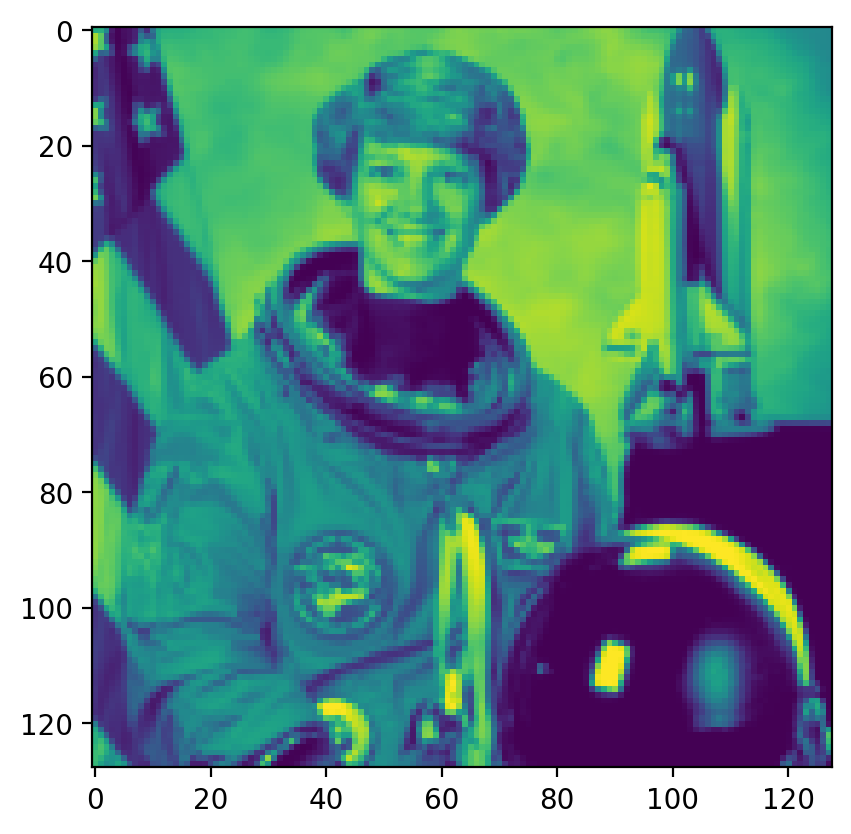

In [14]:
# Load the "Astronaut" image from scikit-image, rescale it,
# and convert it to a grayscale torch.Tensor.
image = skimage.data.astronaut()
image = skimage.transform.resize(
    image, image_size, anti_aliasing=True
)
image = skimage.color.rgb2gray(image)

plt.imshow(image)
plt.show()

image = torch.tensor(image).to(device)

In [15]:
image.shape

torch.Size([128, 128])

To make this into a dataset for a neural field, below:
1. Generate normalized pixel coordinates for every pixel
2. Reshape the image to the shape (height*width, 1)
3. Reshape the pixel coordinates to the shape (height*width, 2)

In [16]:
def get_training_data(image: torch.Tensor):
    """ 
    In this function, you initialize a grid of normalized pixel grid and
    load the target image on device for training of a neural network fitting the
    image given the normalizd pixel grid as input. 
    Please ensure that the points are of shape (B, N, 2) where B is the batch 
    size (fixed as 1 for this example), and N is the number of points (W x H). 
    The image pixels would be on dimension (B, N, 1) as the image is grayscale. 
    Do not forget to set the both x and b on device.

    Returns:
        x: normalized pixel coordinate, generated using shape of image. (B=1, N, 2)
        b: image pixels (B=1, N, 1)

    """
    # TODOb
    H, W = image.shape
    x = get_norm_pixel_coordinates(H, W).unsqueeze(0).reshape(1, -1, 2).to(device) # xy 
    b = image.unsqueeze(0).reshape(1, -1, 1).to(device) # gray scale
    return x, b

check_function("get_training_data", 
               get_training_data,
               [image],
               [get_norm_pixel_coordinates(128, 128).reshape(1, -1, 2).to(device),
                image.reshape(1, -1, 1).to(device)])

get_training_data : Your function works!


True

To use this data in a training loop, we'll wrap it in a generator. Generators must first be instantiated by calling them (like a normal python function). Then, `next()` can be called on the generator handle, see below:

Using **yield** to create a generator can be a more memory-efficient way of iterating over a sequence of values compared to creating a list or other data structure that holds all the values at once. Generators can be used to process large datasets or infinite sequences of data, among other applications.

In [17]:
x, b = get_training_data(image)

def astronaut():
    while True:
        yield x, b

dataset = astronaut()
coords, pixels = next(dataset)
print(coords.shape)
print(pixels.shape)

torch.Size([1, 16384, 2])
torch.Size([1, 16384, 1])


Now, let's define a neural network. Below, use the `nn.Sequential` operator to build an MLP object `mlp` with:
1.   A (linear, ReLU) layer with 2 input dimensions and 256 output dimensions
2.   Two (linear, ReLU) hidden layers with 256 input and 256 output dimensions
3.   An output linear layer with 256 input and 1 ouput dimension (**no** nonlinearity).

Don't forget to copy the MLP to the correct device with .to(device)

In [18]:
# TODO: Define a mlp based on the specifications listed above.
mlp = nn.Sequential(nn.Linear(2, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 256),
                    nn.ReLU(inplace=True), 
                    nn.Linear(256, 1)).to(device)

# TODO: Apply the weight initialization using the init_weights_normal function.
mlp.apply(init_weights_normal)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=1, bias=True)
)

We are now ready to write a function to sample our neural field at the pixel coordinates and plot the output. Below, implement the missing parts:

In [19]:
def sample_plot_img_field(
    field: nn.Module,
    image_size: Tuple[int, int],
    ax = None
    ):
    #########
    # TODO: Get normalized pixel coordinates for image_size and reshape it to 
    #       (1, N, 2) where N = H x W for image size (H, W).
    H, W = image_size
    coords = get_norm_pixel_coordinates(H, W).reshape(-1, 2).unsqueeze(0).to(device)

    # TODO: Infer the field on the coords and store it in a variable named as 
    #       model_out
    with torch.no_grad():
        # Sample "field" with these coordinates
        model_out = field(coords)

    #########

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(model_out.cpu().view(*image_size).detach().numpy())
    return model_out

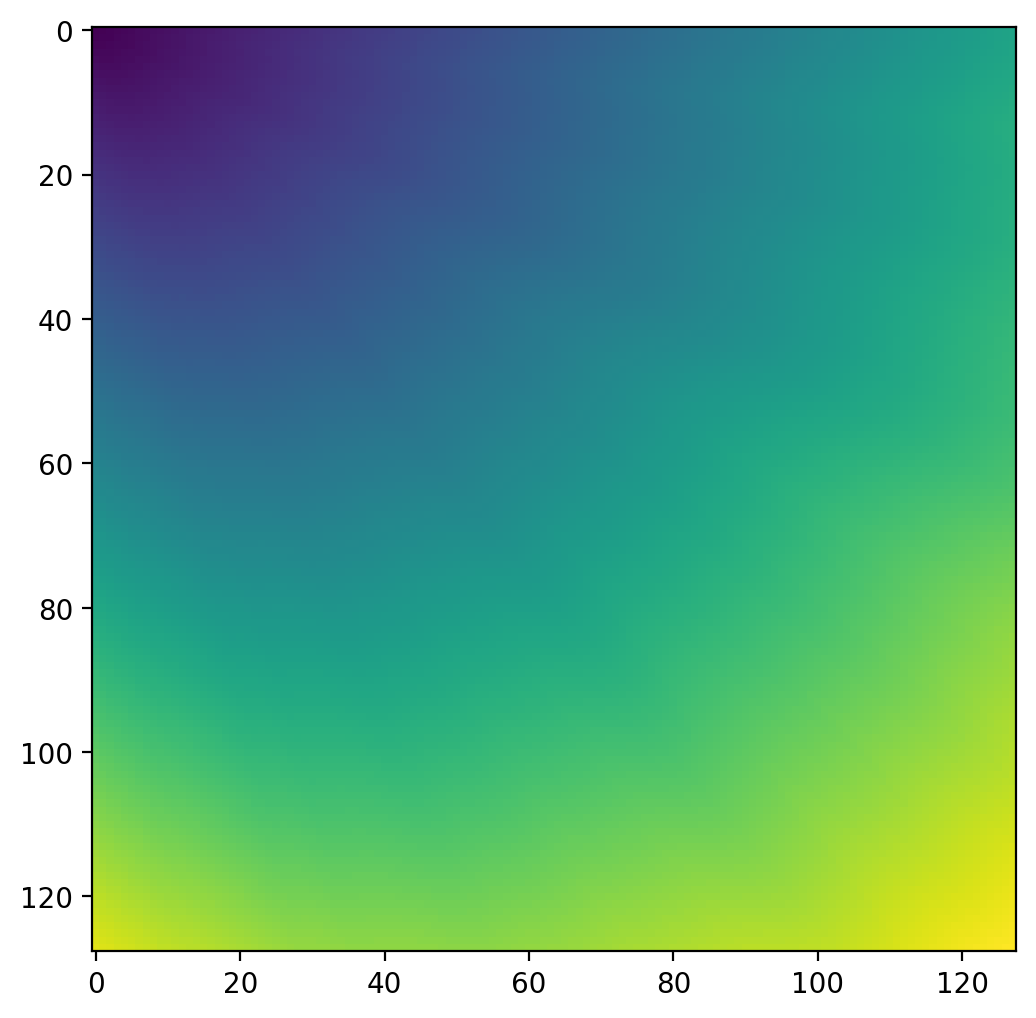

In [20]:
_ = sample_plot_img_field(mlp, (128, 128))

Next, let's implement the loss we will use to compare the output of the MLP to ground-truth. 

Specifically, we will implement a simple mean-squared-error loss. 

In [21]:
def mse_loss(mlp_out, gt):
    return ((mlp_out - gt)**2).mean()

We're now ready to formulate an iterative optimization loop to fit our MLP to the image. Below, complete the parts of the function marked as `TODO`.

In [22]:
def fit_field(
    representation: nn.Module,
    data_iterator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    loss_fn,
    resolution: Tuple,
    sample_plot_field_fn,
    steps_til_summary = 500,
    total_steps=2001,
    lr=1e-3
    ):
    # We will use the "Adam" stochastic gradient descent optimizer,
    # with a learning rate of 1e-3.
    optim = torch.optim.Adam(lr=lr, params=representation.parameters())

    losses = []
    for step in range(total_steps):
        ########################
        # TODO

        # Get the next batch of data and move it to the GPU
        model_input, ground_truth = next(data_iterator)

        # Compute the MLP output for the given input data and compute the loss
        model_output = representation(model_input)

        # Compute the loss using loss_fn between the model_output and the 
        # ground_truth
        loss = mse_loss(model_output, ground_truth)

        ########################

        optim.zero_grad()
        loss.backward()
        optim.step()

        # Accumulate the losses so that we can plot them later
        losses.append(loss.detach().cpu().numpy())   
        

        # Every so often, we want to show what our model has learned.
        # It would be boring otherwise!
        
       
        if not step % steps_til_summary:
            print(f"Step {step}: loss = {float(loss.detach().cpu()):.2f}")
            sample_plot_field_fn(representation, resolution)
            plt.show()

    return losses

In [23]:
# losses = fit_field(mlp, astronaut(), mse_loss,
#                    image_size, sample_plot_img_field)



# # We can also plot the values of our loss function to see how the optimization
# # minimized the loss during training. This is given mostly for demonstration purposes.
# # In practice, we would want to monitor the loss during training.
# fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
# axes[0, 0].plot(np.array(losses))
# plt.show()


# check_losses("Fitting MLP", losses, 0.03)

The "MLP" object is now a continuous representation of the image. That means you can sample it at any resolution! Below, we sample it at a resolution of (256, 256):

In [24]:
# _ = sample_plot_img_field(mlp, (256, 256))

But, **why does it look so bad**? Recall that in this regime of "overfitting" to a single image, the neural network basically serves as a kernel machine. It turns out that the kernel learned by the ReLU neural network couples together 2D points that don't belong together. 

## 1.2. Neural Fields with peaky kernels: SIREN

To alleviate the blurry reconstruction, we will build a neural network with a kernel function that only couples close-by points.

Specifically, we will use a SIREN network, a neural network with periodic activation functions.

There's lots of cool work on this - please find below some more resources if you find this direction intriguing.

Relevant papers:
1.   [Implicit Neural Representations with Periodic Activation Functions (Sitzmann et al.)](https://www.vincentsitzmann.com/siren/)
2.   [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://bmild.github.io/fourfeat/)



In [25]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

Using the pre-defined `SineLayer`, below, use the `nn.Sequential` operator to build a SIREN instance `siren` with:
1.   A SineLayer with 2 input dimensions and 256 output dimensions. **You will have to pass it the "is_first=True" as additional input.**
2.   Two hidden SineLayer with 256 input and 256 output dimensions
3.   An output linear layer with 256 input and 1 ouput dimension (**no** nonlinearity).

Don't forget to copy the siren to the correct device with .to(device)

In [26]:
# TODO: Define siren as MLP with SineLayers with the specifications defined above
siren = nn.Sequential(SineLayer(in_features =2, out_features=256,is_first=True ),
                      SineLayer(in_features =256, out_features=256),
                      SineLayer(in_features =256, out_features=256),
                      nn.Linear(256, 1)).to(device)


print_params(siren)

0.linear.weight: (256, 2)
0.linear.bias: (256,)
1.linear.weight: (256, 256)
1.linear.bias: (256,)
2.linear.weight: (256, 256)
2.linear.bias: (256,)
3.weight: (1, 256)
3.bias: (1,)


Below, call the fit_field function to train the SIREN.

In [27]:
# TODO: Call the fit_field function for siren using the astronaut dataset.
#       Use the MSE loss function and sample_plot_img_field function for plotting.

# losses = fit_field(siren, astronaut(), mse_loss,
#                    image_size, sample_plot_img_field)

# fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
# axes[0, 0].plot(np.array(losses))
# plt.show()

# check_losses("Fitting Siren", losses, 1e-4)

Within only a few hundred iterations, we have now been able to regress the image values! 

However, again, note that there isn't anything particularly "interesting" happening here, from a machine learning perspective. All we have done is to engineer a different kernel function, or, in other words, picking a method by which we choose to interpolate the image pixels. 

## 1.3. Fitting an image to an image

We will illustrate this fact by a somewhat weird experiment: We will fit a *voxelgrid*, i.e., a 2D grid of pixel values, to the image. 

Specifically, we will build a pytorch module that has as its sole parameter a Tensor of shape `(1, 1, height, width)`. The forward pass of that pytorch module takes as input coordinates of shape (batch_size, num_points, 2) (i.e., 2d coordinates) and returns the value of the grid at that coordinate, interpolated via nearest neighbor or bilinear interpolation.

To this, end first read the documentation of grid_sample [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html). 

Below, implement the forward pass of the `PixelGrid` class. 

In [28]:
import torch.nn.functional as F

class PixelGrid(nn.Module):
    def __init__(self, resolution_per_dim, out_dim, mode='bilinear'):
        super().__init__()
        #######
        # Generate an nn.Parameter with shape (1, out_dim, *resolution_per_dim)
        # called self.grid
        self.grid = nn.Parameter(torch.zeros(size=(1, out_dim, *resolution_per_dim)))
        ######

        self.mode = mode
    
    def forward(self, coordinate):
        '''
        coordinate: (batch_size, num_points, 2)
        '''
        ##############
        #TODO 

        # Reshape "coordinate" to be compatible with the "grid" argument in 
        # grid_sample. This can be done by adding a singleton dimension
        # (= a dimension with size 1). Shape must be (batch_size, num_points, 1, 2)
        coord = coordinate.unsqueeze(2)
     
        
        # Sample self.grid with the reshaped coordinates, using the mode stored 
        # in mode
        values =  nn.functional.grid_sample(self.grid, coord, self.mode) # (N,C,H_out,W_out)
 
        # Reshape & permute values to shape (batch_size, num_points, 1)
        B,N,_,_ = values.shape
        values = values.reshape(B, N, -1).permute(0, 2,  1)
    
        ##############
        return values

We can now instantiate our PixelGrid as follows. Note that the only parameter of the module is the grid itself.

In [29]:
grid = PixelGrid((128, 128), 1, mode='nearest').to(device)
print_params(grid)

grid: (1, 1, 128, 128)


Now, `grid` is a differentiable function that maps a 2D coordinate to a float value. Thus, we can "fit" it to the image, just as we did with our neural fields before.

Below, call `fit_field` to fit the grid to the image.

In [30]:
# losses = fit_field(grid, astronaut(), mse_loss, image_size, sample_plot_img_field)
# check_losses("Fitting voxelgrid", losses, 2e-2)

As we can see, we have perfectly "regressed" the image, surprising no-one ;)

But, why are neural fields interesting _at all_? The key reason is, basically, differentiable compression: An MLP can, during optimization, allocate capacity to high-frequency areas in the signal - kind of like an "adaptive resolution" data structure, like a quadtree / octree, but fully differentiable. Further, they also perform reasonable interpolation by themselves, without the need to hand-craft interpolation kernels.

In general, however, it is indeed the case that there is no "magic" here - there's nothing "intelligent" here, the neural field is really best compared to a voxelgrid with some pros and some cons.

These things will become more apparent in the next section.

In [31]:
del siren
del grid
del mlp
# del losses

# Part 2: Representing 3D Geometry: Neural Fields, Voxel Grids, Hybrid Discrete-Continuous Representations

We will now move on from 2D signals, such as images, to 3D signals, namely shapes. 

In particular, we will implement varying data structures to parameterize an _occupancy function_. Occupancy functions are fields of occupancies, i.e., functions that map a 3D coordinate $\mathbf{x}$ to a scalar probability whether or not that 3D coordinate is _occupied_ by 3D geometry.

We will follow the formulation from Occupancy Networks, Mescheder et al., where the occupancy field is implemented as a classifier that predicts a likelihood whether that point is occupied or not:

$$
    \Phi: \mathbb{R}^3 \to \mathbb{R}^2, \quad \Phi(\mathbf{x})=\mathbf{o}
$$

with $\mathbf{o}$ a 2D vector that contains as its first element the likelihood that that coordinate is occupied and as its second element the likelihood that that coordinate is unoccupied.

Following the lecture, the 2D surface is then the levelset $\{\mathbf{x} | \Phi(\mathbf{x}) = [0.5, 0.5]\}$, and can be extracted, for instance, via marching cubes.

Relevant papers:
1. [Occupancy Networks (Mescheder et al.)](https://autonomousvision.github.io/occupancy-networks/)
2. [DeepSDF, Park et al.](https://github.com/facebookresearch/DeepSDF)

First, let's implement a 3D version of our function `get_norm_pixel_coordinates`.

In [32]:
def get_norm_voxel_coordinates(
    resolution_per_axis: Tuple[int, int, int],
    device: torch.device = torch.device('cpu')
    ):
    xyz_res = resolution_per_axis
    i, j, k = torch.meshgrid(torch.linspace(-1, 1, steps=xyz_res[0], device=device), 
                             torch.linspace(-1, 1, steps=xyz_res[1], device=device),
                             torch.linspace(-1, 1, steps=xyz_res[2], device=device))
    
    xyz_vox = torch.stack([i.float(), j.float(), k.float()], dim=-1)
    return xyz_vox


Now, we'll need some ground-truth occupancy function to fit our 3D fields to. We'll keep it simple for now: Below, we have implemented the (analytical) occupancy function of a simple 3D sphere for you. 

In [33]:
def sphere_occupancy(
    x: torch.Tensor
):
    '''Occupancy function of a 3D sphere with radius 0.5.
    Returns (1, 0) if x is occupied and (0, 1) otherwise.
    '''
    occ = (x.norm(dim=-1, keepdim=True) < 0.5).float()
    return torch.cat((occ, 1-occ), dim=-1)

In [34]:
vox_res = 32, 32, 32

Following the image case, we now implement a function that allows us to visualize the current state of our occupancy field. Below, complete the function `sample_plot_occ_field`:
1. Generate a grid of 3D coordinates using ge_norm_voxel_coordinates
2. Sample the occupancy field passed into the function.

In [35]:
def sample_plot_occ_field(
    field,
    voxel_resolution: Tuple[int, int, int],
    ax = None
    ):
    #########
    # TODO
    # Get normalized pixel coordinates for image_size and reshape it to (1, N, 3)
    # where N is V_x, V_y, V_z are the dimensions defined in voxel_resolution.
    coords = get_norm_voxel_coordinates(voxel_resolution).reshape(1, -1, 3)

    # Infer the field on the coords
    with torch.no_grad():
        out = field(coords)

    # Reshape the output as (V_x, V_y, V_z, 2) for V_x, V_y, V_z are the 
    # dimensions of the voxel grid.
    V_x, V_y, V_z = voxel_resolution
    out = out.reshape(V_x, V_y, V_z, 2)
    #########

    # Slice voxelgrid and imshow slices
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    half_res = voxel_resolution[0] // 2
    
    print(out.shape)
    axes[0].imshow(out[:, :, half_res, 0].squeeze().cpu())
    axes[1].imshow(out[half_res, :, :, 0].squeeze().cpu())
    axes[2].imshow(out[:, half_res, :, 0].squeeze().cpu())
    plt.show()

    del out
    del coords

Let's try it out on our ground-truth occupancy field:

torch.Size([32, 32, 32, 2])


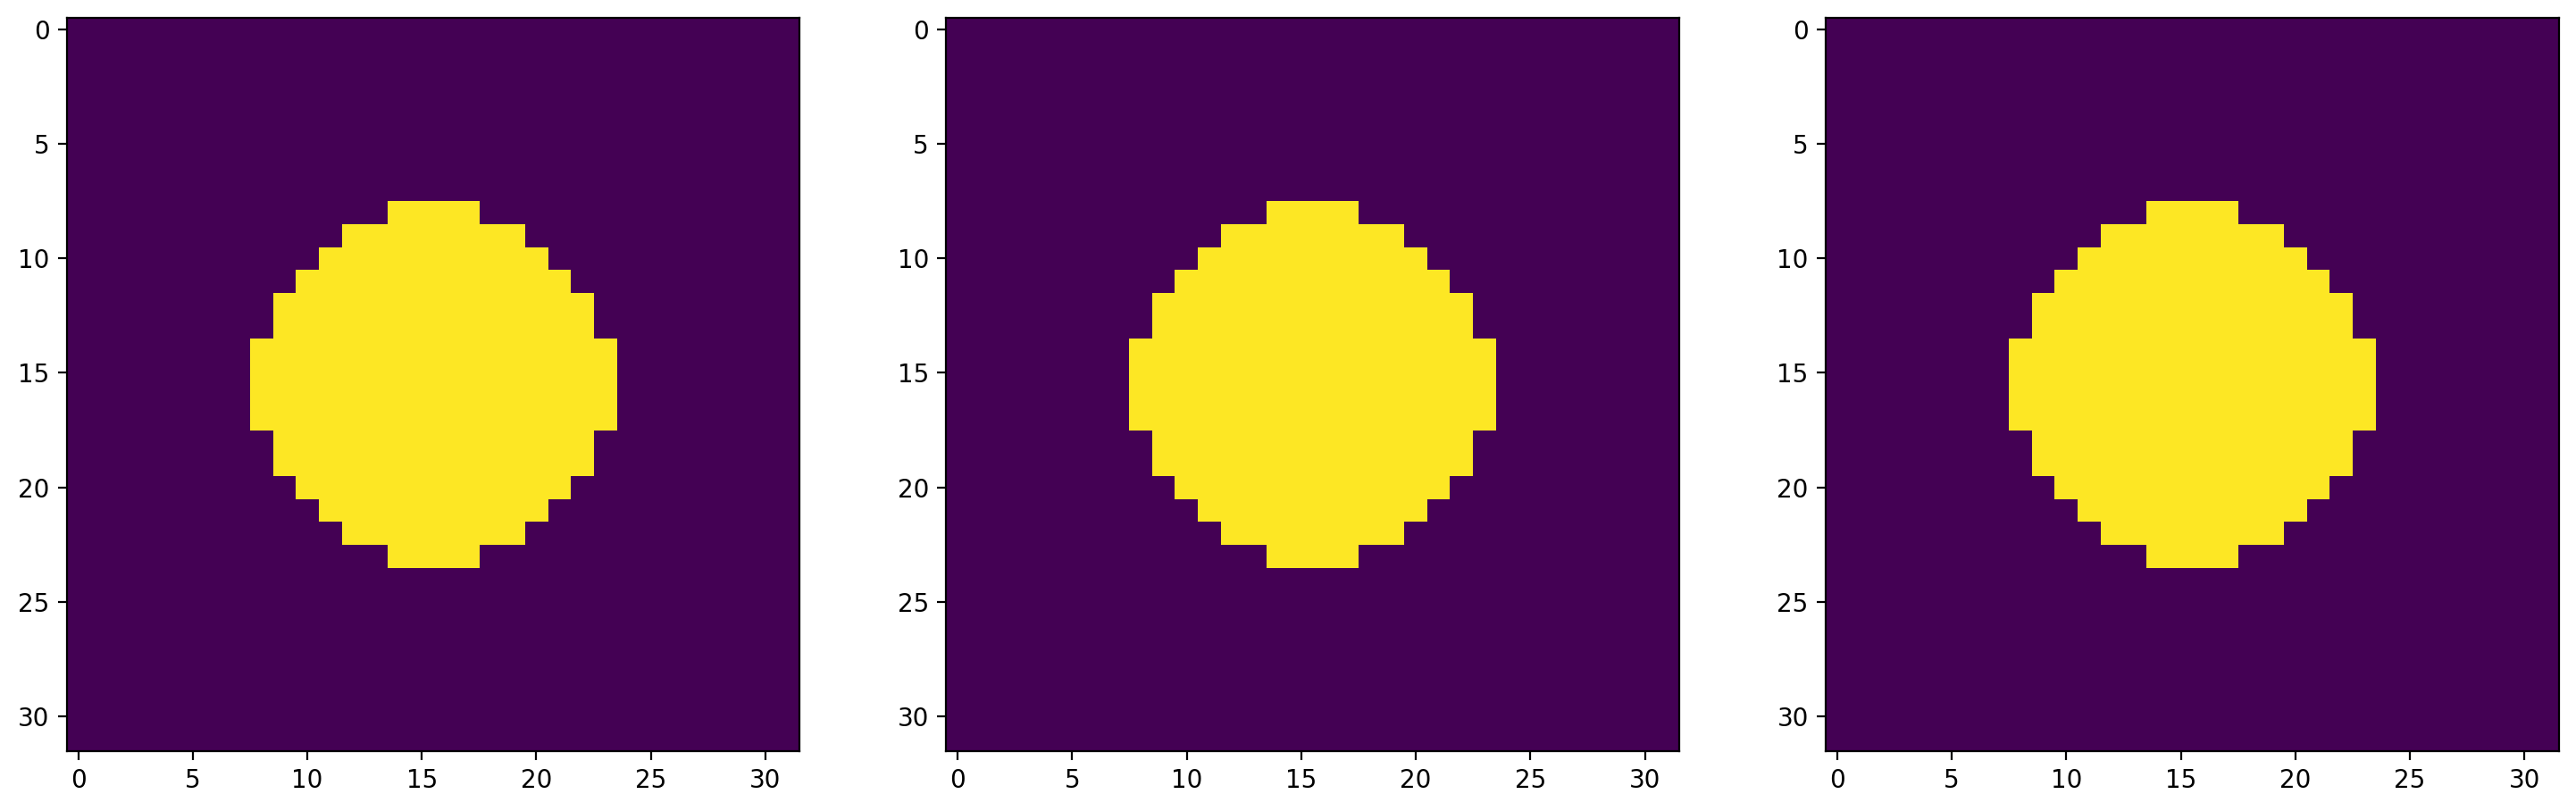

In [36]:
sample_plot_occ_field(sphere_occupancy, (32, 32, 32))

Great! It remains to implement a little dataset that will allow us to fit this occupancy function in a training loop. We did that for you:

In [37]:
def sphere_generator(num_points):
    while True:
        coords = torch.rand(size=(1, num_points, 3))
        coords = ((coords - 0.5) * 2 )
        
        yield coords, sphere_occupancy(coords)

As a sanity check, let's sample a few batches from the dataset, and plot only those coordinates where our sphere_generator returns 1 (occupied). 

Below, find the plot_pointcloud function from the previous homework.

In [38]:
def plot_pointcloud(
    vertices, 
    alpha=.5, 
    title=None, 
    max_points=10_000, 
    xlim=(-1, 1), 
    ylim=(-1, 1),
    zlim=(-1, 1)
    ):
    """Plot a pointcloud tensor of shape (N, coordinates)
    """
    vertices = vertices.cpu()

    assert len(vertices.shape) == 2
    N, dim = vertices.shape
    assert dim==2 or dim==3

    if N > max_points:
        vertices = np.random.default_rng().choice(vertices, max_points, replace=False)
    fig = plt.figure(figsize=(6,6))
    if dim == 2:
        ax = fig.add_subplot(111)
    elif dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zlabel("z")
        ax.set_zlim(zlim)
        ax.view_init(elev=120., azim=270)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.scatter(*vertices.T, alpha=alpha, marker=',', lw=.5, s=1, color='black')
    plt.show(fig)

Now, we'll randomly sample a bunch of batches from the generator and concatenate them into a single tensor, then plot the resulting pointcloud to see if it's correct.

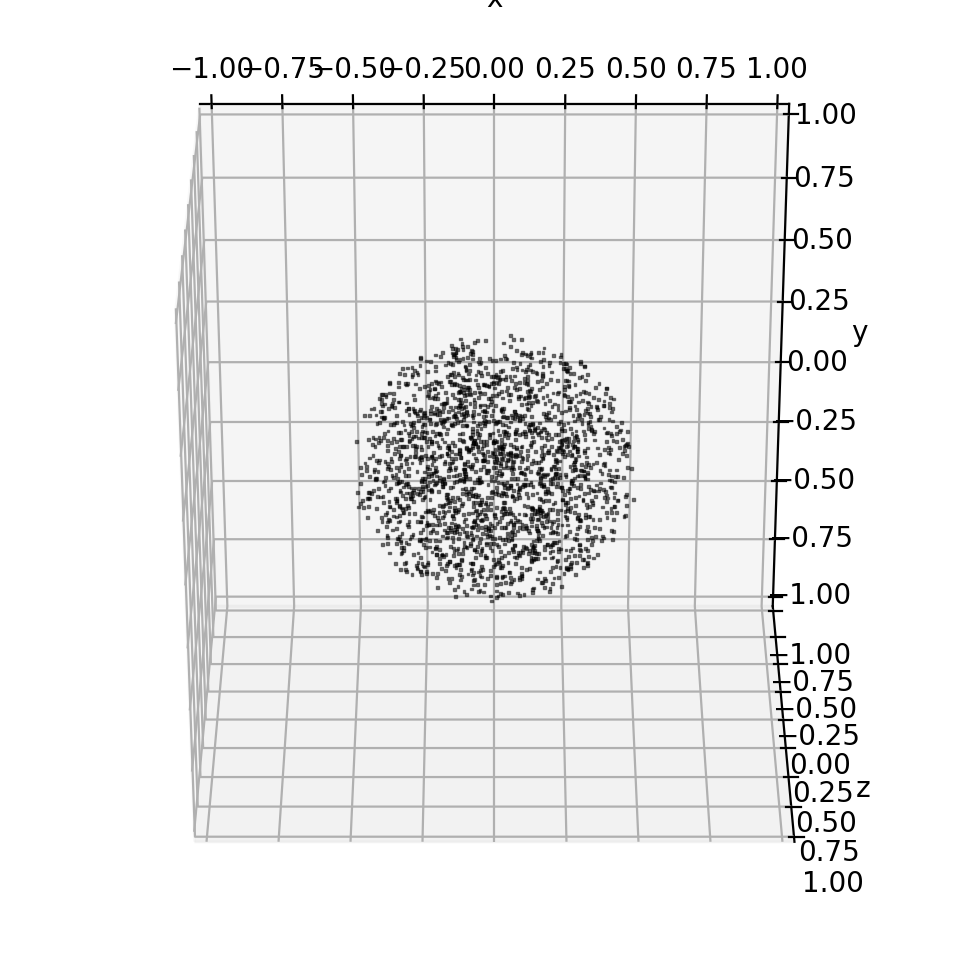

In [39]:
dataset = sphere_generator(32**3)

c, o = next(dataset)
c = c[o[..., 0]!=0]

plot_pointcloud(c.cpu())

Neat. Let's try to fit it with a variety of neural and non-neural representations.

The occupancy function of a sphere is not particularly interesting. Next, we'll genreate the occupancy function of a ShapeNet object that we have stored as a voxelgrid:

## 2.1 Occupancy Networks with ReLU

We'll first use a ReLU neural network to fit this occupancy function. 

Now, let's define a neural network. Below, use the nn.Sequential operator to build an MLP object mlp_3d with:

1.   A (linear, ReLU) layer with 3 input dimensions and 256 output dimensions
2.   Two (linear, ReLU) hidden layer with 256 input and 256 output dimensions
3.   An output linear layer with 256 input and 2 ouput dimension.

In [40]:
# TODO: Define a MLP using the specification above. Don't forget to put the 
#       model on the device. 
mlp_3d = nn.Sequential(nn.Linear(3, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 2))

# TODO: Apply the init_weights_normal initialization to mlp_3d
mlp_3d.apply(init_weights_normal)

Sequential(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=2, bias=True)
)

Next, we will implement the loss. We will pick the loss as proposed in the paper "Occupancy Networks", namely, a binary cross-entropy loss.

In [41]:
def occ_loss(mlp_out, gt):
    return F.binary_cross_entropy_with_logits(mlp_out, gt)

We will now fit this MLP to the occupancy function.

Instead of implementing it from scratch, we were smart in making our training loop very modular, by accepting the field, the dataset, the loss, and the plotting function as parameters! 

This means we can just use the `fit_field` function that we wrote previously, without any changes :)

In [42]:

# TODO: Call the fit field function on mlp_3d on dataset with occ_loss.
#       Train for 2_001 steps with learning rate of 1e-4.
# losses = fit_field(mlp_3d, dataset, occ_loss,
#                 (32, 32, 32), sample_plot_occ_field)

# check_losses("Fitting 3D MLP:", losses, 1e-2)


This worked quite well! 

However, as discussed in the lecture, this monolithic neural field parameterization has a big disadvantage: it's very expensive. Every coordinate requires a separate forward pass through the entire neural network!

As in Part 1, we could use a voxelgrid instead - but the memory gets _really_ expensive for reasonable resolutions (it grows cubically with the sidelength!). 

What gives?

In [43]:
#del mlp_3d
#del losses

## 2.2. Hybrid discrete-continuous 3D representation: voxel-neural-field

We will strike a different memory-to-compute trade-off by exploring hybrid discrete/continuous representations. We will begin with a voxelgrid - neural field - hybrid.

The key idea here is to use a discrete data structure, such as a voxelgrid, as a localized storage of feature vectors.

When we then want to sample a 3D coordinate, we first query into the discrete scene representation - in this case, a voxelgrid - obtaining a feature vector.

This feature vector is then decoded via a _small_ fully-connected neural network. 

It is critical that we use trilinear or higher-order interpolation when querying the voxelgrid - otherwise, information is lost, and the MLP cannot increase the effective resolution.

Relevant papers:
1. [Convolutional Occupancy Networks (Peng et al.)](https://pengsongyou.github.io/conv_onet)
2. [Neural Sparse Voxel Fields, Liu et al.](http://vcai.mpi-inf.mpg.de/projects/NSVF/index.htm#:~:text=In%20this%20work%2C%20we%20introduce,local%20properties%20in%20each%20cell.)

Below, complete the implementation of the `HybridVoxelNeuralField` Module.

In [44]:
class HybridVoxelNeuralField(nn.Module):
    def __init__(self, resolution_per_dim, feature_dim, out_dim, mode='bilinear'):
        super().__init__()
        self.mode = mode
        #########
        # TODO:
        # Generate an nn.Parameter that stores a tensor of shape 
        # (1, feature_dim, resolution_per_dim[0], resolution_per_dim[1], resolution_per_dim[2])
        tensor_shape = (1, feature_dim, *resolution_per_dim)
        self.grid = nn.Parameter(torch.rand(*tensor_shape))

        # TODO: Use nn.Sequential to generate an mlp with 3 hidden layers:
        # (1) (linear, relu) with feature_dim inputs and feature_dim outputs
        # (2) (linear, relu) with feature_dim inputs and feature_dim outputs
        # (3) (linear, relu) with feature_dim inputs and feature_dim outputs
        # (4) (linear) with feature_dim inputs and out_dim outputs
        self.mlp = nn.Sequential(nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(feature_dim, out_dim))

        # TODO: Apply init_weights_normal to the mlp
        self.mlp.apply(init_weights_normal)
        #########
    
    
    
    def forward(self, coordinate):
        #########
        # TODO: Use grid sample to sample features from the self.grid for the 
        #       input coordinates. Please check with the required dimensions 
        #       when using the grid_sample function.
        
        coord = coordinate.to(device)

        if len(coord.shape) == 3:
            coord = coord.unsqueeze(0).unsqueeze(0).to(device)
        
#         elif len(coords.shape) < 5:
#             coord = coord.unsqueeze(0)
        
        # (_, batch_size, channels, height_new, width_new)
        values = nn.functional.grid_sample(self.grid, coord, self.mode) #### YOUR CODE HERE #### 
        
        # Permute the features from the grid_sample such that the feature 
        # dimension is the innermost dimension.

        values = values.permute(0, 2, 3, 4, 1)
        
        # Evaluate the mlp on the input features.
        
        values = self.mlp(values).squeeze(0).cpu()
       
        
        
        #########
        
        return values

In [45]:
hybrid = HybridVoxelNeuralField((16, 16, 16), 8, out_dim=2).to(device)

/home/alsaedyy/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Step 0: loss = 0.29
torch.Size([64, 64, 64, 2])


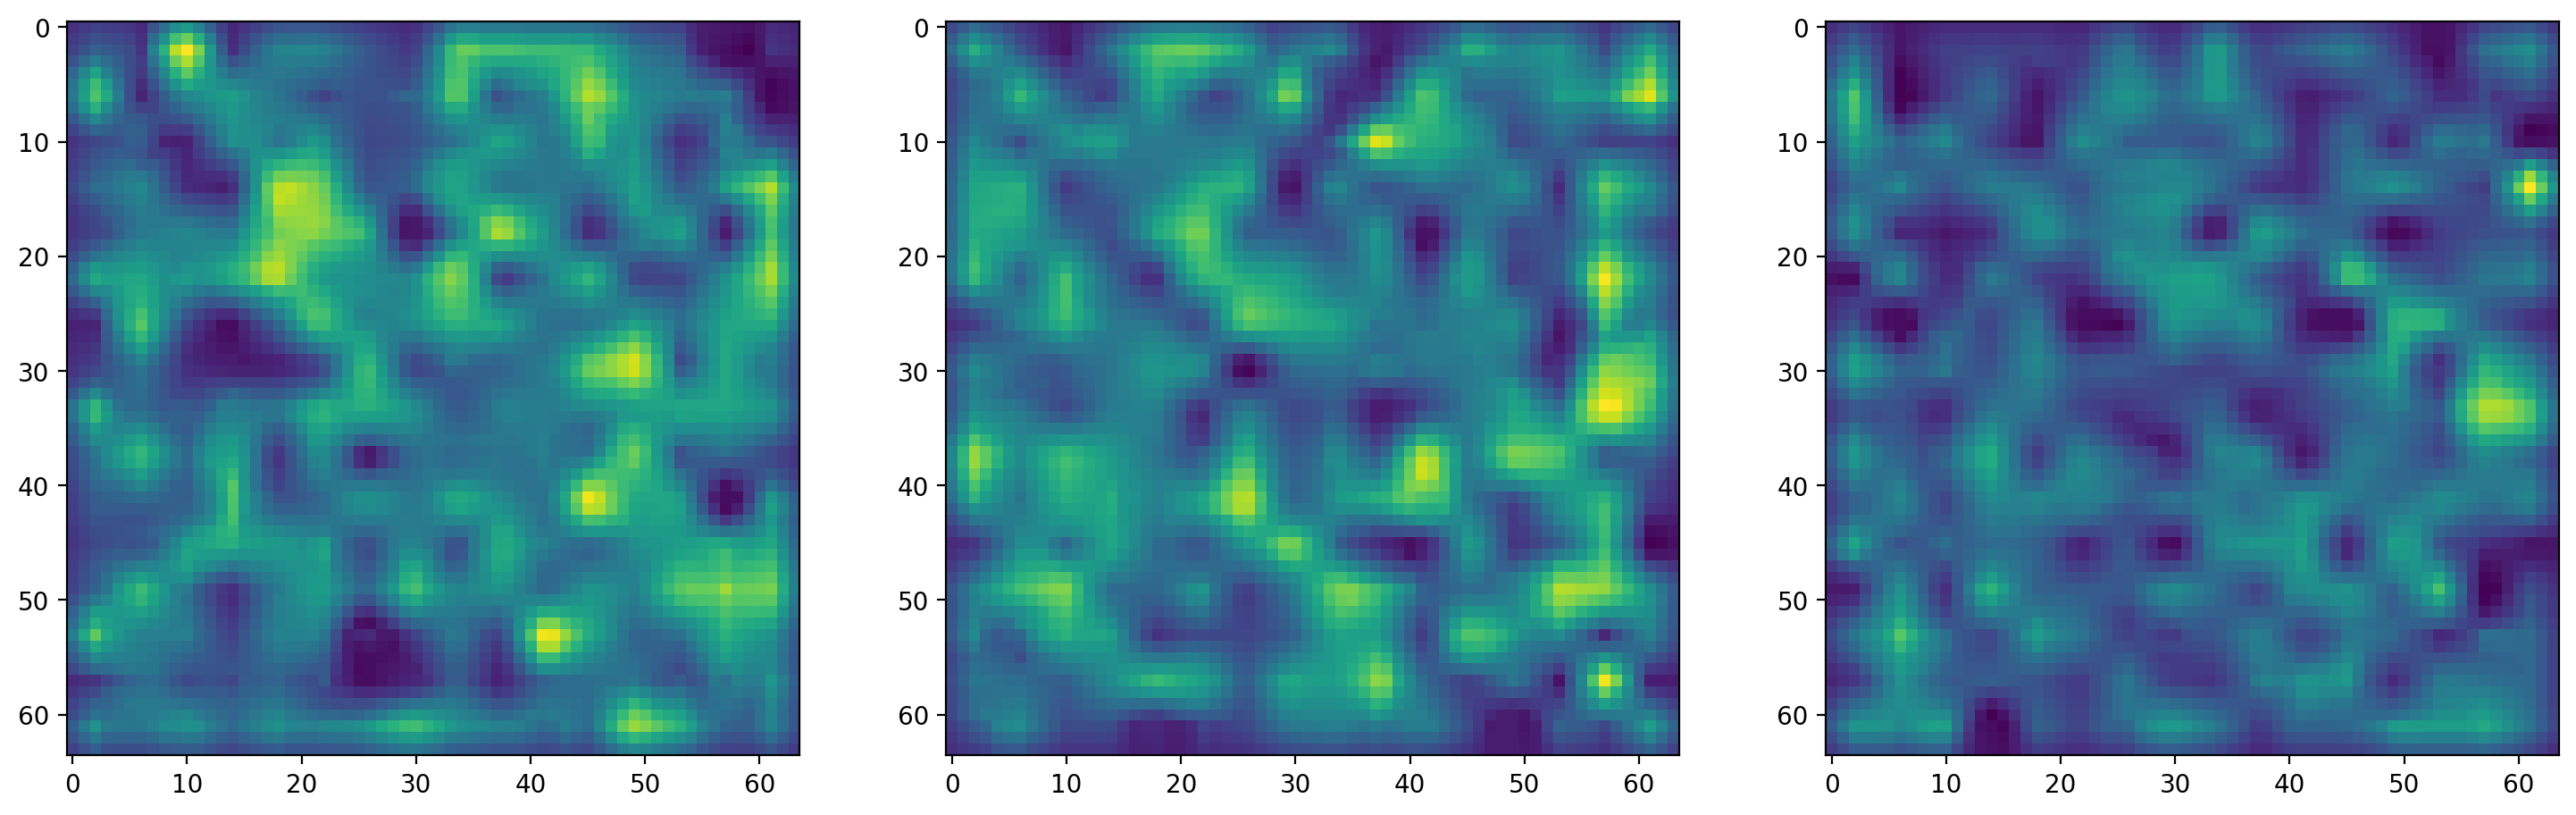

Step 500: loss = 0.07
torch.Size([64, 64, 64, 2])


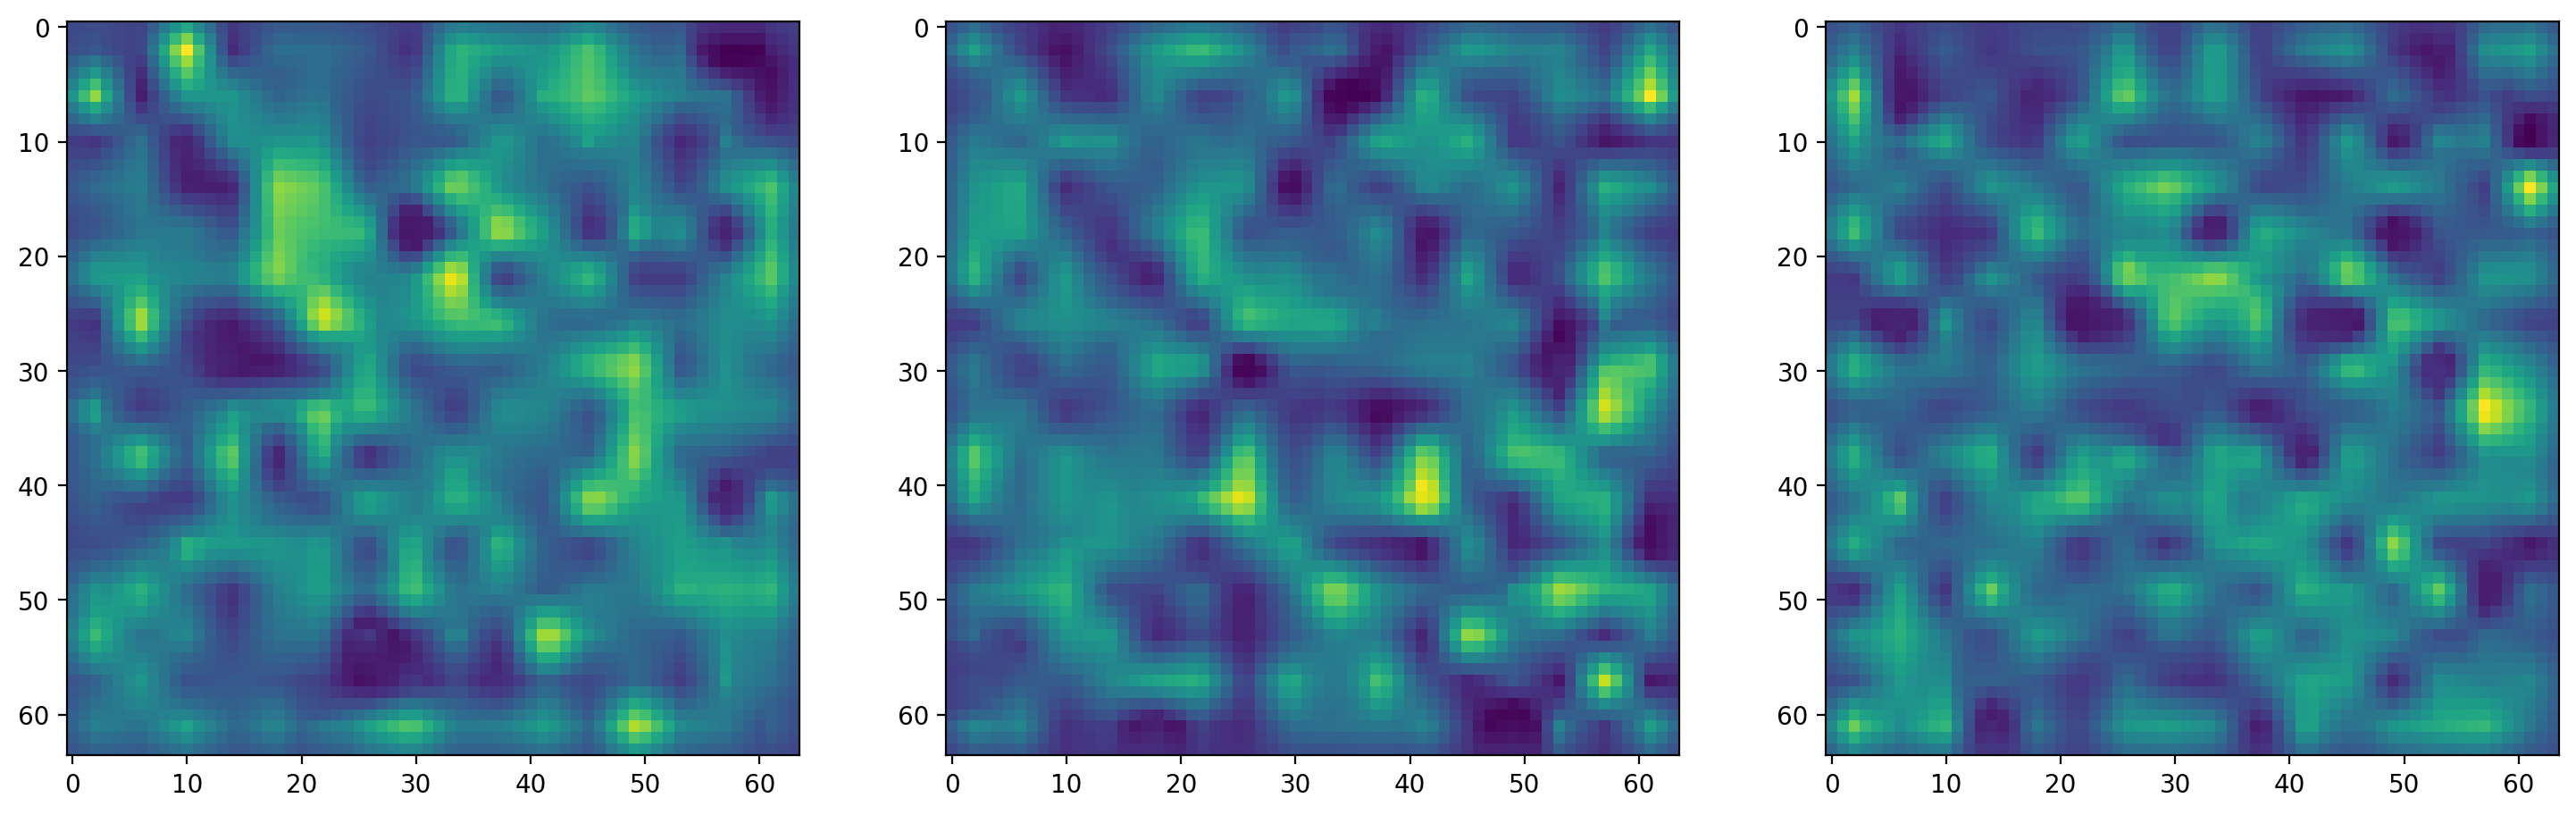

Step 1000: loss = 0.06
torch.Size([64, 64, 64, 2])


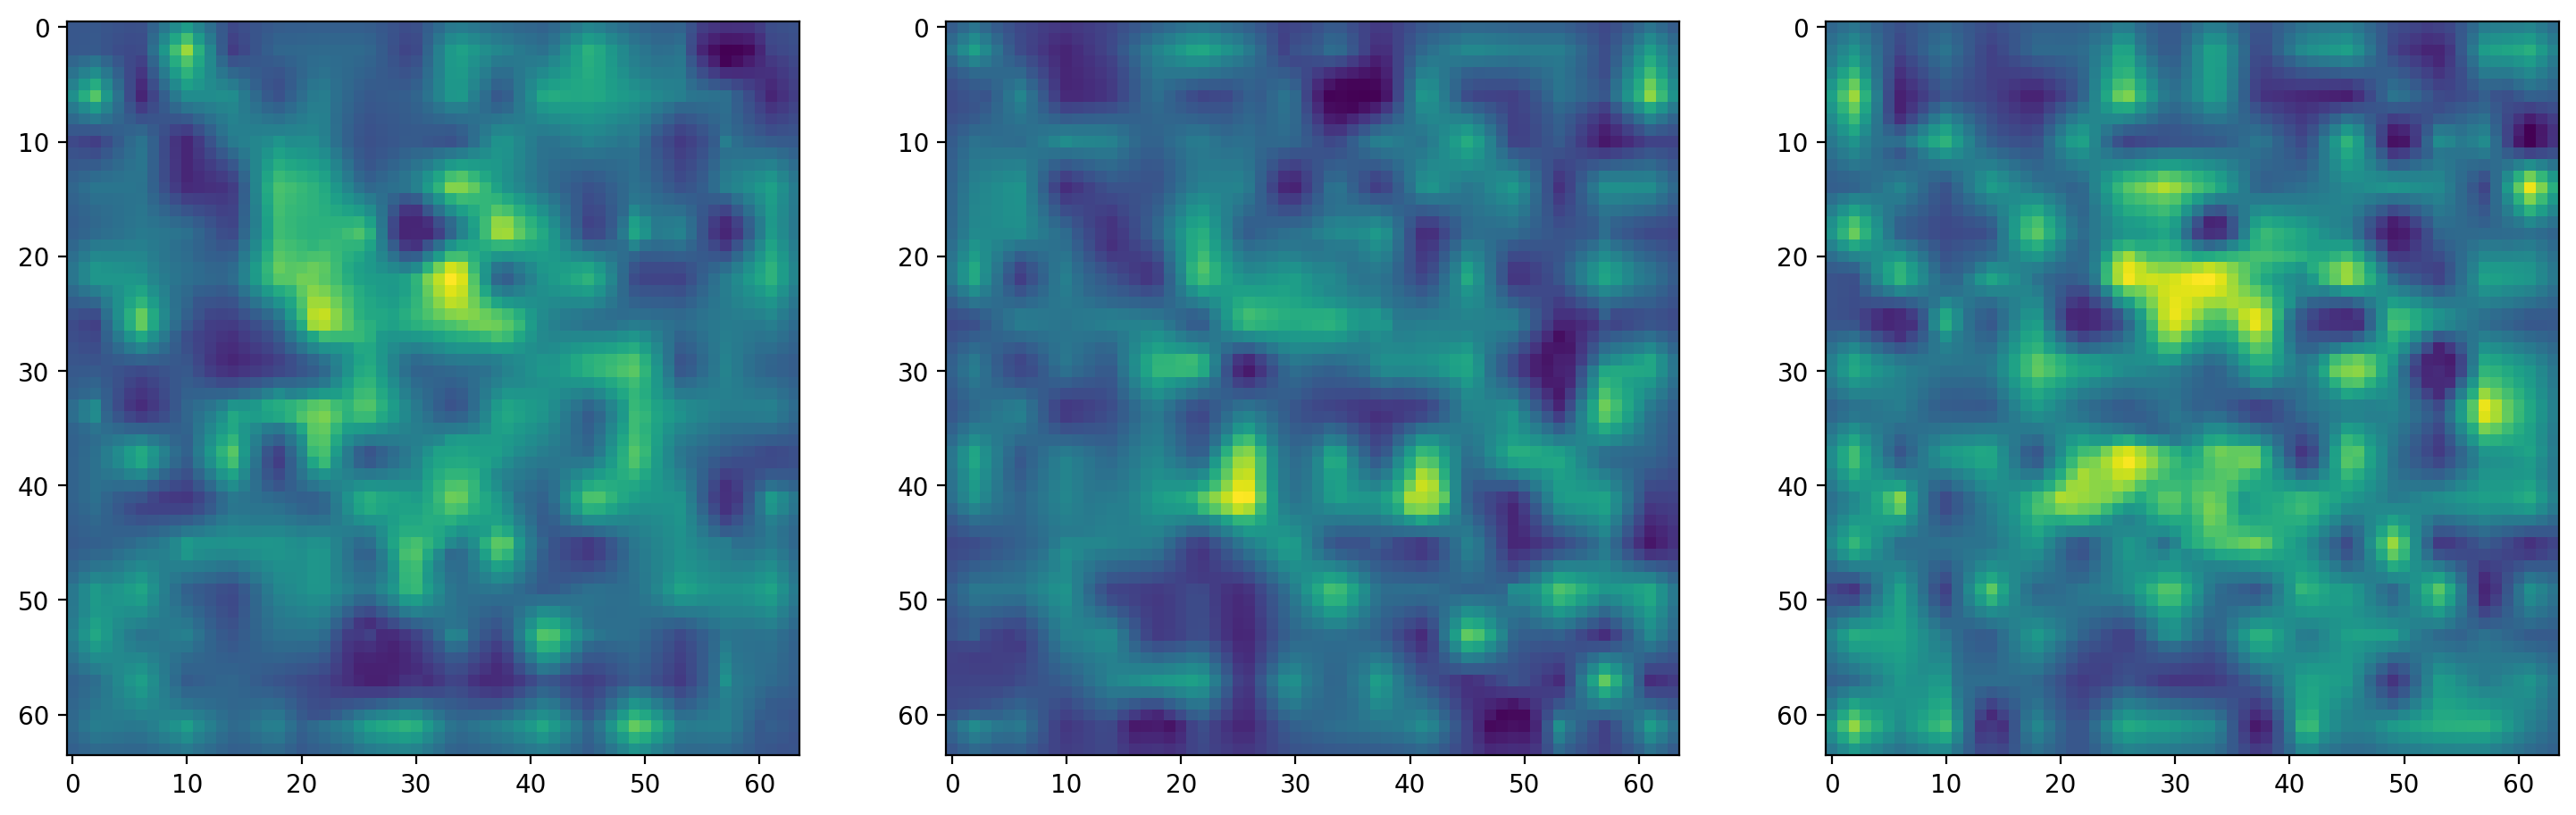

Step 1500: loss = 0.04
torch.Size([64, 64, 64, 2])


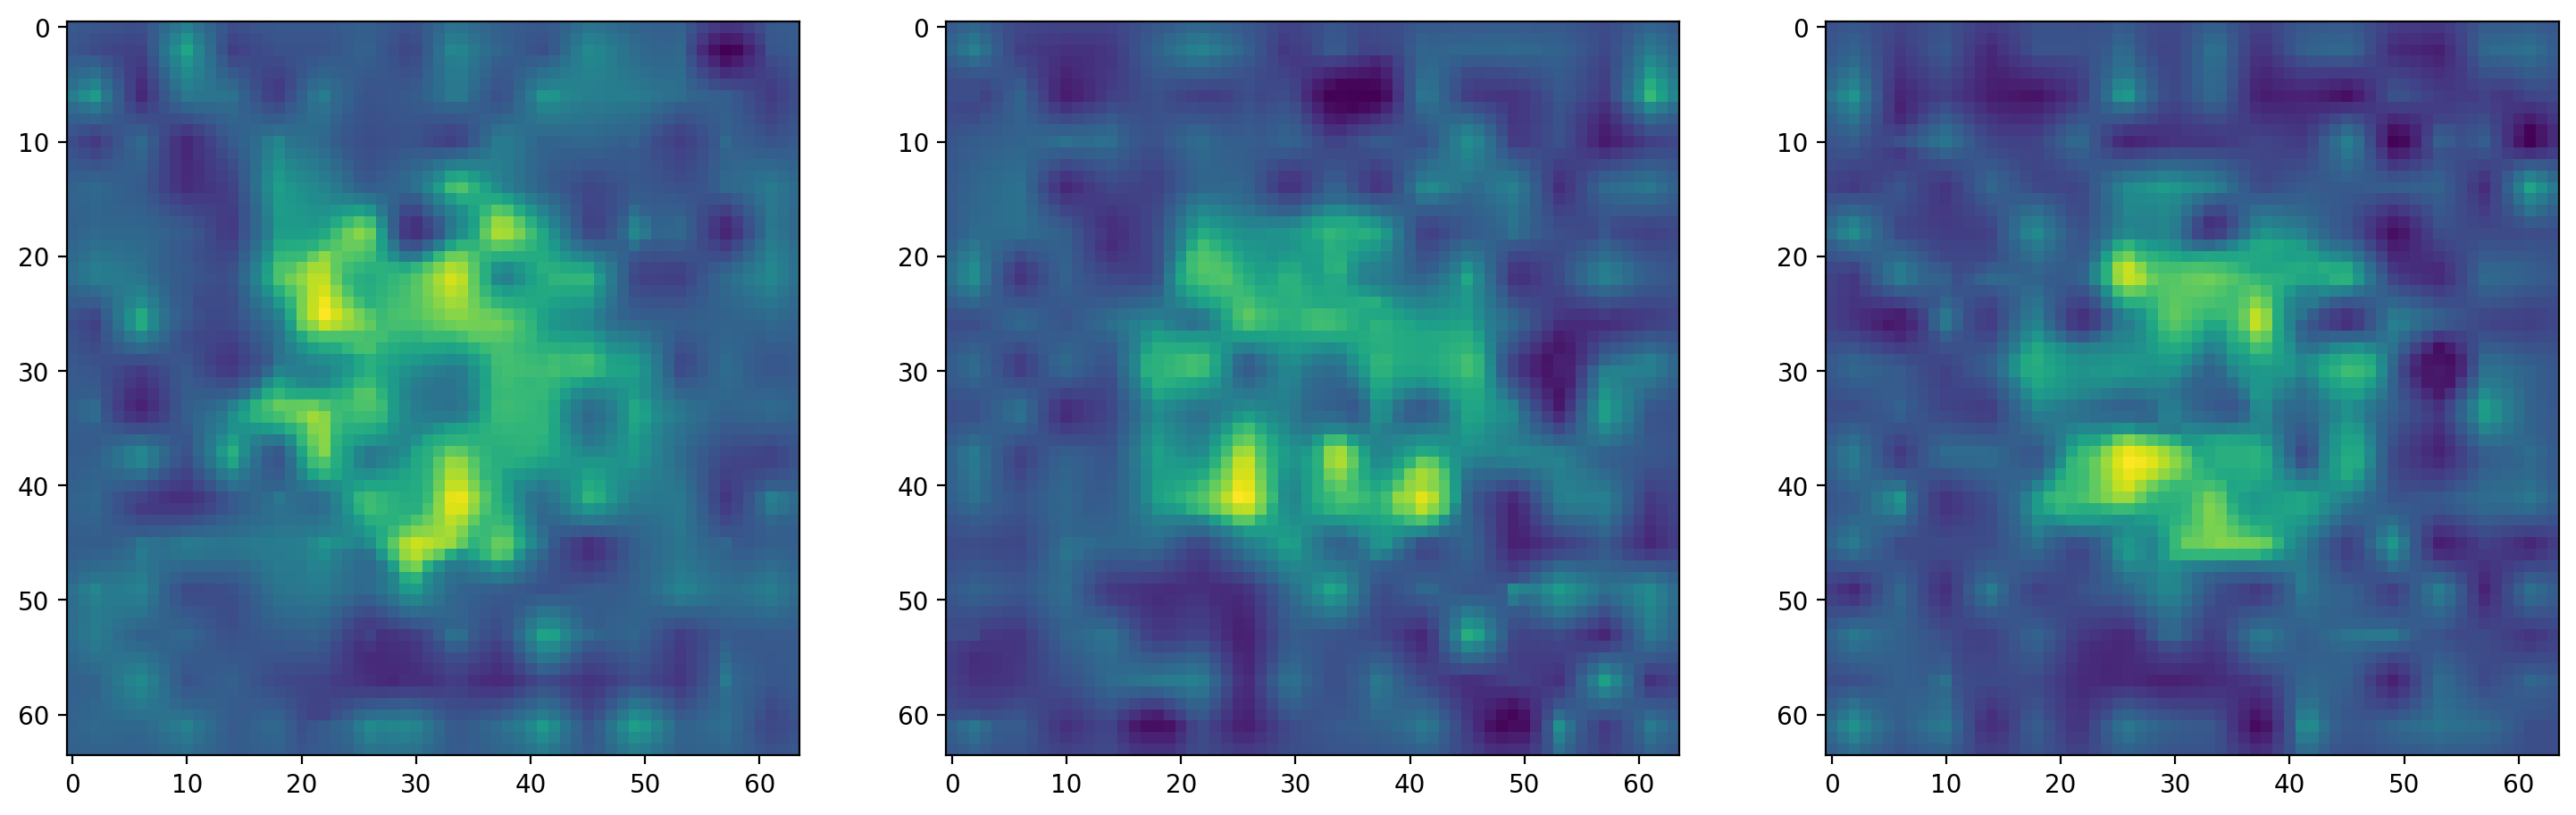

Step 2000: loss = 0.02
torch.Size([64, 64, 64, 2])


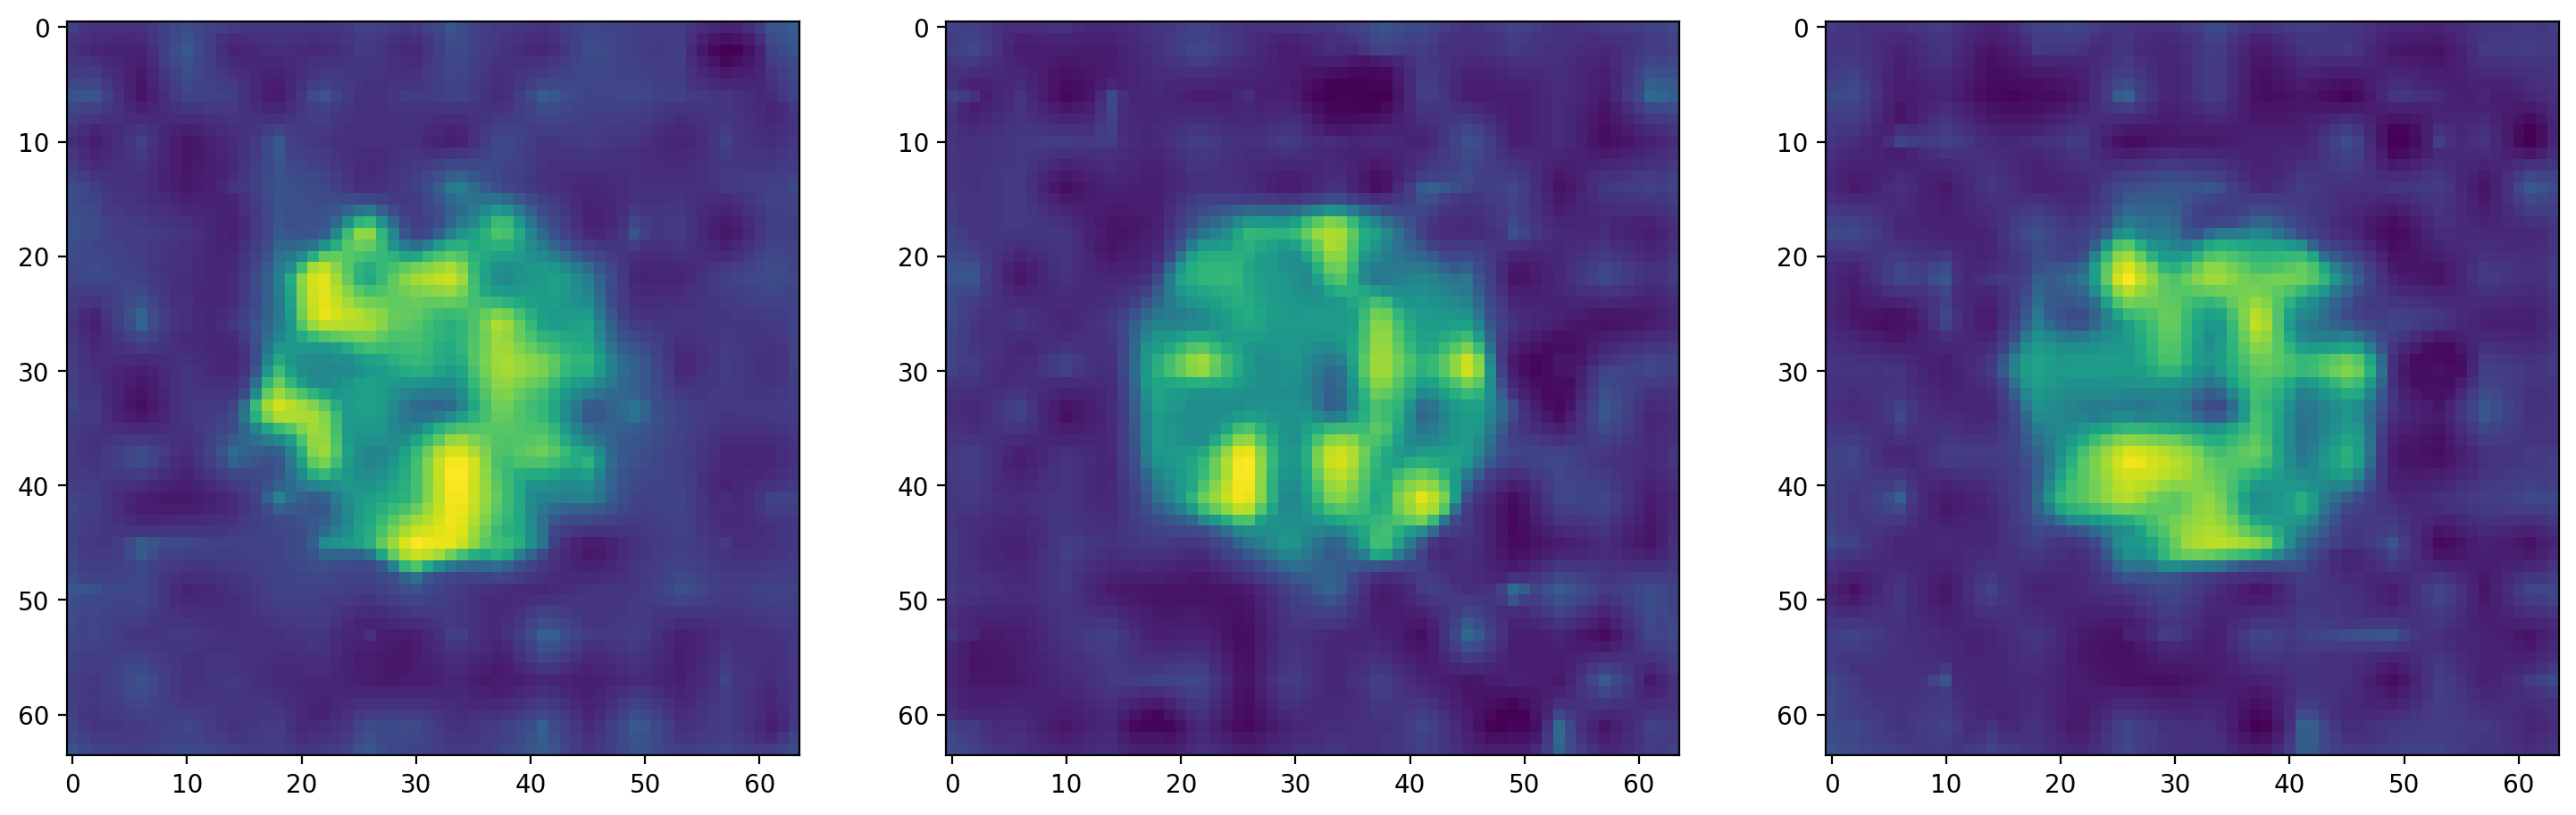

Step 2500: loss = 0.01
torch.Size([64, 64, 64, 2])


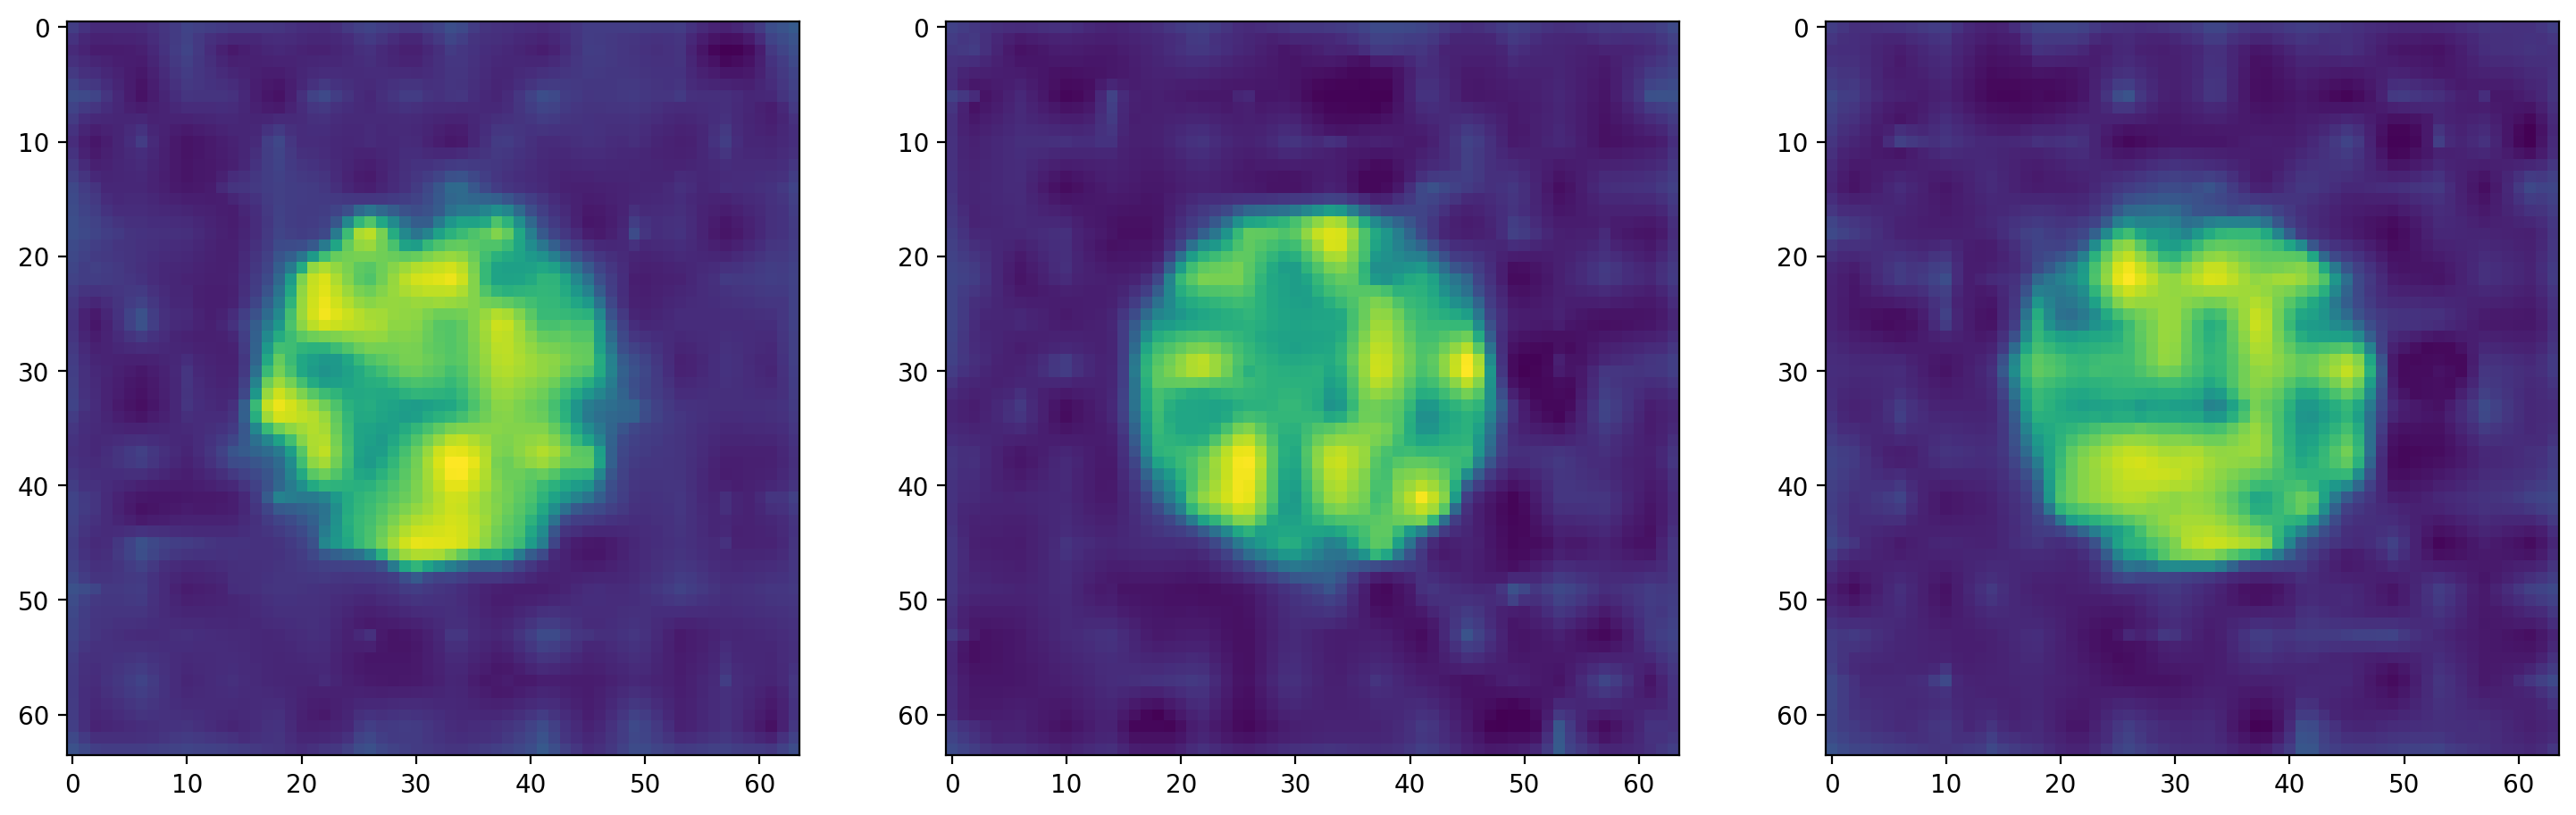

Step 3000: loss = 0.01
torch.Size([64, 64, 64, 2])


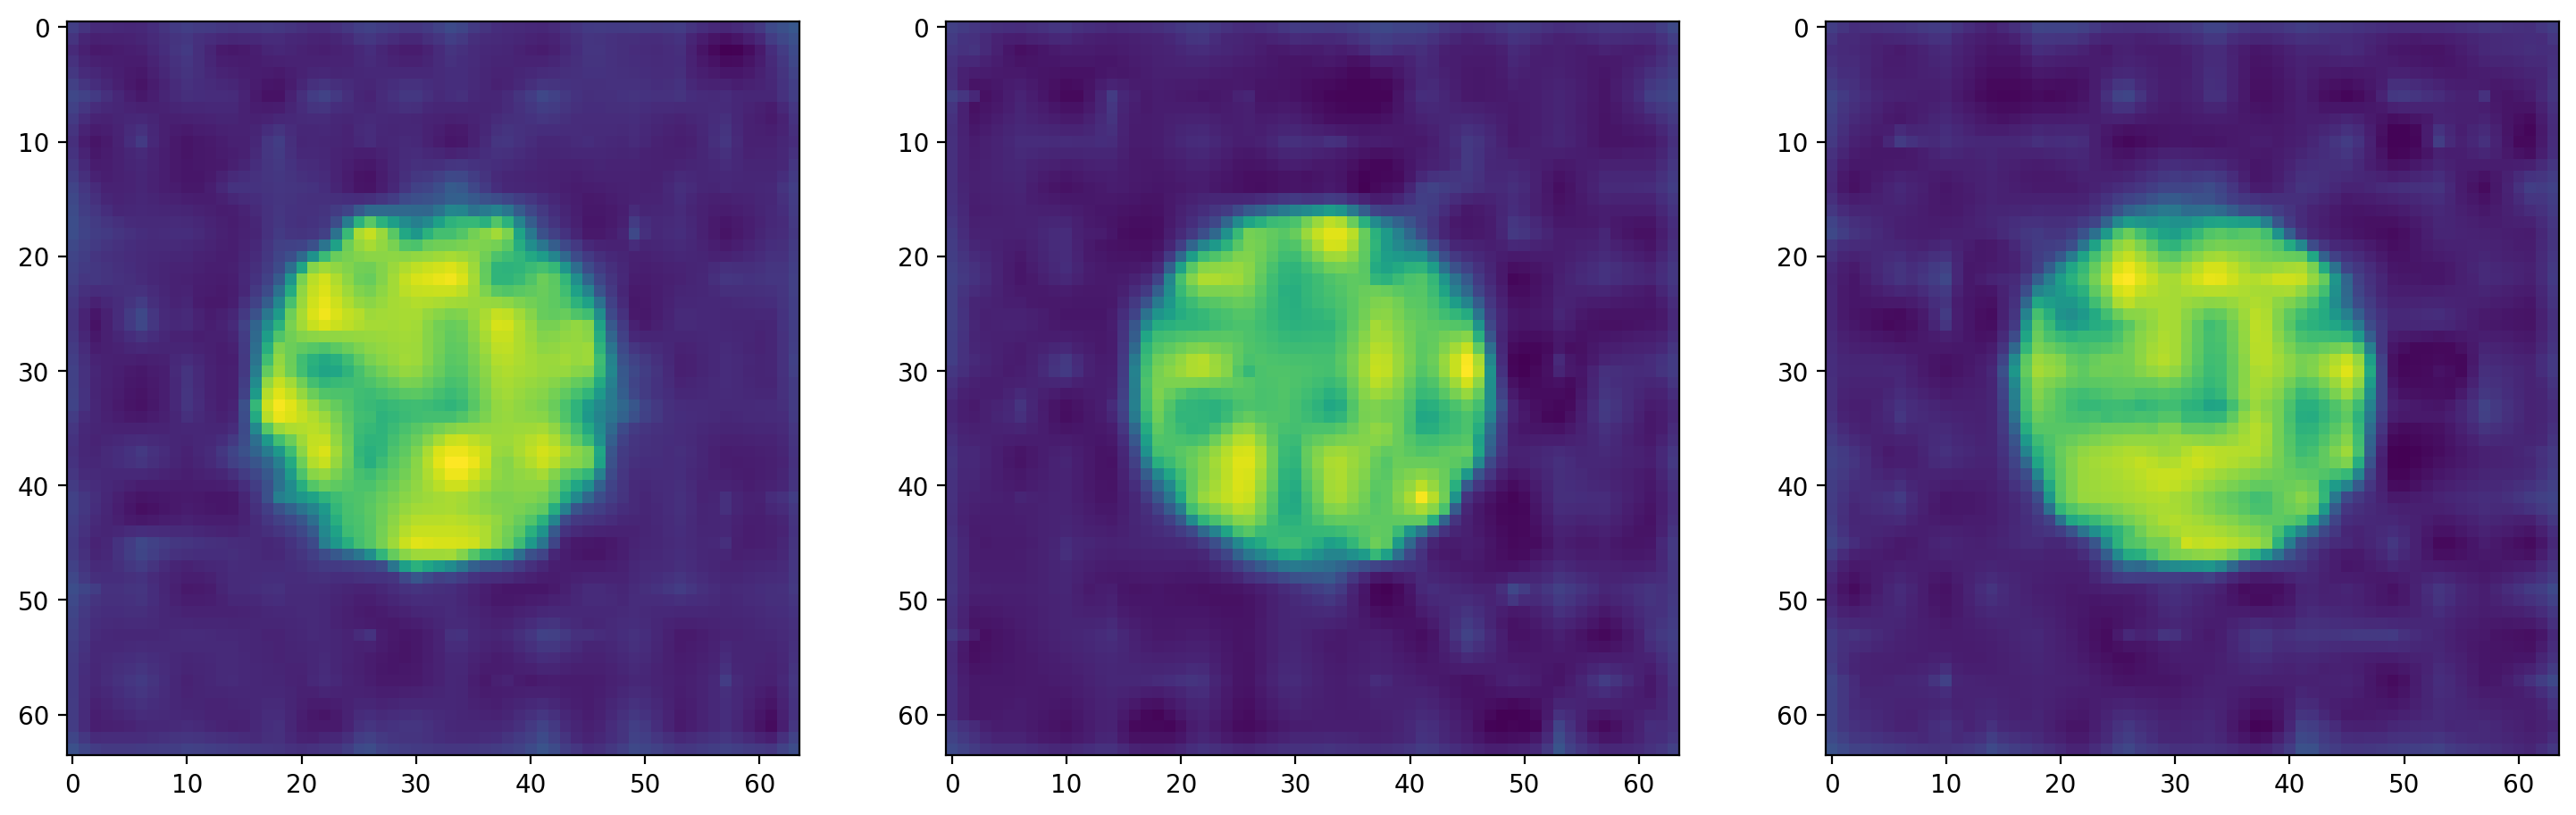

Step 3500: loss = 0.01
torch.Size([64, 64, 64, 2])


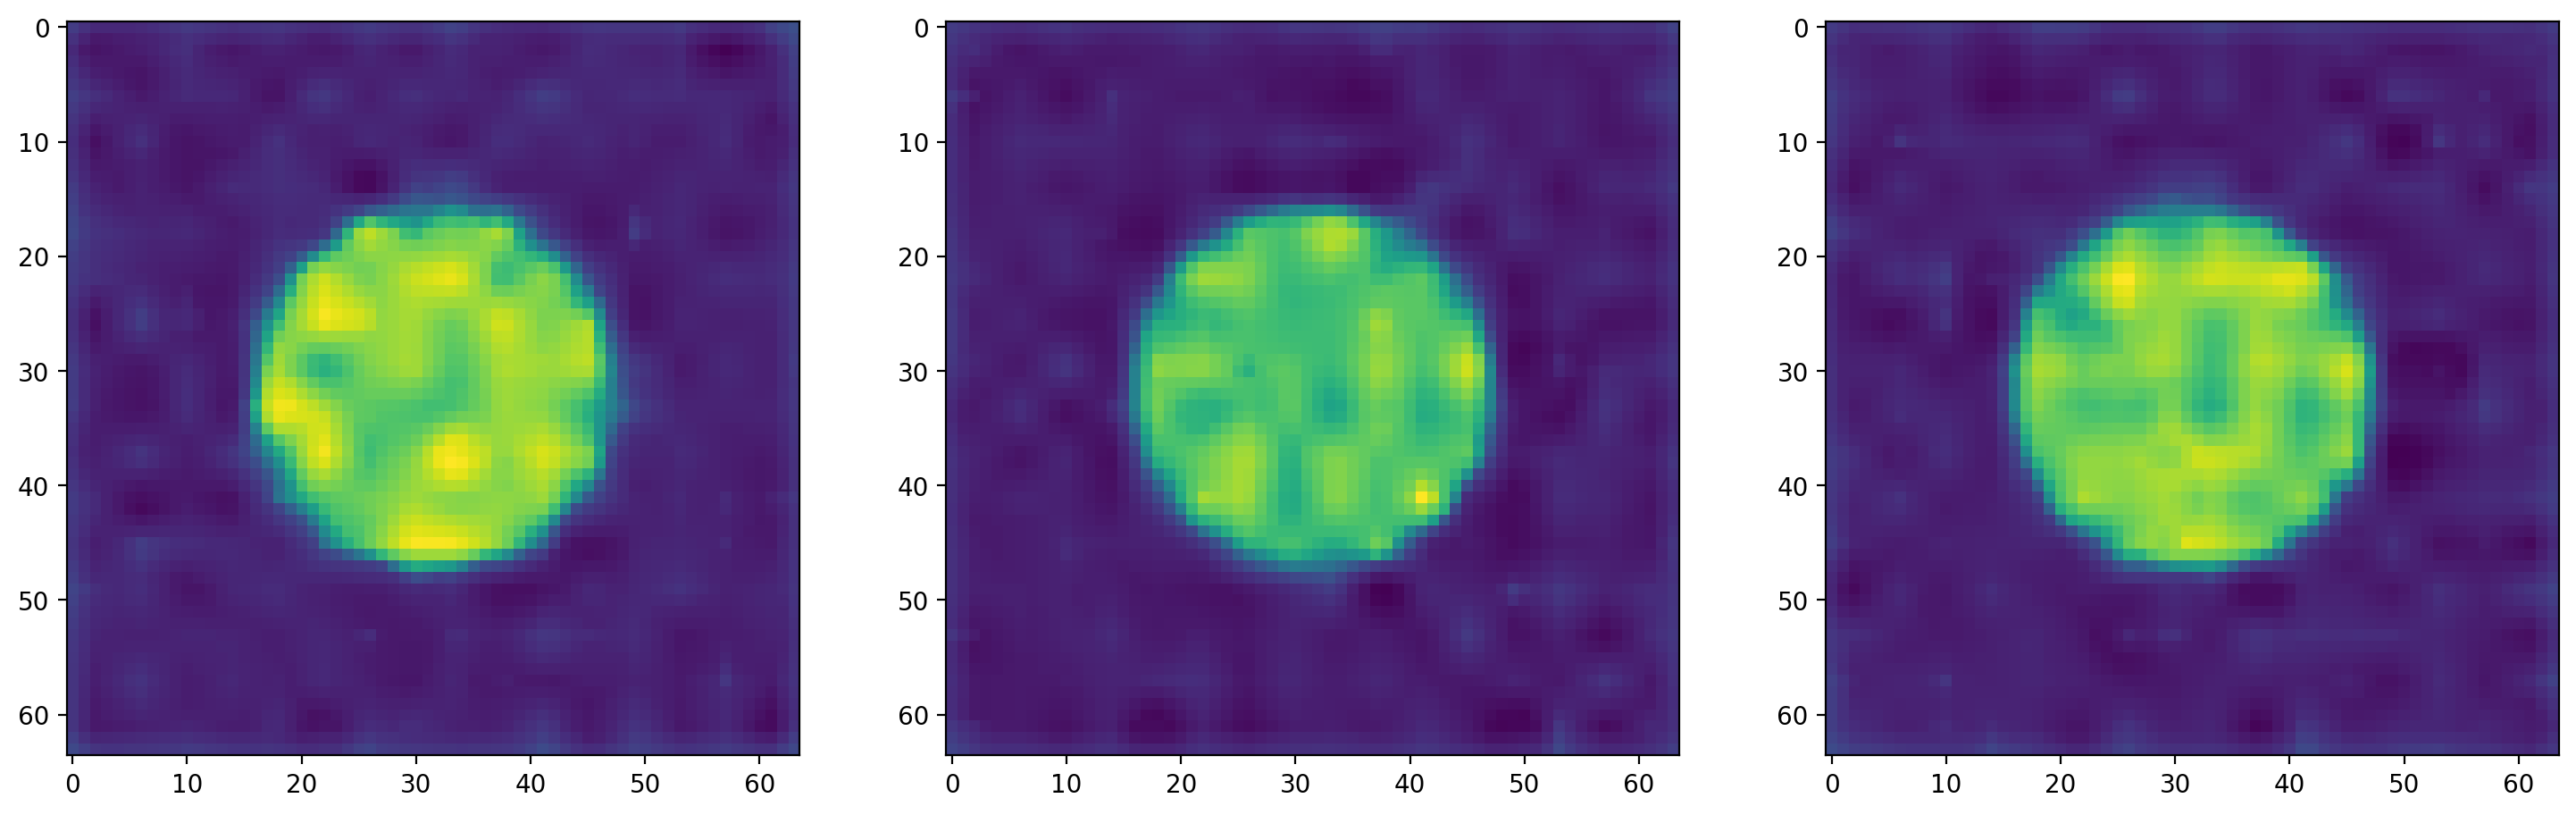

Step 4000: loss = 0.00
torch.Size([64, 64, 64, 2])


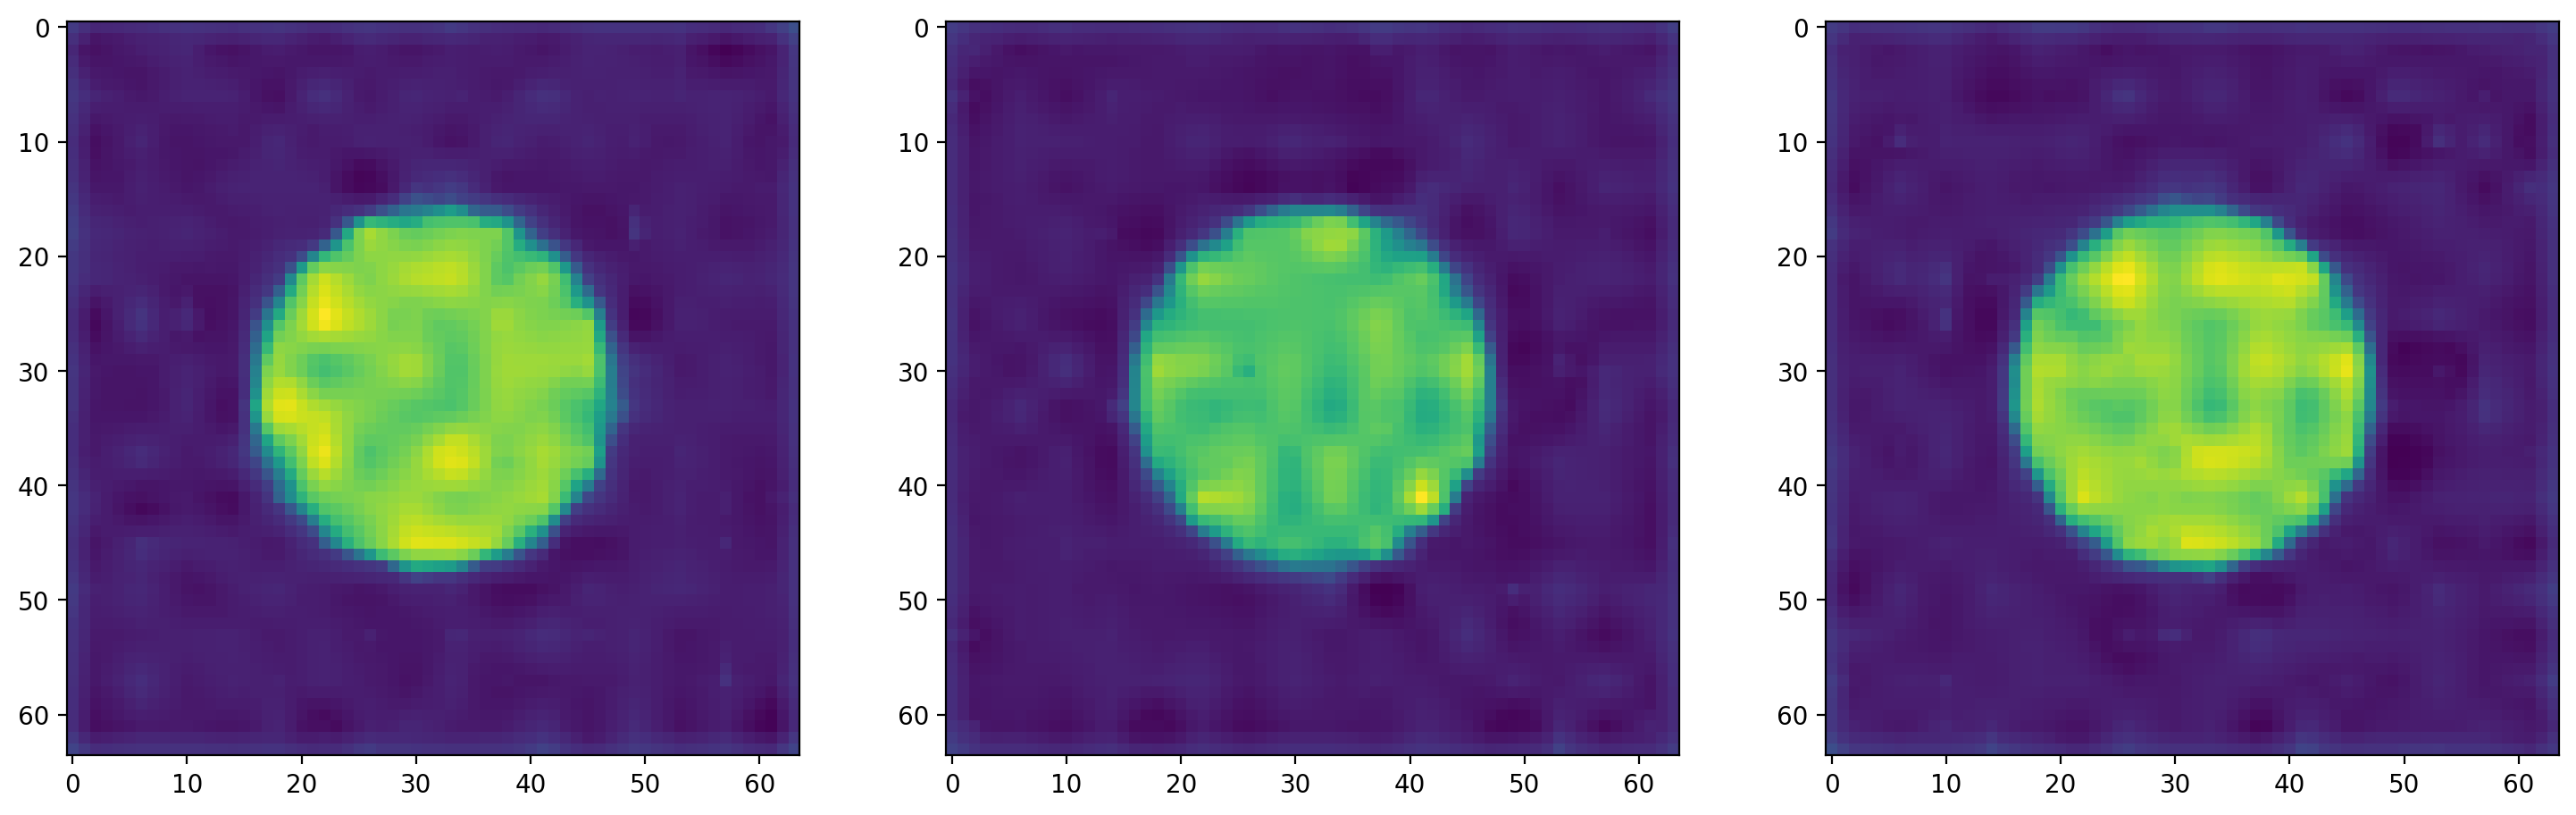

Step 4500: loss = 0.00
torch.Size([64, 64, 64, 2])


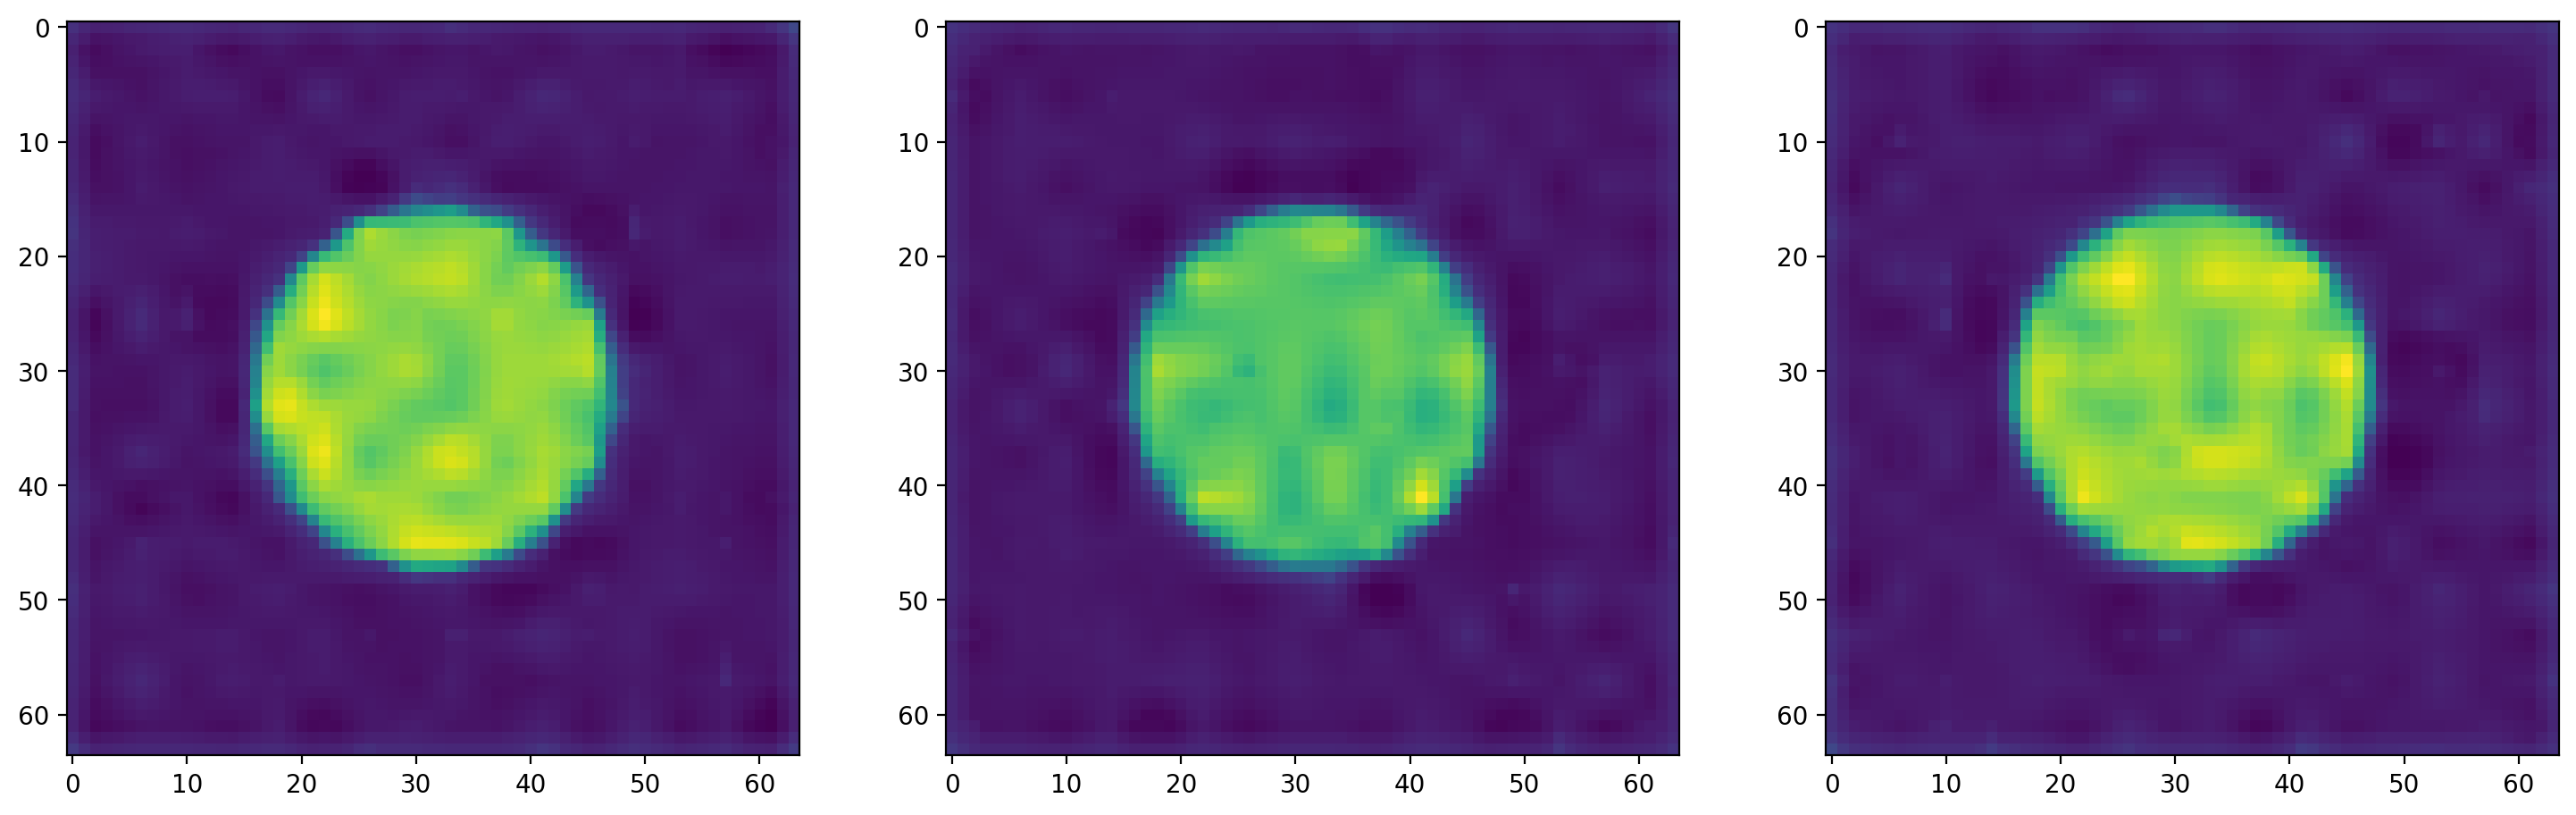

Step 5000: loss = 0.00
torch.Size([64, 64, 64, 2])


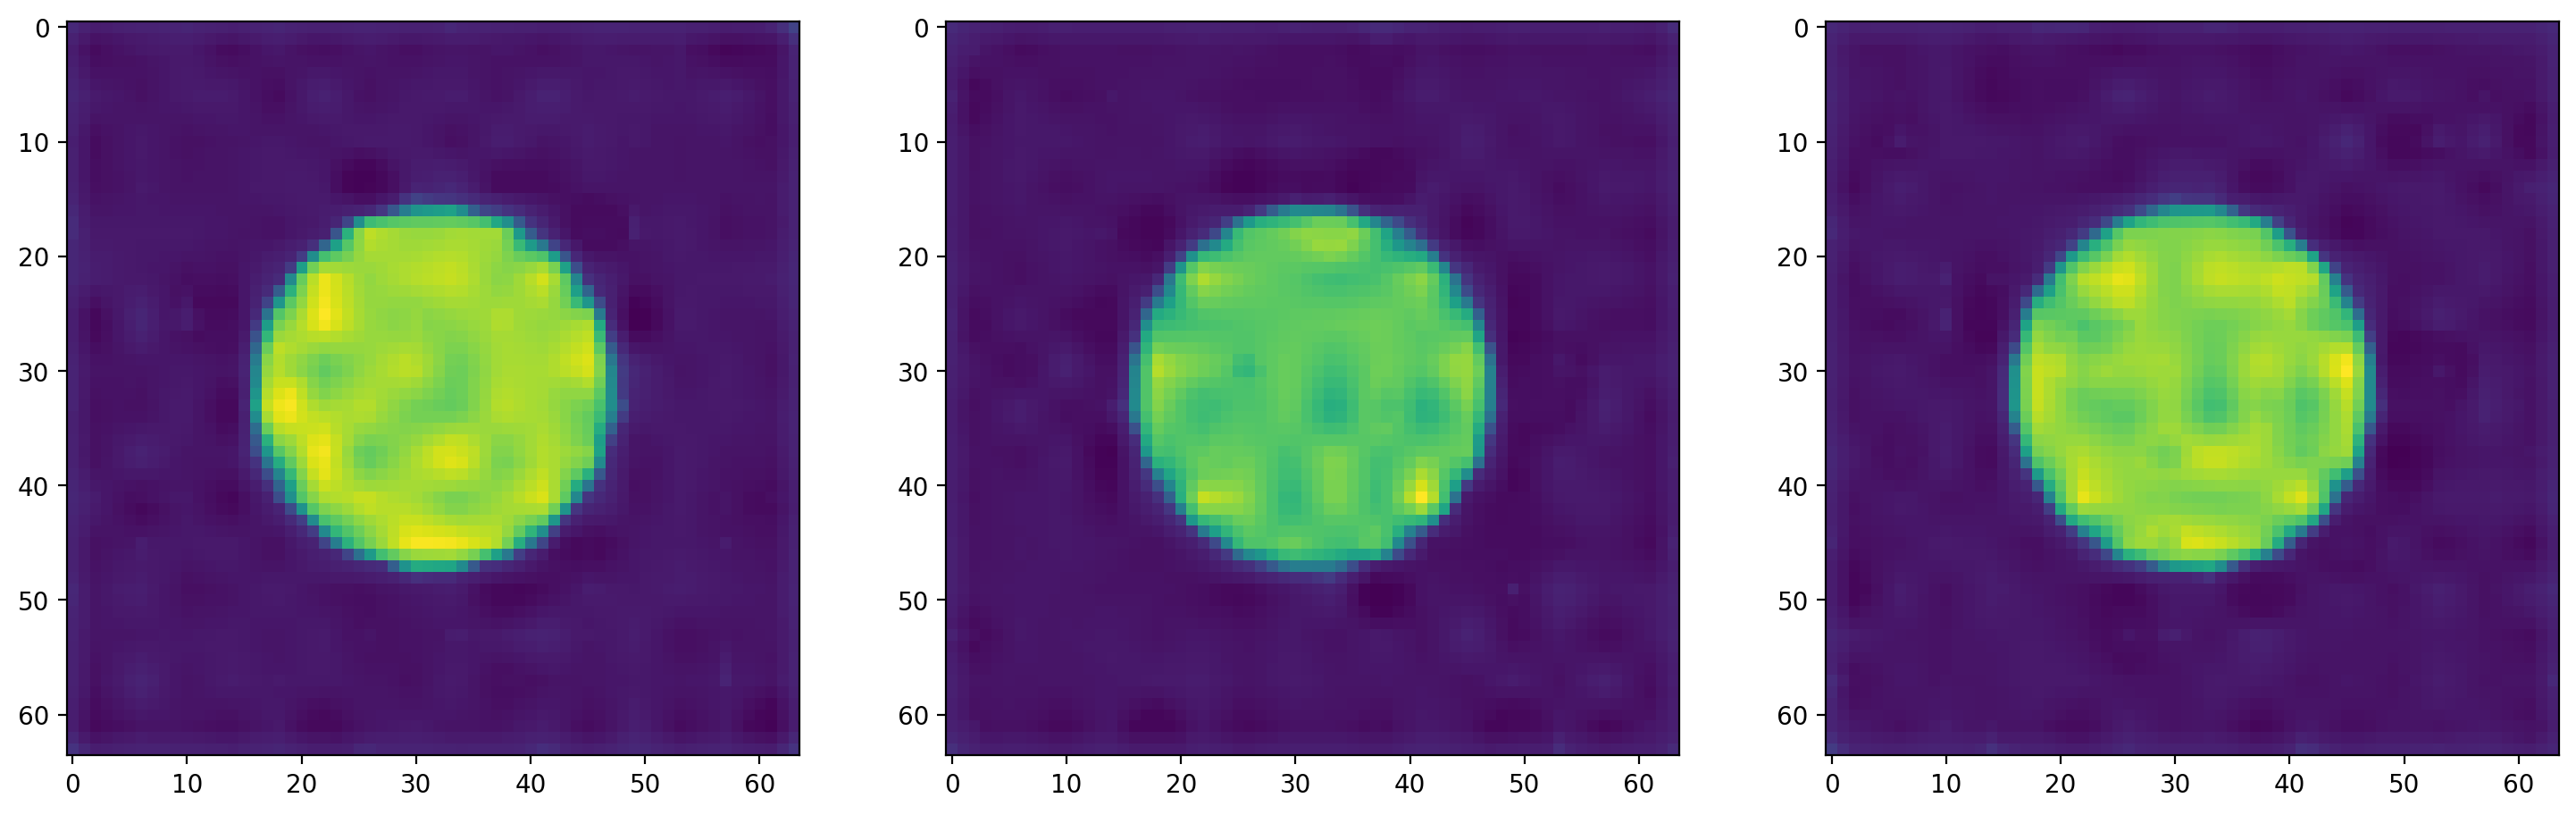

In [46]:
losses = fit_field(
    hybrid, 
    dataset, 
    occ_loss,
    (64, 64, 64), 
    sample_plot_occ_field, 
    total_steps=5_001, 
    lr=1e-4
)

# check_losses("Fitting voxel neural field", losses, 5e-2)

Note how much faster this was! However, now we have to store a voxelgrid, which is awfully dense, especially when in many 3D scenes, there really is mostly empty space.

## 2.3. Hybrid discrete-continuous 3D representation: groundplan-neural-field

Let's consider an alternative: we'll choose a different factorization of 3D using our hybrid data structure, namely a 2D grid of feature in the x-y plane, and a neural field in the y-axis - in other words, a neural "ground plan"!

Specifically, we now factorize our field into two components:
1. A 2D grid of features, $\Theta$, that lies in the XY-plane of our coordinate frame. Given a 3D world coordinate, we sample from $\Theta$ by dropping the y-coordinate (yielding a 2D coordinate) and sampling our ground plan at that 2D coordinate.
2. A little MLP that takes as input the y-coordinate (the one that we dropped), as well as the interpolated feature from the ground plan.

Relevant papers:
1. [Convolutional Occupancy Networks (Peng et al.)](https://pengsongyou.github.io/conv_onet)
2. [Unconstrained Scene Generation with Locally Conditioned Radiance Fields, (DeVries et al.)](https://apple.github.io/ml-gsn/)
3. [Seeing 3D Objects in a Single Image via Self-Supervised Static-Dynamic Disentanglement (Sharma et al.)](https://prafullsharma.net/see3d/)
4. [Tensor Radiance Fields](https://apchenstu.github.io/TensoRF/)

In [47]:
class HybridGroundPlanNeuralField(nn.Module):
    def __init__(self, resolution_per_dim, feature_dim, out_dim, mode='bilinear'):
        super().__init__()
        
        ########
        # TODO
        # Generate an nn.Parameter that stores a tensor of shape 
        # (1, feature_dim, resolution_per_dim[0], resolution_per_dim[1]).
        tensor_shape = (1, feature_dim, *resolution_per_dim)
        self.grid = nn.Parameter(torch.rand(*tensor_shape))

        self.mode = mode
        
        # Create a MLP using the following configuration
        # (1) (linear, relu) with feature_dim + 1 inputs and feature_dim outputs
        # (2) (linear, relu) with feature_dim inputs and feature_dim outputs
        # (3) (linear, relu) with feature_dim inputs and feature_dim outputs
        # (4) (linear) with feature_dim inputs and out_dim outputs
        self.mlp = nn.Sequential(nn.Linear((feature_dim + 1), feature_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(feature_dim, out_dim))
        
        # Apply init_weights_normal to the mlp
        self.mlp.apply(init_weights_normal)
    
    def forward(self, coordinate):
        # Coordinates (batch_size, num_points, 3)

        ######
        # TODO
        
        # Project coordinate onto xy-plane
        xy = coordinate[..., :2].to(device)
        
      
        # Add dim to get (batch_size, num_points, 1, 3)
        xy = xy.unsqueeze(2)
  

        # Extract the z-coordinate
        z = coordinate[... , 2].unsqueeze(2).to(device)
                
        # sample ground plan using the grid_sample function using the specified
        # mode and query xy coordinates.
        values =  nn.functional.grid_sample(self.grid, xy, self.mode).to(device)
        
        
        # reshape and permute such that values have a shape of 
        # (batch_size, num_points, latent_dimension)
        B, N, P, D = values.shape
        values = values.permute(0, 2, 3, 1).reshape(B, P, N)
        

        # Concatenate with z coordinate and infer the mlp on values and store 
        # it in variable values.
        values = self.mlp(torch.cat([values, z], dim=-1)).cpu()

        return values
        
        ######



In [48]:
hybrid_ground_plan = HybridGroundPlanNeuralField((64, 64), 64, out_dim=2).to(device)

In [49]:
# losses = fit_field(
#     hybrid_ground_plan, 
#     dataset, 
#     occ_loss,
#     (64, 64, 64), 
#     sample_plot_occ_field, 
#     total_steps=5_001, 
#     lr=1e-3
# )



# check_losses("Fitting groundplan", losses, 1e-2)

As you can see, we can fit the occupancy function with all three parameterizations. They merely provide different memory-compute trade-offs, and expose different kinds of locality.

For instance, it is straightforward and very meaningful to run a 3D convolution on the voxelgrid.

It is straightforward to run a 2D convolution on the groundplan, though note that this is a bit similar to running a 2D convolution on a depth map / height map, i.e., not a true 3D operation (it would be a bit like running a 2D convolution on an architectect's floorplan of your apartment).

Finally, it is not tractable to run a 2D convolution on the neural field.

# Part 3: Differentiable Rendering

Now, let's move on to differentiable rendering and inverse graphics - i.e., fitting of a 3D representation given only images. 

To this end, we'll use the multi-view geometry functions that you wrote in the previous assignment! 

Not only that, we'll also use the images that you rendered. This just goes to show - you have implemented basically 99% of the functions you will ever need for single-view and multi-view geometry!

Relevant papers:
1.   [Neural Radiance Fields](https://arxiv.org/abs/2003.08934), Mildenhall et al. 2020 
2.   [Scene Representation Networks](https://arxiv.org/abs/1906.01618), Sitzmann et al. 2019
3.   [Implicit Differentiable Renderer](https://arxiv.org/abs/2003.09852), Yariv et al. 2020


## 3.0. Multi-view geometry functions

We will first import your multi-view and single-view geometry functions from the previous assignment.


In [50]:
from einops import rearrange, repeat
import numpy as np
import imageio
import collections

In [51]:
def homogenize_points(points: torch.Tensor):
    """Appends a "1" to the coordinates of a (batch of) points of dimension DIM.

    Args:
        points: points of shape (..., DIM)

    Returns:
        points_hom: points with appended "1" dimension.
    """
    ones = torch.ones_like(points[..., :1], device=points.device)
    return torch.cat((points, ones), dim=-1)


def homogenize_vecs(vectors: torch.Tensor):
    """Appends a "0" to the coordinates of a (batch of) vectors of dimension DIM.

    Args:
        vectors: vectors of shape (..., DIM)

    Returns:
        vectors_hom: points with appended "0" dimension.
    """
    zeros = torch.zeros_like(vectors[..., :1], device=vectors.device)
    return torch.cat((vectors, zeros), dim=-1)


def unproject(
    xy_pix: torch.Tensor, 
    z: torch.Tensor, 
    intrinsics: torch.Tensor
    ) -> torch.Tensor:
    """Unproject (lift) 2D pixel coordinates x_pix and per-pixel z coordinate
    to 3D points in camera coordinates.

    Args:
        xy_pix: 2D pixel coordinates of shape (..., 2)
        z: per-pixel depth, defined as z coordinate of shape (..., 1) 
        intrinscis: camera intrinscics of shape (..., 3, 3)

    Returns:
        xyz_cam: points in 3D camera coordinates.
    """
    xy_pix_hom = homogenize_points(xy_pix)
    xyz_cam = torch.einsum('...ij,...j->...i', intrinsics.inverse(), xy_pix_hom)
    xyz_cam *= z
    return xyz_cam
    

def transform_world2cam(xyz_world_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Convert the 3D point cloud camera coordinates to world coordinates.

    Args:
        xyz_world_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_cam: points in camera coordinates.
    """
    world2cam = torch.inverse(cam2world)
    return transform_rigid(xyz_world_hom, world2cam)


def transform_cam2world(xyz_cam_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_cam_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_world: points in camera coordinates.
    """
    return transform_rigid(xyz_cam_hom, cam2world)


def transform_rigid(xyz_hom: torch.Tensor, T: torch.Tensor) -> torch.Tensor:
    """Apply a rigid-body transform to a (batch of) points / vectors.

    Args:
        xyz_hom: homogenized 3D points of shape (..., 4)
        T: rigid-body transform matrix of shape (..., 4, 4)

    Returns:
        xyz_trans: transformed points.
    """ 
    return torch.einsum('...ij, ...j -> ...i', T, xyz_hom)


def get_camera_ray_directions(xy_pix:torch.Tensor,
                              intrinsics:torch.Tensor) -> torch.Tensor:
    """Returns the 3D ray directions for xy_pix coordinates in camera coordinates.
    """
    p = unproject(xy_pix, 
                  torch.ones_like(xy_pix[..., :1], device=xy_pix.device), 
                  intrinsics=intrinsics)
    return torch.nn.functional.normalize(p, dim=-1)


def get_unnormalized_cam_ray_directions(xy_pix:torch.Tensor,
                                        intrinsics:torch.Tensor) -> torch.Tensor:
    return unproject(xy_pix, torch.ones_like(xy_pix[..., :1], device=xy_pix.device),  intrinsics=intrinsics)       

### 3.0.1 Setting up the dataset

Next, we'll download the images and OpenCV camera poses that we generated in the last assignment!

In [52]:
# !gdown 1XgHO9qxqlnXLldT0dHB2NV2-IXdhgwsZ
# !gdown 1mtebVnstV397QYxm6qPGLO1-lj-URlh0

In [53]:
cam2world = np.load('cam2world.npy')
images = np.load('images.npy')

cam2world = torch.Tensor(cam2world).cuda()
images = torch.tensor(images).cuda()
intrinsics = torch.tensor([[0.7, 0., 0.5],
                            [0., 0.7, 0.5],
                            [0., 0., 1.]]).cuda()
print(cam2world.shape, images.shape)

torch.Size([100, 4, 4]) torch.Size([100, 128, 128, 4])


Just as before, below, we set up a dataset generator. 

Our model is now more complicated: It will take as input all of the camera parameters (intrinsics and extrinsics), and the pixel coordinates we want to render.

It is convenient to summarize all the model inputs $\mathbf{K}$, $\mathbf{C}_{C2W}$ and $\mathbf{x}_{pix}$ in a single dictionary as follows:

```python
model_input = {'cam2world': ..., 
               'intrinsics': ..., 
               'x_pix': ...}
```

Below, we have implemented the dataset for you.


In [54]:
def get_opencv_pixel_coordinates(
    y_resolution: int,
    x_resolution: int,
    device: torch.device = torch.device('cpu')
    ):
    """For an image with y_resolution and x_resolution, return a tensor of pixel coordinates
    normalized to lie in [0, 1], with the origin (0, 0) in the top left corner,
    the x-axis pointing right, the y-axis pointing down, and the bottom right corner
    being at (1, 1).

    Returns:
        xy_pix: a meshgrid of values from [0, 1] of shape 
                (y_resolution, x_resolution, 2)
    """
    i, j = torch.meshgrid(torch.linspace(0, 1, steps=x_resolution, device=device), 
                          torch.linspace(0, 1, steps=y_resolution, device=device))

    xy_pix = torch.stack([i.float(), j.float()], dim=-1).permute(1, 0, 2)
    return xy_pix
    

def diff_rendering_dataset(images, cam2world):
    '''Generates an iterator from a tensor of images and a tensor of cam2world matrices.
    Yield *one random image per iteration*.
    '''
    image_resolution = images.shape[1:3]
    intrinsics = torch.tensor([[0.7, 0., 0.5], # Copied from last assignment
                               [0., 0.7, 0.5],
                               [0., 0., 1.]]).to(images.device)

    x_pix = get_opencv_pixel_coordinates(*image_resolution)
    x_pix = x_pix.reshape(1, -1, 2).to(images.device)
        
    while True:
        idx = np.random.randint(low=0, high=len(cam2world))
        c2w = cam2world[idx:idx+1]
        ground_truth = images[idx:idx+1]
        model_input = {'cam2world': c2w, 
                        'intrinsics': intrinsics, 
                        'x_pix': x_pix}
        yield model_input, ground_truth[..., :3].view(-1, 3)

Let's test this:

In [55]:
bunny_dataset = diff_rendering_dataset(images, cam2world)

dict_keys(['cam2world', 'intrinsics', 'x_pix'])


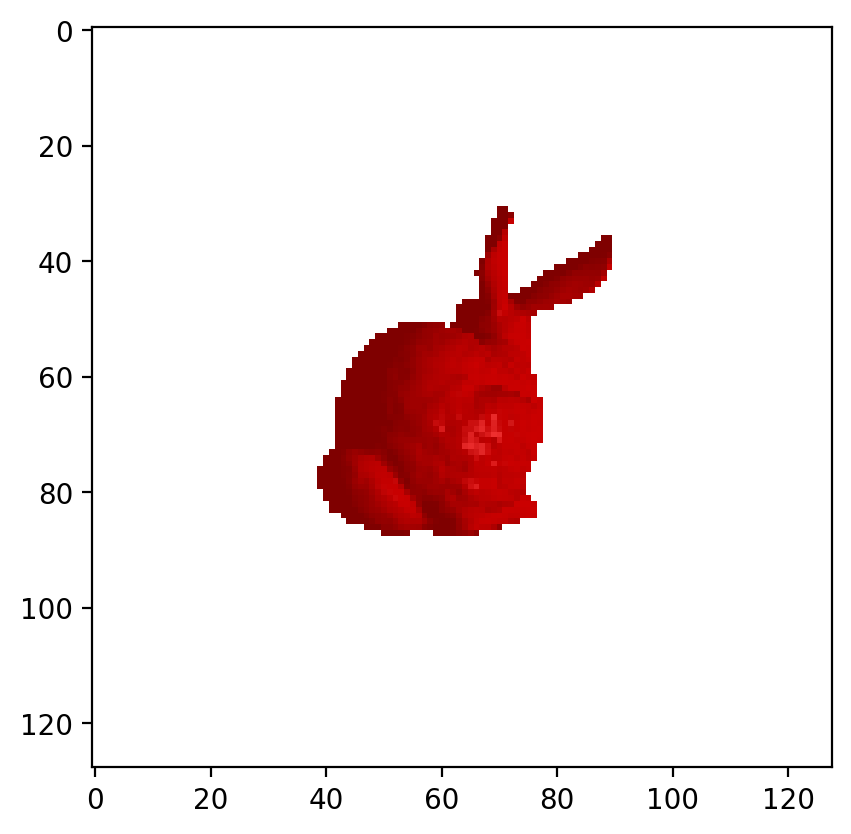

In [56]:
model_input, gt = next(bunny_dataset)

print(model_input.keys())

plt.imshow(gt.view(images.shape[1], images.shape[2], 3).detach().cpu())
plt.show()

Looking good!

## 3.1. Differentiable volume rendering

We're now ready to implement a differentiable renderer.

Specifically, we'll implement a differentiable volume renderer, which is used to render out a radiance field, as proposed in "Neural Radiance Fields" by Mildenhall et al. 2020. For simplicity, we'll implement a version of a radiance field that does not depend on the view direction, i.e., it won't be able to parameterize view-dependent effects (only diffuse materials).

Specifically, then, a radiance field is a function
$$
\Phi: \mathbb{R}^3 \to \mathbb{R}^+ \times \mathbb{R}^3, \quad \Phi(\mathbf{x}) = (\sigma, \mathbf{c})
$$
that maps a 3D coordinate $\mathbf{x}$ to a tuple of emitted radiance $\mathbf{c}$ at that 3D coordinate and local density $\sigma$ at that 3D coordinate.

We could build a Radiance Field on top of _any_ of the 3D representations we have discussed in the previous section! However, as we are limited in terms of compute and memory on Colab, we will resort to the _voxelgrid_ parameterization of the underlying field, which will be fast and relatively cheap (compared to the full neural field parameterization).

Specifically, we will build a radiance field _on top of_ the ground plan class that you implemented above.

Relevant papers:
1. Neural Radiance Fields, Mildenhall et al. 2020
2. Optical models for direct volume rendering, Max 1995

Below, complete the RadianceField class. Follow the comments.

In [57]:
class RadianceField(nn.Module):
    def __init__(self):
        super().__init__()
        #########
        # TODO

        # In a member "self.scene_rep", store a HybridVoxelNeuralField
        # with a sidelength of 64, 64 hidden features, and 64 output features.
        feature_dim = 64
        self.scene_rep = HybridVoxelNeuralField((64, 64, 64), feature_dim, out_dim=64).to(device)
            
        # Write a (ReLU, linear, ReLU) MLP "self.sigma" that will take as input
        # the output of the ground plan field and output a scalar density.
        self.sigma = nn.Sequential(nn.ReLU(inplace=True),
                                   nn.Linear(feature_dim, 1),
                                   nn.ReLU(inplace=True)).to(device)

        # Write a (ReLU, linear, Sigmoid) MLP "self.radiance" that will take as input
        # the output of the ground plan field and output a 3 channel RGB.
        self.radiance = nn.Sequential(nn.ReLU(inplace=True),
                                      nn.Linear(feature_dim, 3),
                                      nn.Sigmoid()).to(device) 

        # Apply init_weights_normal to both mlp models
        self.sigma.apply(init_weights_normal)
        self.radiance.apply(init_weights_normal)

        ########

    def forward(
        self, 
        xyz: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''
          Queries the representation for the density and color values
          '''
          ########
          # TODO

        # Do a forward pass through the scene representation
        features = self.scene_rep(xyz)
        
        # Do a forward pass through both the self.sigma and self.radiance MLPs
        # to yield sigma and color.
        sigma = self.sigma(features.to(device)) 
        rad = self.radiance(features.to(device)) 

      # Return sigma and color.
      ########
        return sigma, rad

Let's test the radiance field by doing a forward pass with random coordinates.

In [58]:
rad = RadianceField()

test_coords = torch.randn(1, 100, 3)
_ = rad(test_coords)

Great! Now, we'll write a volume renderer that can render the radiance field.

### 3.1.1 Computing world camera rays from camera parameters

We'll first implement a function that, given pixel coordinates, camera intrinsic and the cam2world matrix, returns a tuple of (camera_origins_world, ray_directions_world).

You already have all the pieces for that from the last homework, you just need to put them together in a new way!

Implement that function below:

In [59]:
def get_world_rays(xy_pix: torch.Tensor, 
                   intrinsics: torch.Tensor,
                   cam2world: torch.Tensor,
                   ) -> torch.Tensor:
    ######
    # TODO

      # Get camera origin of camera 1
    cam_origin_world = cam2world[..., :3, -1]

    # Get ray directions in cam coordinates
    ray_dirs_cam = get_unnormalized_cam_ray_directions(xy_pix, intrinsics)

    # Homogenize ray directions
    rd_cam_hom = homogenize_vecs(ray_dirs_cam)

    # Transform ray directions to world coordinates
    rd_world_hom = transform_cam2world(rd_cam_hom, cam2world)

    # Tile the ray origins to have the same shape as the ray directions.
    # Currently, ray origins have shape (batch, 3), while ray directions have shape
    cam_origin_world = repeat(cam_origin_world, 'b ch -> b num_rays ch', num_rays=ray_dirs_cam.shape[1])

    # Return tuple of cam_origins, ray_world_directions
    return cam_origin_world, rd_world_hom[..., :3]

check_function("get_world_rays",
                get_world_rays,
                [torch.tensor([[[0., 0.]]]), 
                torch.tensor([[[0.7, 0., 0.5],
                                [0., 0.7, 0.5],
                                [0., 0., 1.]]]),
                torch.tensor([[[1., 0., 0., 0.], 
                                [0., 1., 0., 0.],
                                [0., 0., 1., 0.],
                                [0., 0., 0., 1.]]])],
               
                [torch.tensor([[[0., 0., 0.]]]),
                 torch.tensor([[[-0.7143, -0.7143,  1.0000]]])])

get_world_rays : Your function works!


True

### 3.1.2. Sampling points along rays

Next, we'll implement a function that takes a batch of rays as well as a near plane and far plane as input and returns points uniformly sampled in depth between those two planes. 

We will generate a linspace of depth values `z_vals`. We then implement a batched version of the following function to generate points $\mathbf{X}$ with depth $Z$ along rays with origin $\mathbf{r}_o$ and direction $\mathbf{r}_d$:

$$
\mathbf{X}(Z) = \mathbf{r}_o + \mathbf{r}_d * Z
$$

In the function below, we will want to 
Implement that function below:

In [60]:
def sample_points_along_rays(
    near_depth: float,
    far_depth: float,
    num_samples: int,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
) -> torch.Tensor:
    '''Returns 3D coordinates of points along the camera rays defined by ray_origin
    and ray_directions. Dept values are uniformly sampled between the near_depth and
    the far_depth.

    Parameters:
        near_depth: float. The depth at which we start sampling points.
        far_depth: float. The depth at which we stop sampling points.
        num_samples: int. The number of depth samples between near_depth and far_depth.
        ray_origins: Tensor of shape (batch_size, num_rays, 3). The origins of camera rays.
        ray_directions: Tensor of shape (batch_size, num_rays, 3). The directions of camera rays.

    Returns:
        Tuple of (pts, z_vals).
        pts: tensor of shape (batch_size, num_rays, num_samples, 3). 3D points uniformly sampled
                between near_depth and far_depth
        z_vals: tensor of shape (num_samples) of depths linearly spaced between near and far plane.
    '''
    ######
    # TODO

    # Compute a linspace of num_samples depth values beetween near_depth and far_depth.
    z_vals = torch.linspace(near_depth, far_depth, num_samples, device=device)

    # Using the ray_origins, ray_directions, generate 3D points along
    # the camera rays according to the z_vals.
    pts = (z_vals[...,:,None] * ray_directions[...,None,:].to(device)) + ray_origins[...,None,:].to(device)


    ######

    return pts, z_vals

check_function("sample_points_along_rays", 
               sample_points_along_rays, 
               [0.1, 1., 5, torch.tensor([[0., 0., 0.]]), torch.tensor([[0., 0., 1.]])],
               [torch.tensor([[[0.0000, 0.0000, 0.1000],
                        [0.0000, 0.0000, 0.3250],
                        [0.0000, 0.0000, 0.5500],
                        [0.0000, 0.0000, 0.7750],
                        [0.0000, 0.0000, 1.0000]]], device= device),
                torch.tensor([0.1000, 0.3250, 0.5500, 0.7750, 1.0000],  device= device)])

sample_points_along_rays : Your function works!


True

In [1]:
import torch
import numpy as np 

trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

# y - r
rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,np.sin(th),0],
    [0,1,0,0],
    [-np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


In [9]:

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    return c2w

In [14]:
poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)


print(poses.shape)

torch.Size([40, 4, 4])


### 3.1.3. Computing the volume integral

Finally, we will write a function that computes the volume integral given the depth values, the sigmas, and the radiance values along the rays.

The function below takes as input the $\sigma_i$ and $\mathbf{c}_i$ of points along the rays (i.e., what you get when you sample the radiance field at points along the rays).

You will first compute the $\alpha_i$ as follows:
$$
    \alpha_i = 1 - \exp(-\sigma_i \delta_i)
$$
Where $\delta_i$ is the deltas in depth between points $i$ and $i+1$, and $\sigma_i$ is the density of the $i$-th point. You will compute the $\delta_i$ directly from the $z_{vals}$.

You will then compute the transmittance as follows:
$$
    T_i = \prod_{j=1}^{i-1} (1 - \alpha_j)
$$

Given transmittance and alphas, you can then compute weights $w_i$ as follows:
$$
w_i = \alpha_i T_i
$$

You can then compute the expected radiance along the ray as:
$$
\mathbf{c} = \Sigma_{i=1}^n w_i \mathbf{c}_i
$$

And the expected depth as:
$$
d = \Sigma_{i=1}^n w_i Z_i
$$

In [61]:
def volume_integral(
    z_vals: torch.tensor,
    sigmas: torch.tensor,
    radiances: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:
    '''Computes the volume rendering integral.

    Parameters:
        z_vals: tensor of shape (num_samples) of depths linearly spaced between near and far plane.
        sigmas: tensor of shape (batch_size, num_rays, num_samples, 1). Densities 
            of points along rays.
        radiances: tensor of shape (batch_size, num_rays, num_samples, 3). Emitted
            radiance of points along rays.

    Returns:
        Tuple of (rgb, depth_map, weights).
        rgb: Tensor of shape (batch_size, num_rays, 3). Total radiance observed by rays.
            Computed of weighted sum of radiances along rays.
        depth_map: Tensor of shape (batch_size, num_rays, 1). Expected depth of each ray.
            Computed as weighted sum of z_vals along rays.
    '''
    ######
    # TODO

    # Compute the deltas in depth between the points.
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1], 
                       torch.broadcast_to(torch.Tensor([1e10]).to(z_vals.device), 
                        z_vals[...,:1].shape)], -1) 

    # Compute the alpha values from the densities and the dists.
    # Tip: use torch.einsum for a convenient way of multiplying the correct 
    # dimensions of the sigmas and the dists.
    alpha = 1.- torch.exp(-torch.einsum('brzs, z -> brzs', sigmas, dists))

    # Compute the Ts from the alpha values. Use torch.cumprod.
    Ts = torch.cumprod(1.-alpha + 1e-10, -2)

    # Compute the weights from the Ts and the alphas.
    weights = alpha * Ts
    
    # Compute the pixel color as the weighted sum of the radiance values.
    rgb = torch.einsum('brzs, brzs -> brs', weights, radiances)

    # Compute the depths as the weighted sum of z_vals.
    # Tip: use torch.einsum for a convenient way of computing the weighted sum,
    # without the need to reshape the z_vals.
    depth_map = torch.einsum('brzs, z -> brs', weights, z_vals)

    return rgb, depth_map, weights


check_function("volume_integral",
                volume_integral,
                [torch.linspace(0.1, 1, 5), 
                 torch.linspace(1., 1.5, 5).reshape(1, 1, -1, 1), 
                 torch.stack([torch.linspace(1., 1.5, 5) for _ in range(3)]).permute(1, 0).reshape(1, 1, -1, 3)],
               
               
               
                [torch.tensor([[[0.5859, 0.5859, 0.5859]]]),
                 torch.tensor([[[0.1951]]]),
                 torch.tensor([[[[1.6089e-01],
                                 [1.3864e-01],
                                 [1.1472e-01],
                                 [9.1387e-02],
                                 [3.4344e-11]]]])])

volume_integral : Your function works!


True

### 3.1.4. Implementing the volume render

Finally, we assemble all the pieces and write the volume renderer! We implement it as a pytorch module to keep track of the near and far planes, and the number of samples.

We also already implemented another trick for you that allows to render with white background.

Below, complete the missing pieces:

In [62]:
class VolumeRenderer(nn.Module):
    def __init__(self, near, far, n_samples=32, white_back=True, rand=False):
        super().__init__()
        self.near = near
        self.far = far
        self.n_samples = n_samples
        self.white_back = white_back
        self.rand = rand

    def unpack_input_dict(self, 
                         input_dict:Dict[str, torch.Tensor]
        ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        c2w = input_dict['cam2world']
        intrinsics = input_dict['intrinsics']
        x_pix = input_dict['x_pix']
        return c2w, intrinsics, x_pix

    def forward(
        self, 
        input_dict: Dict[str, torch.Tensor],
        radiance_field: nn.Module
        ) -> Tuple[torch.tensor, torch.tensor]:
        """
        Takes as inputs ray origins and directions - samples points along the 
        rays and then calculates the volume rendering integral. 

        Params:
            input_dict: Dictionary with keys 'cam2world', 'intrinsics', and 'x_pix'
            radiance_field: nn.Module instance of the radiance field we want to render.

        Returns:
            Tuple of rgb, depth_map
            rgb: for each pixel coordinate x_pix, the color of the respective ray.
            depth_map: for each pixel coordinate x_pix, the depth of the respective ray.
 
        """
        cam2world, intrinsics, x_pix = self.unpack_input_dict(input_dict)
        batch_size, num_rays = x_pix.shape[0], x_pix.shape[1]

        ##########
        # TODO

        # Compute the ray directions in world coordinates.
        # Use the function get_world_rays.   
        ros, rds = get_world_rays(x_pix, intrinsics, cam2world)
        
        # Generate the points along rays and their depth values
        # Use the function sample_points_along_rays.
        pts, z_vals = sample_points_along_rays(self.near, self.far, self.n_samples, 
                                                ros, rds)

        
        if self.rand:
            pts[..., -1:] += torch.rand_like(pts[..., -1:]) * (self.far-self.near)/self.n_samples

        # Reshape pts to (batch_size, -1, 3).
        pts = pts.reshape(batch_size, -1, 3)

        # Sample the radiance field with the points along the rays.
        sigma, rad = radiance_field(pts)

        # Reshape sigma and rad back to (batch_size, num_rays, self.n_samples, -1)
        sigma = sigma.view(batch_size, num_rays, self.n_samples, 1)
        rad = rad.view(batch_size, num_rays, self.n_samples, 3)

        # Compute pixel colors, depths, and weights via the volume integral.
        rgb, depth_map, weights = volume_integral(z_vals, sigma, rad)
        ##########

        if self.white_back:
            accum = weights.sum(dim=-2)
            rgb = rgb + (1. - accum)

        return rgb, depth_map

Let's test it:

In [63]:
rad = RadianceField().to(device)
renderer = VolumeRenderer(near=0.1, far=5., n_samples=32, white_back=True, rand=True).to(device)

In [64]:
test_inp, _ = next(bunny_dataset)
renderer(test_inp, rad)[0].shape
rgb = renderer(test_inp, rad)[0]

In [65]:
test_inp['x_pix'].shape

torch.Size([1, 16384, 2])

### 3.1.5 Fitting the Bunny radiance field

We're now ready to fit the bunny radiance field. This time, we won't use the fitting function from earlier - while certainly possible (and not entirely ill-advised), it would break the abstraction that we picked (dividing the radiance field from the renderer) and making the code a bit less readable.

Instead, below, we implemented a new fitting function for you and carefully annotated it. It's not too different, though!

In [66]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def to_gpu(ob):
    if isinstance(ob, collections.Mapping):
        return {k: to_gpu(v) for k, v in ob.items()}
    elif isinstance(ob, tuple):
        return tuple(to_gpu(k) for k in ob)
    elif isinstance(ob, list):
        return [to_gpu(k) for k in ob]
    else:
        try:
            return ob.cuda()
        except:
            return ob


def fit_inverse_graphics_representation(representation,
                                        renderer, 
                                        data_iter,
                                        img_resolution,
                                        total_steps=2001,
                                        lr=1e-4
                                        ):
    # Define how many steps we want to train for,
    # and how often we want to write the summaries:
    steps_til_summary = 100

    # We will use the "Adam" stochastic gradient descent optimizer,
    # with an empirically chosen learning rate of 1e-3.
    optim = torch.optim.Adam(lr=lr, params=representation.parameters())

    losses = []
    for step in range(total_steps):
        # Get the next batch of data and move it to the GPU
        cam_params, ground_truth = next(data_iter)
        cam_params = to_gpu(cam_params)
        ground_truth = to_gpu(ground_truth)

        # Compute the MLP output for the given input data and compute the loss
        rgb, depth = renderer(cam_params, representation)
        loss = ((rgb - ground_truth) ** 2).mean()

        # Accumulate the losses so that we can plot them later
        losses.append(loss.detach().cpu().numpy())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Every so often, we want to show what our model has learned.
        # It would be boring otherwise!
        if not step % steps_til_summary:
            print(f"Step {step}: loss = {float(loss.detach().cpu()):.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(18, 6), squeeze=False)
            print(rgb.shape)
            axes[0, 0].imshow(rgb.cpu().reshape(*img_resolution).detach().numpy())
            axes[0, 0].set_title("Trained MLP")
            axes[0, 1].imshow(ground_truth.cpu().view(*img_resolution).detach().numpy())
            axes[0, 1].set_title("Ground Truth")
            
            depth = depth.cpu().view(*img_resolution[:2]).detach().numpy()
            axes[0, 2].imshow(depth, cmap='Greys')
            axes[0, 2].set_title("Depth")
            
            for i in range(3):
                axes[0, i].set_axis_off()

            plt.show()



    # We can also plot the values of our loss function to see how the optimization
    # minimized the loss during training. This is given mostly for demonstration purposes.
    # In practice, we would want to monitor the loss during training.
    fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
    axes[0, 0].plot(np.array(losses))
    plt.show()

In [67]:
rf = RadianceField().cuda()
renderer = VolumeRenderer(near=1.5, far=4.5, n_samples=128, white_back=True, rand=False).cuda()

/tmp/ipykernel_27866/4053244667.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(ob, collections.Mapping):


Step 0: loss = 0.04
torch.Size([1, 16384, 3])


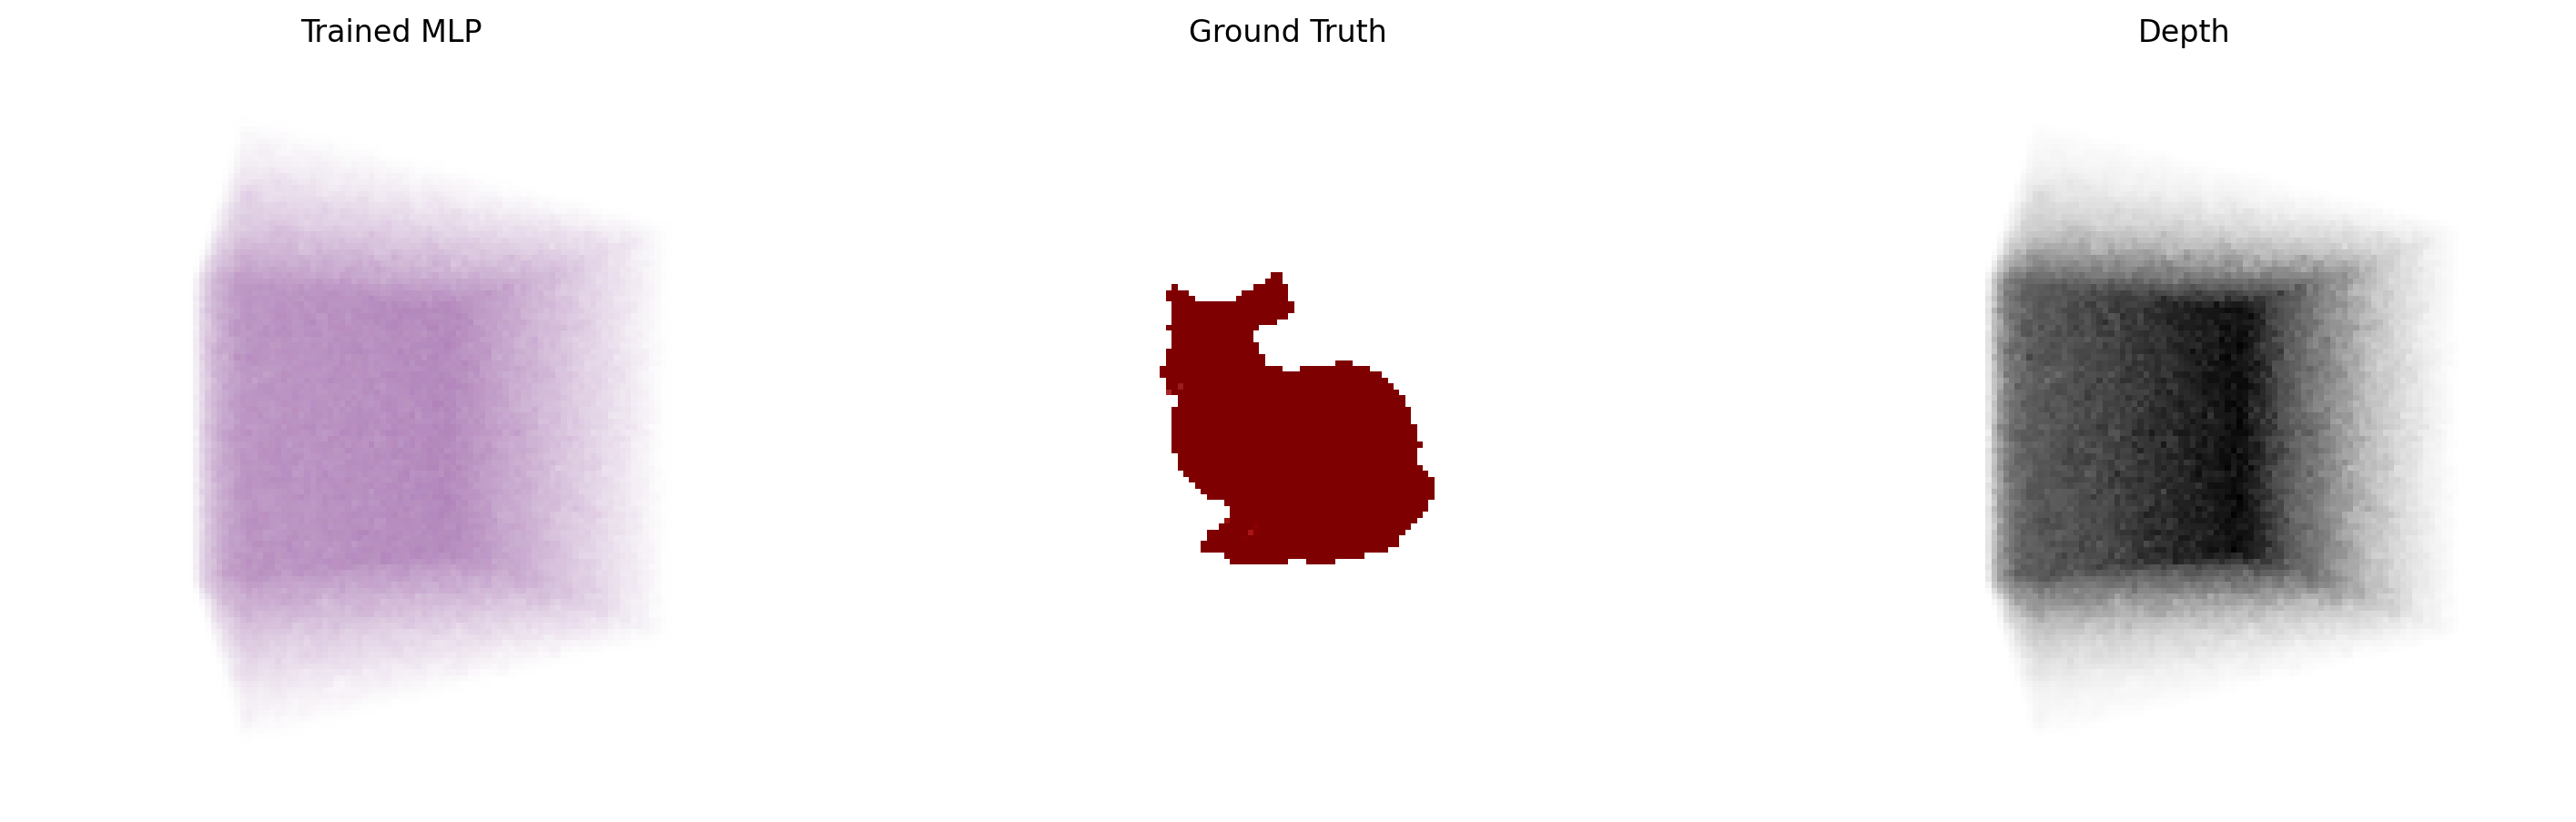

Step 100: loss = 0.01
torch.Size([1, 16384, 3])


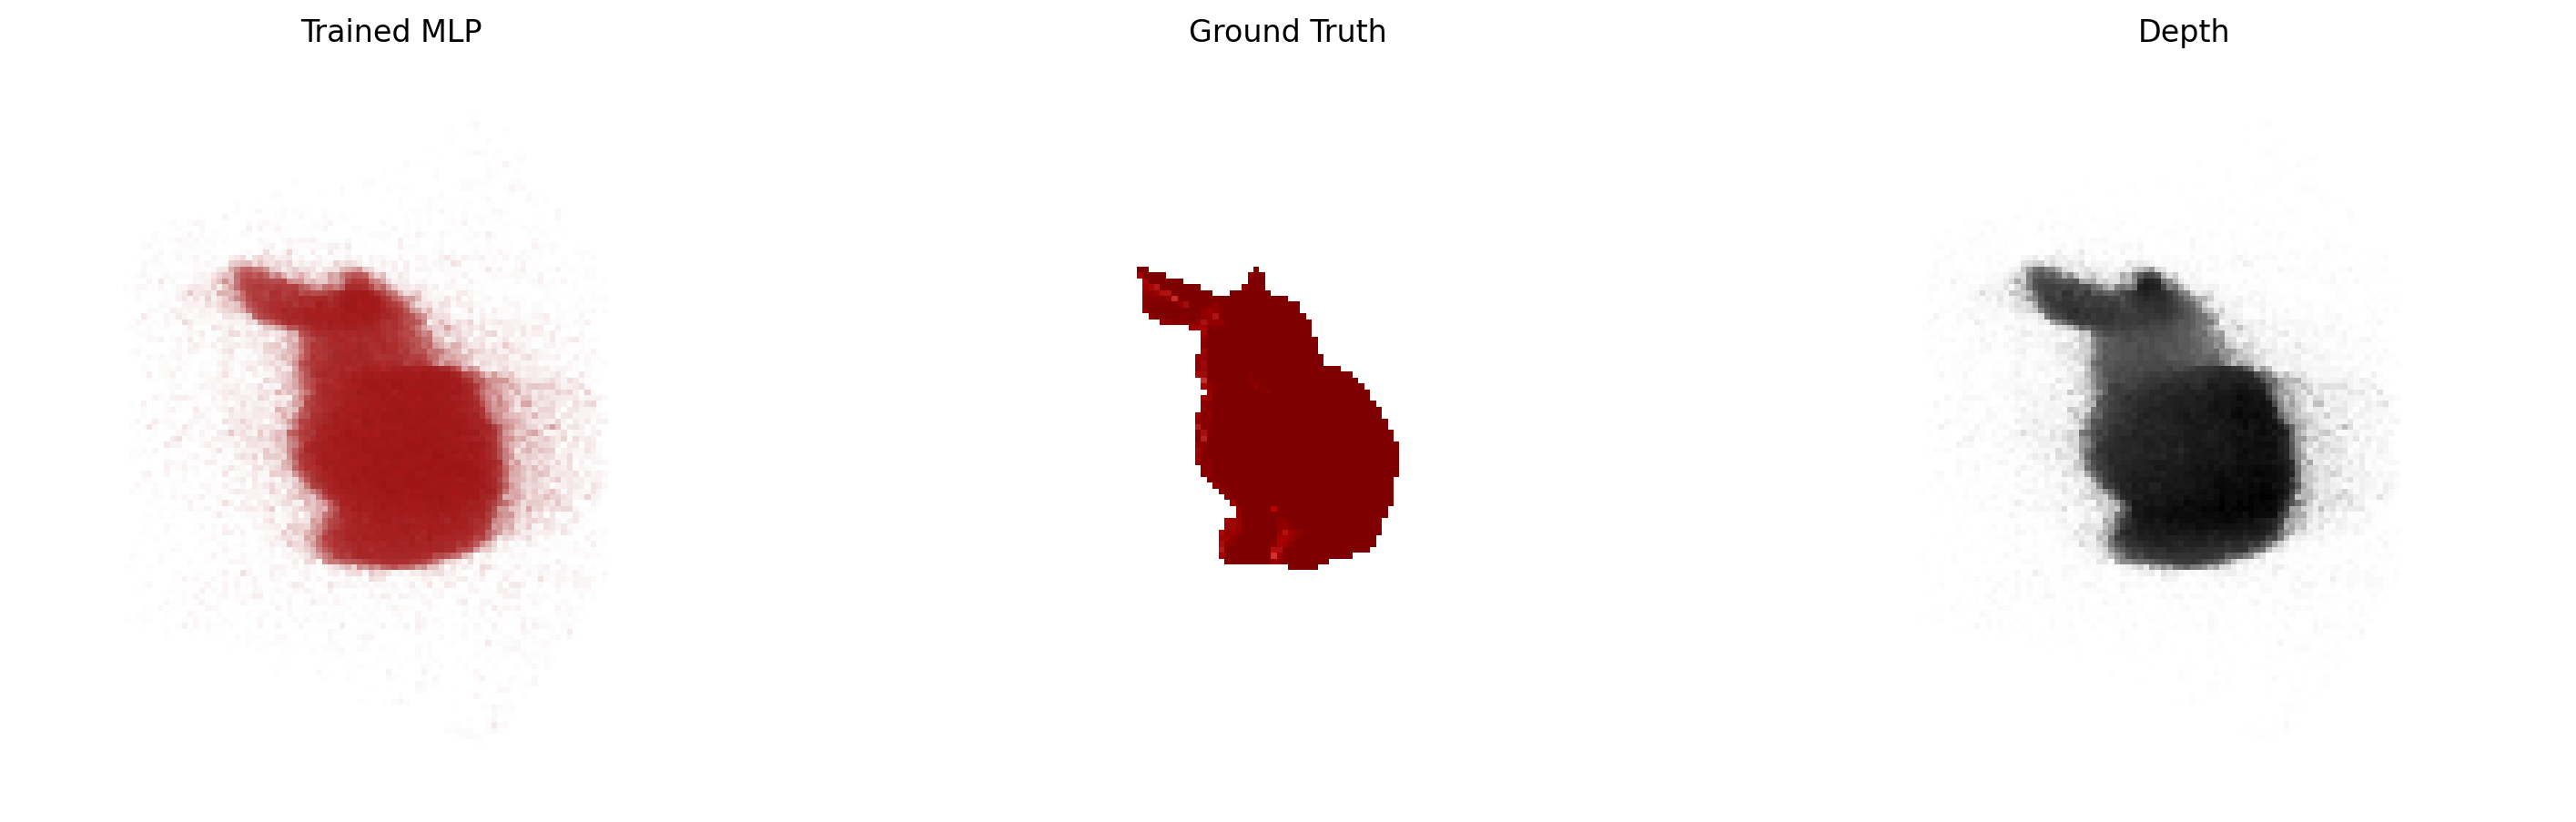

Step 200: loss = 0.00
torch.Size([1, 16384, 3])


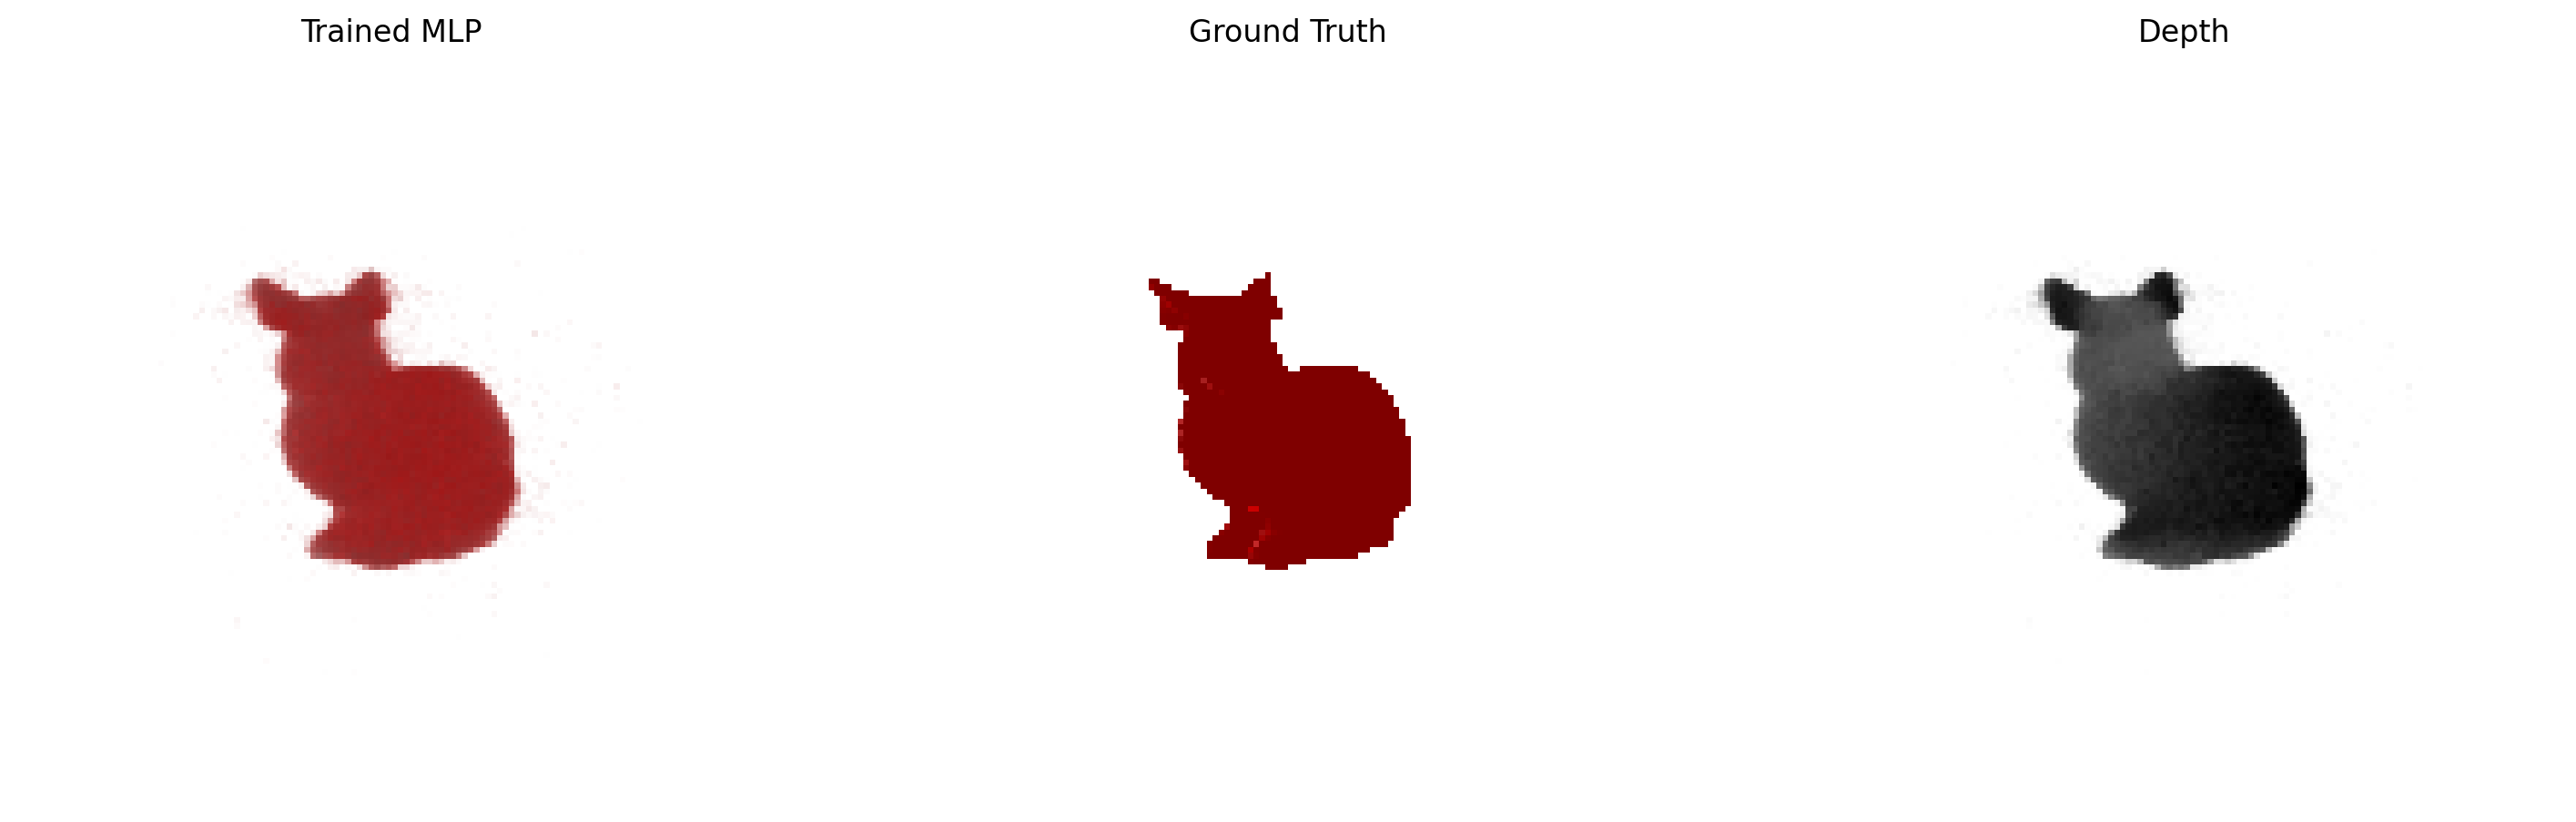

Step 300: loss = 0.00
torch.Size([1, 16384, 3])


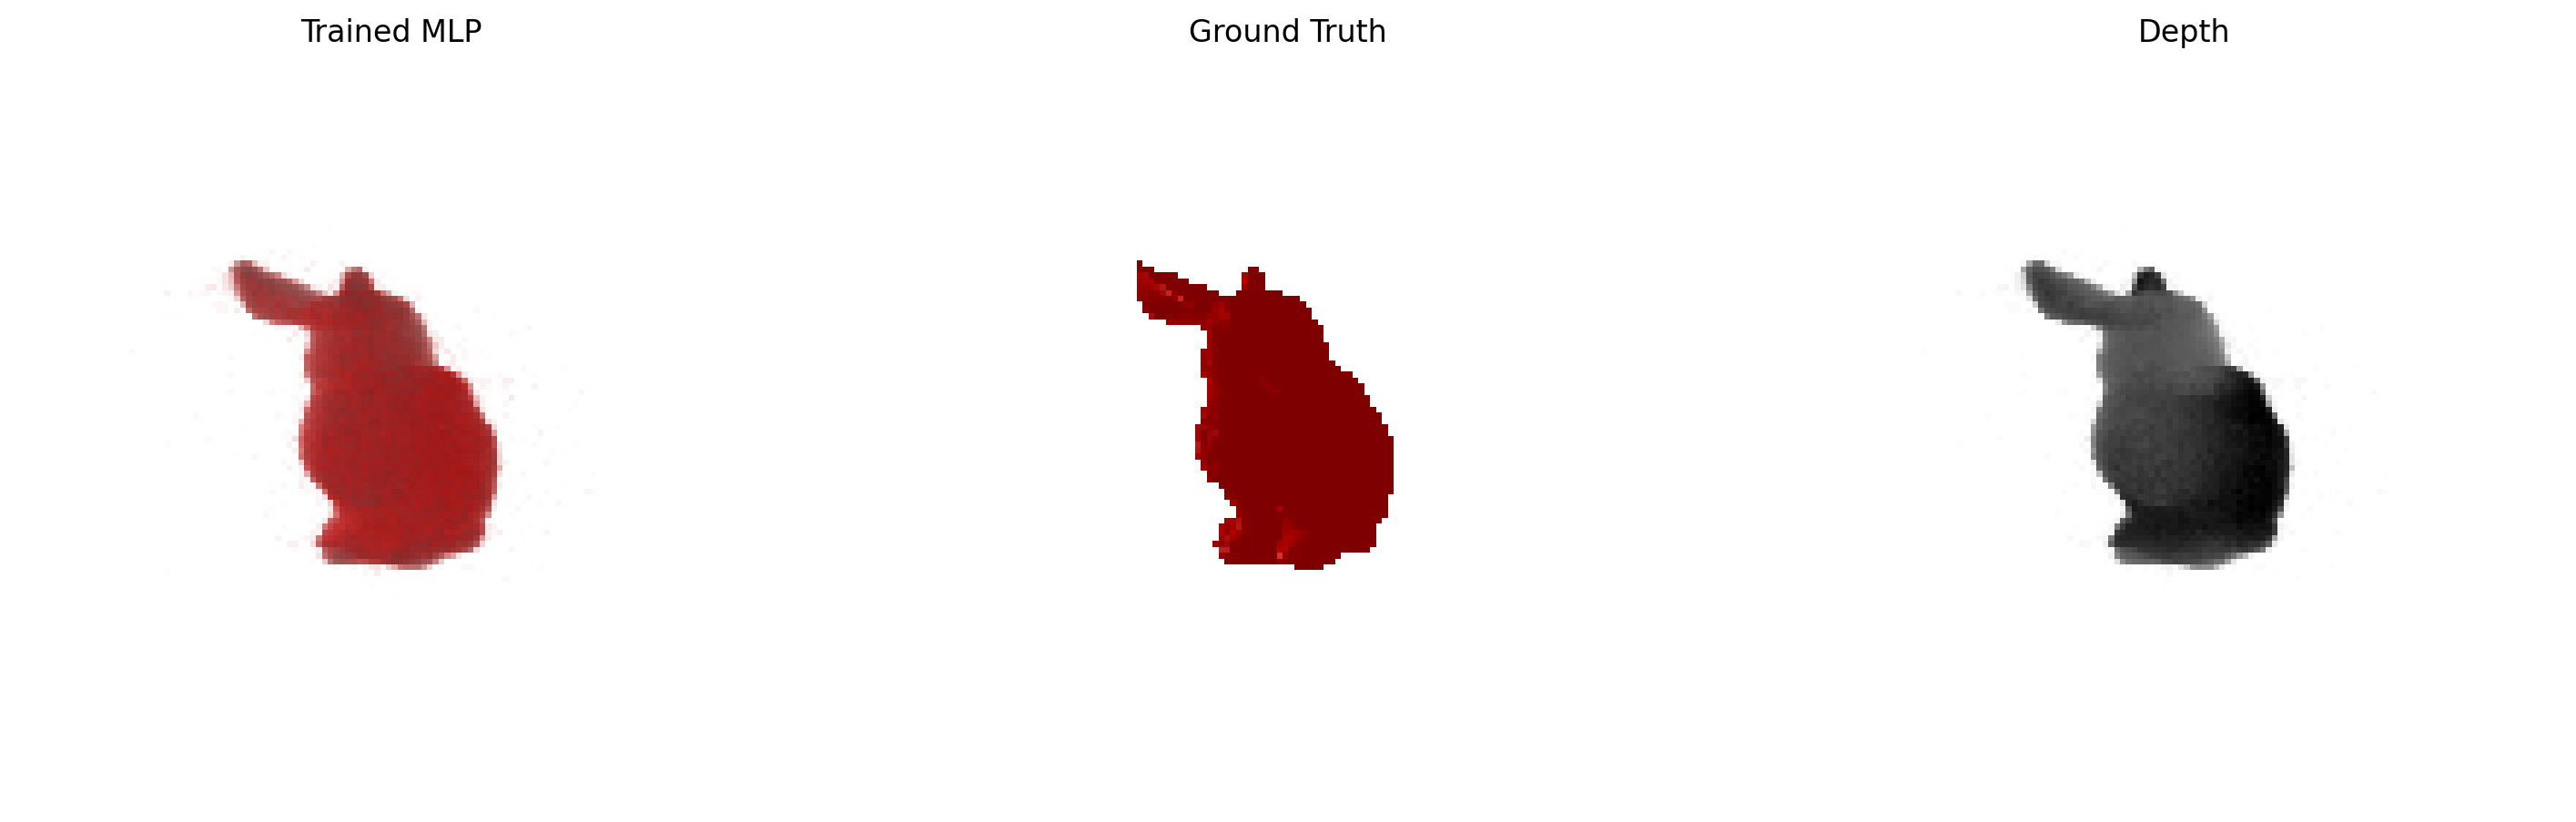

Step 400: loss = 0.00
torch.Size([1, 16384, 3])


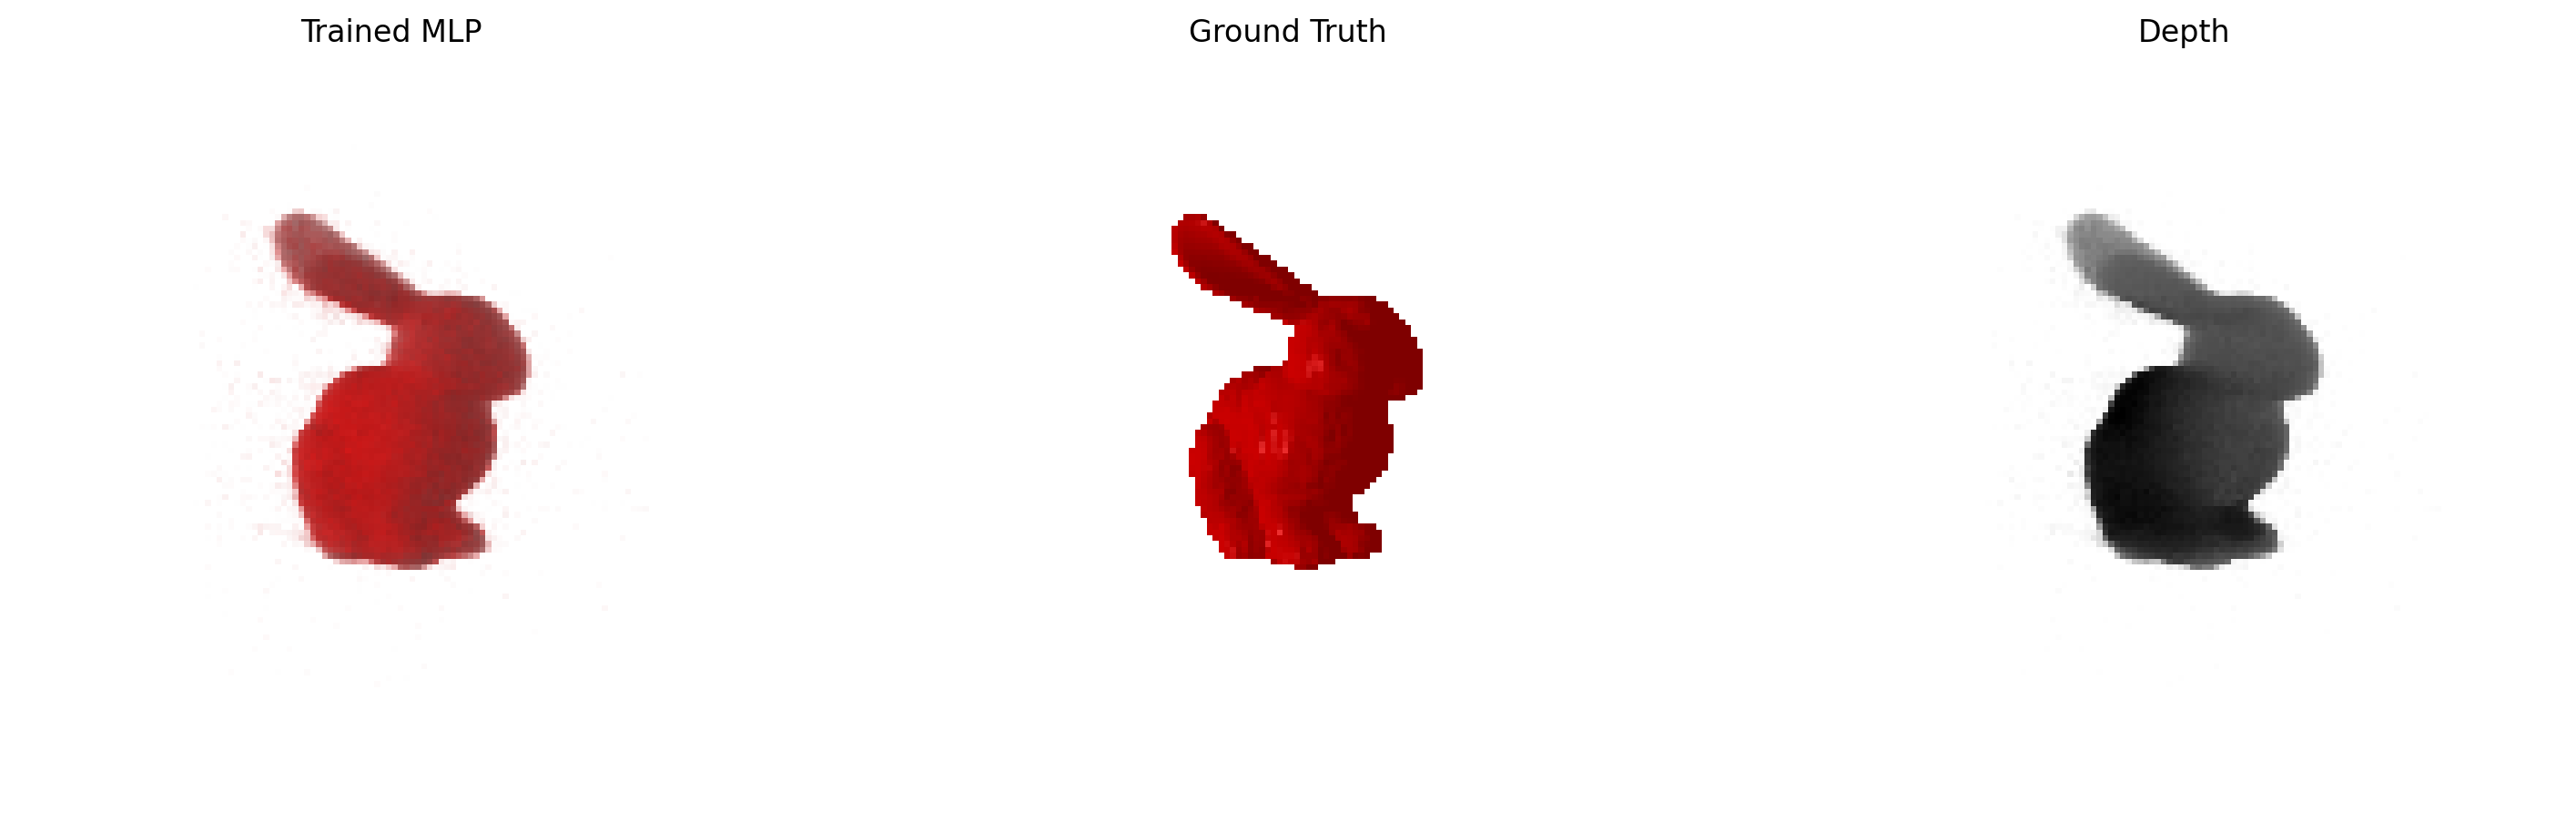

Step 500: loss = 0.00
torch.Size([1, 16384, 3])


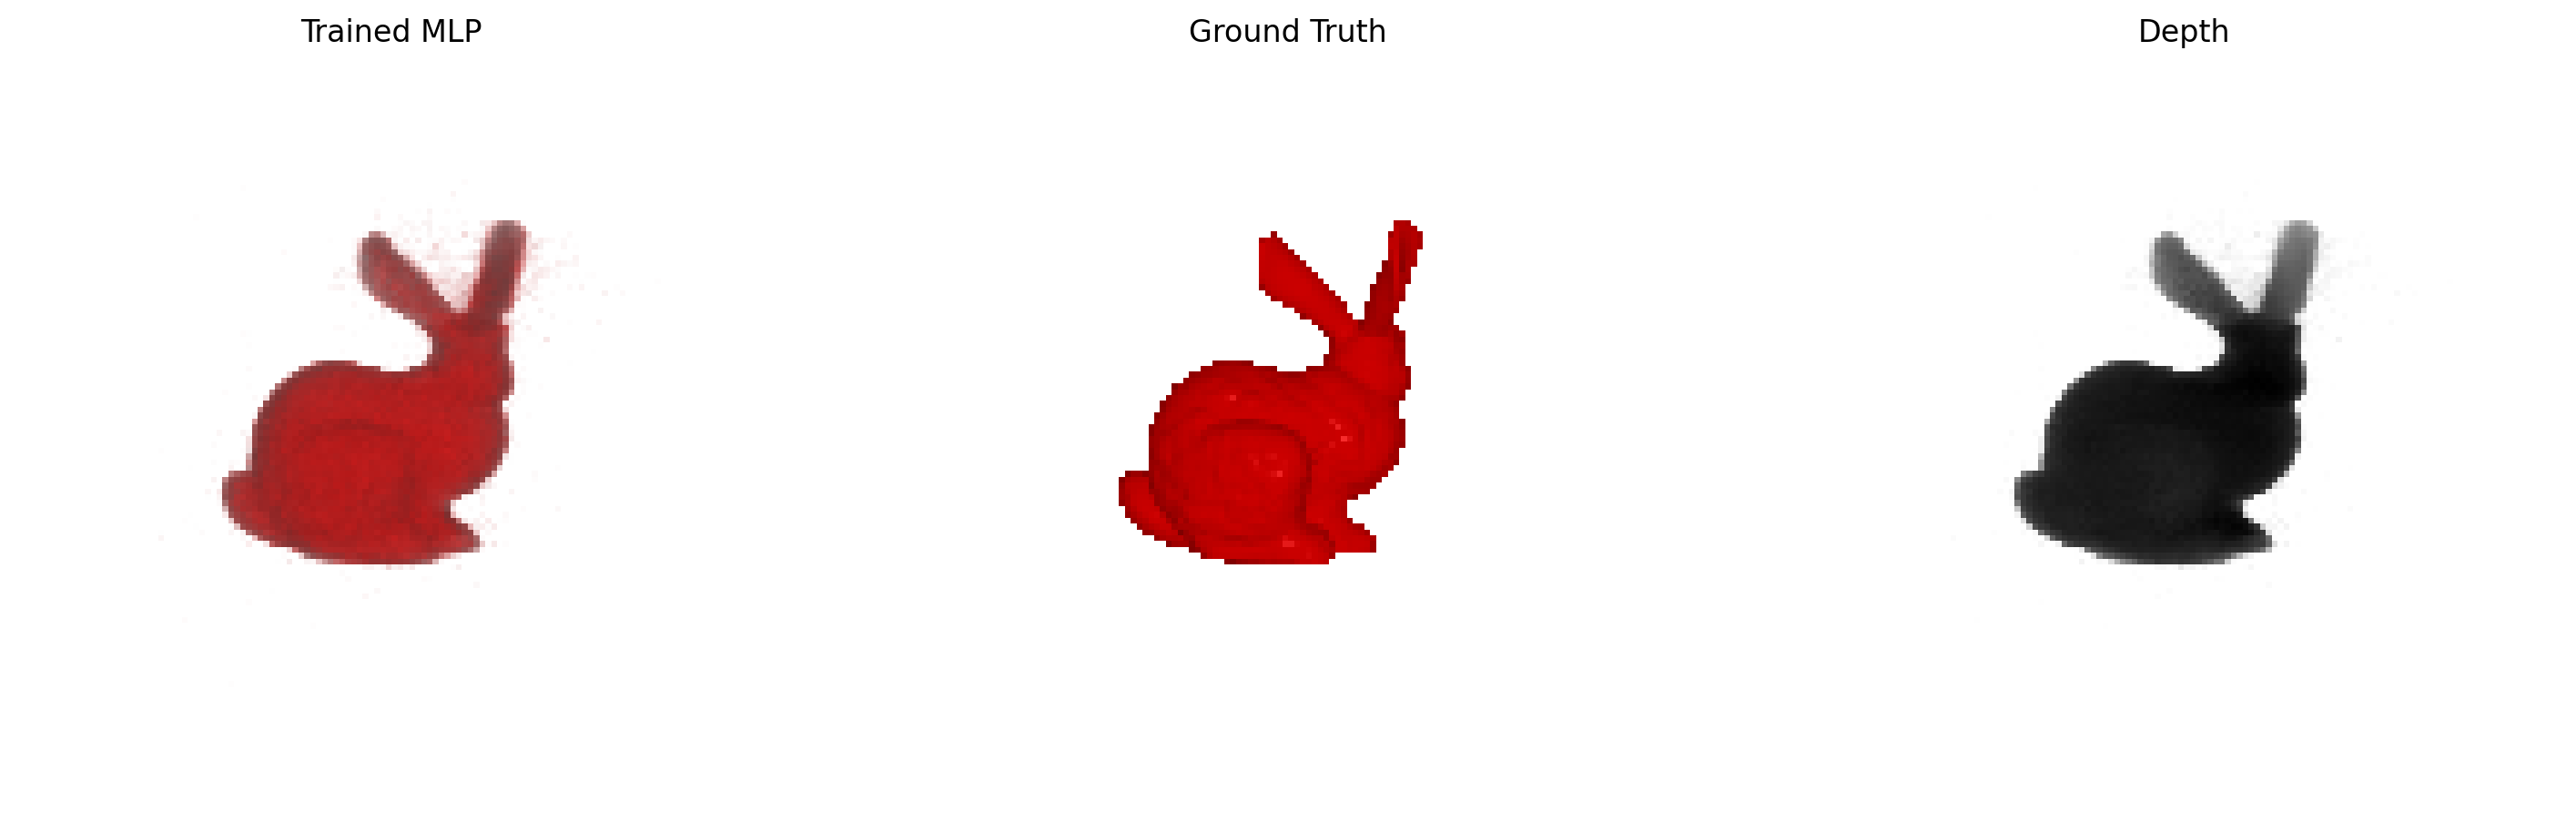

Step 600: loss = 0.00
torch.Size([1, 16384, 3])


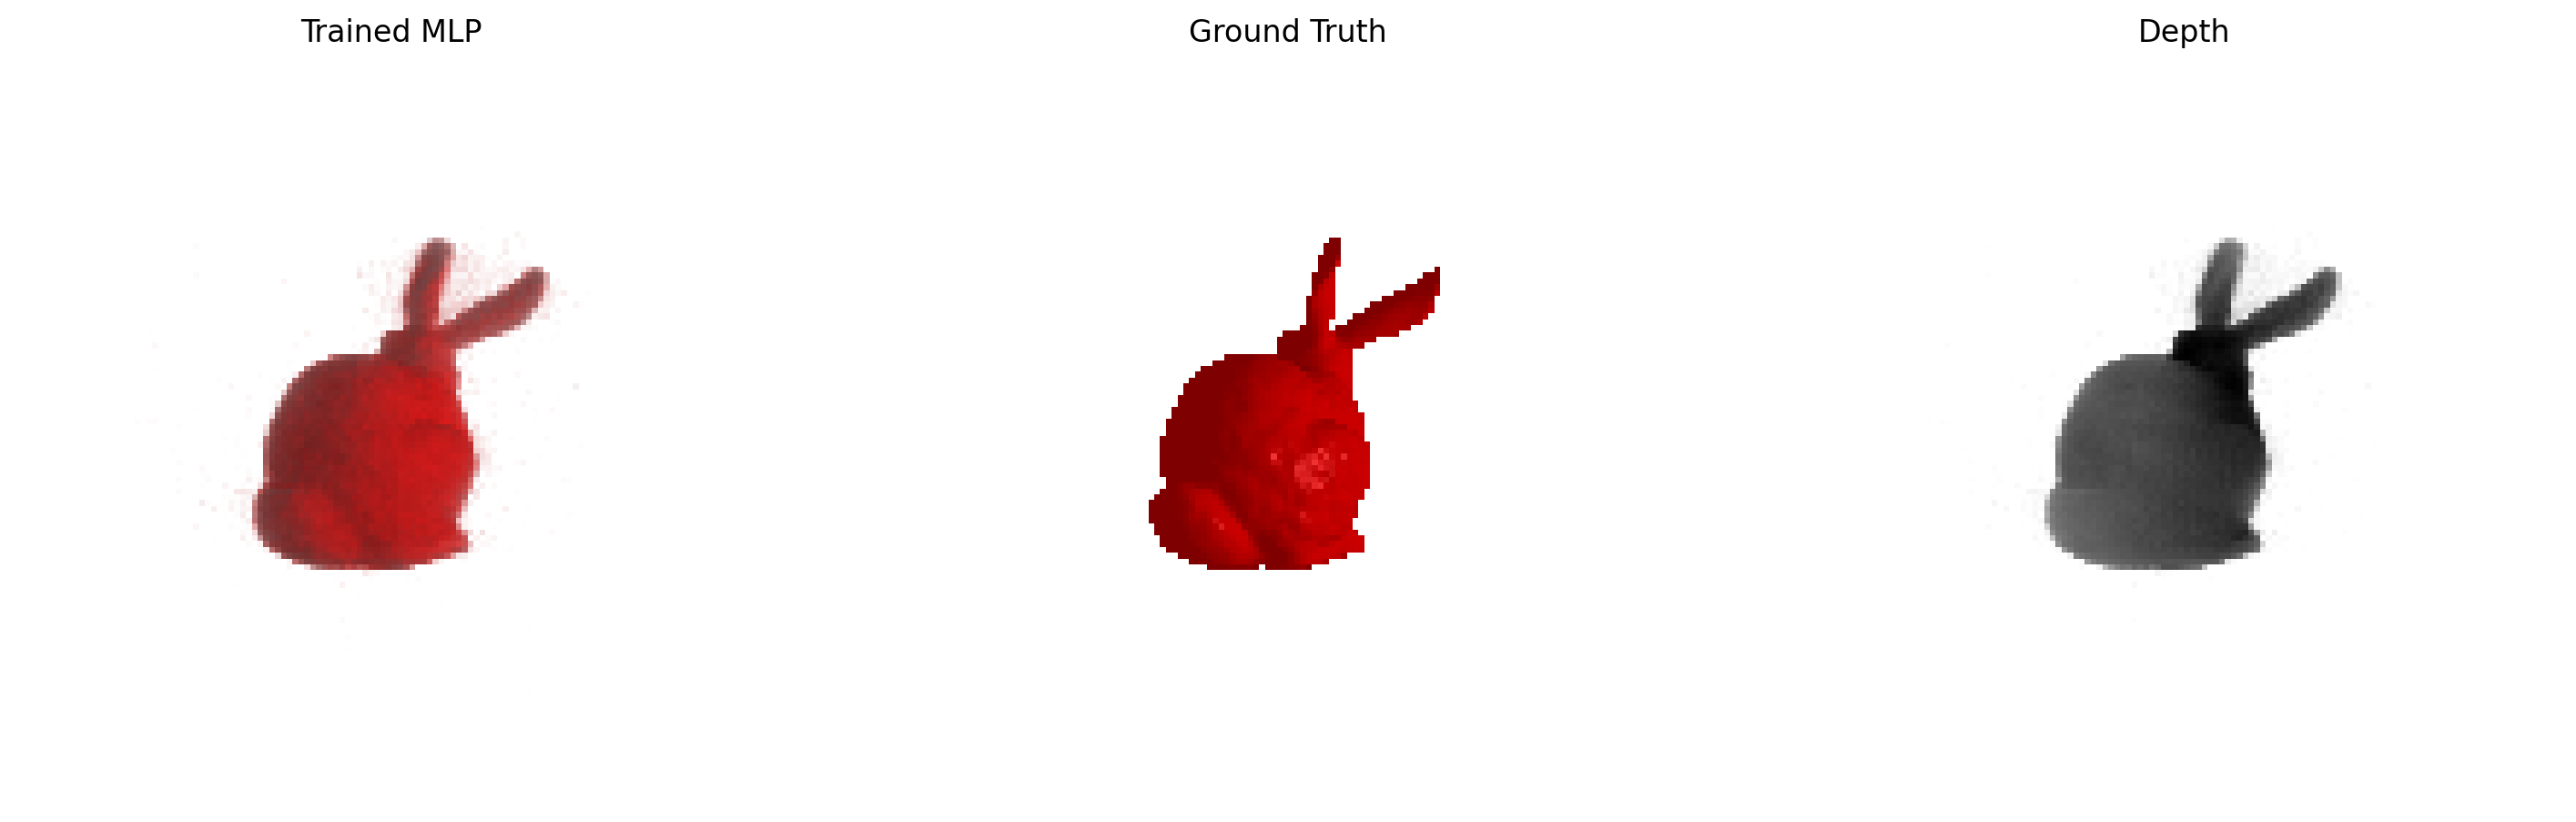

Step 700: loss = 0.00
torch.Size([1, 16384, 3])


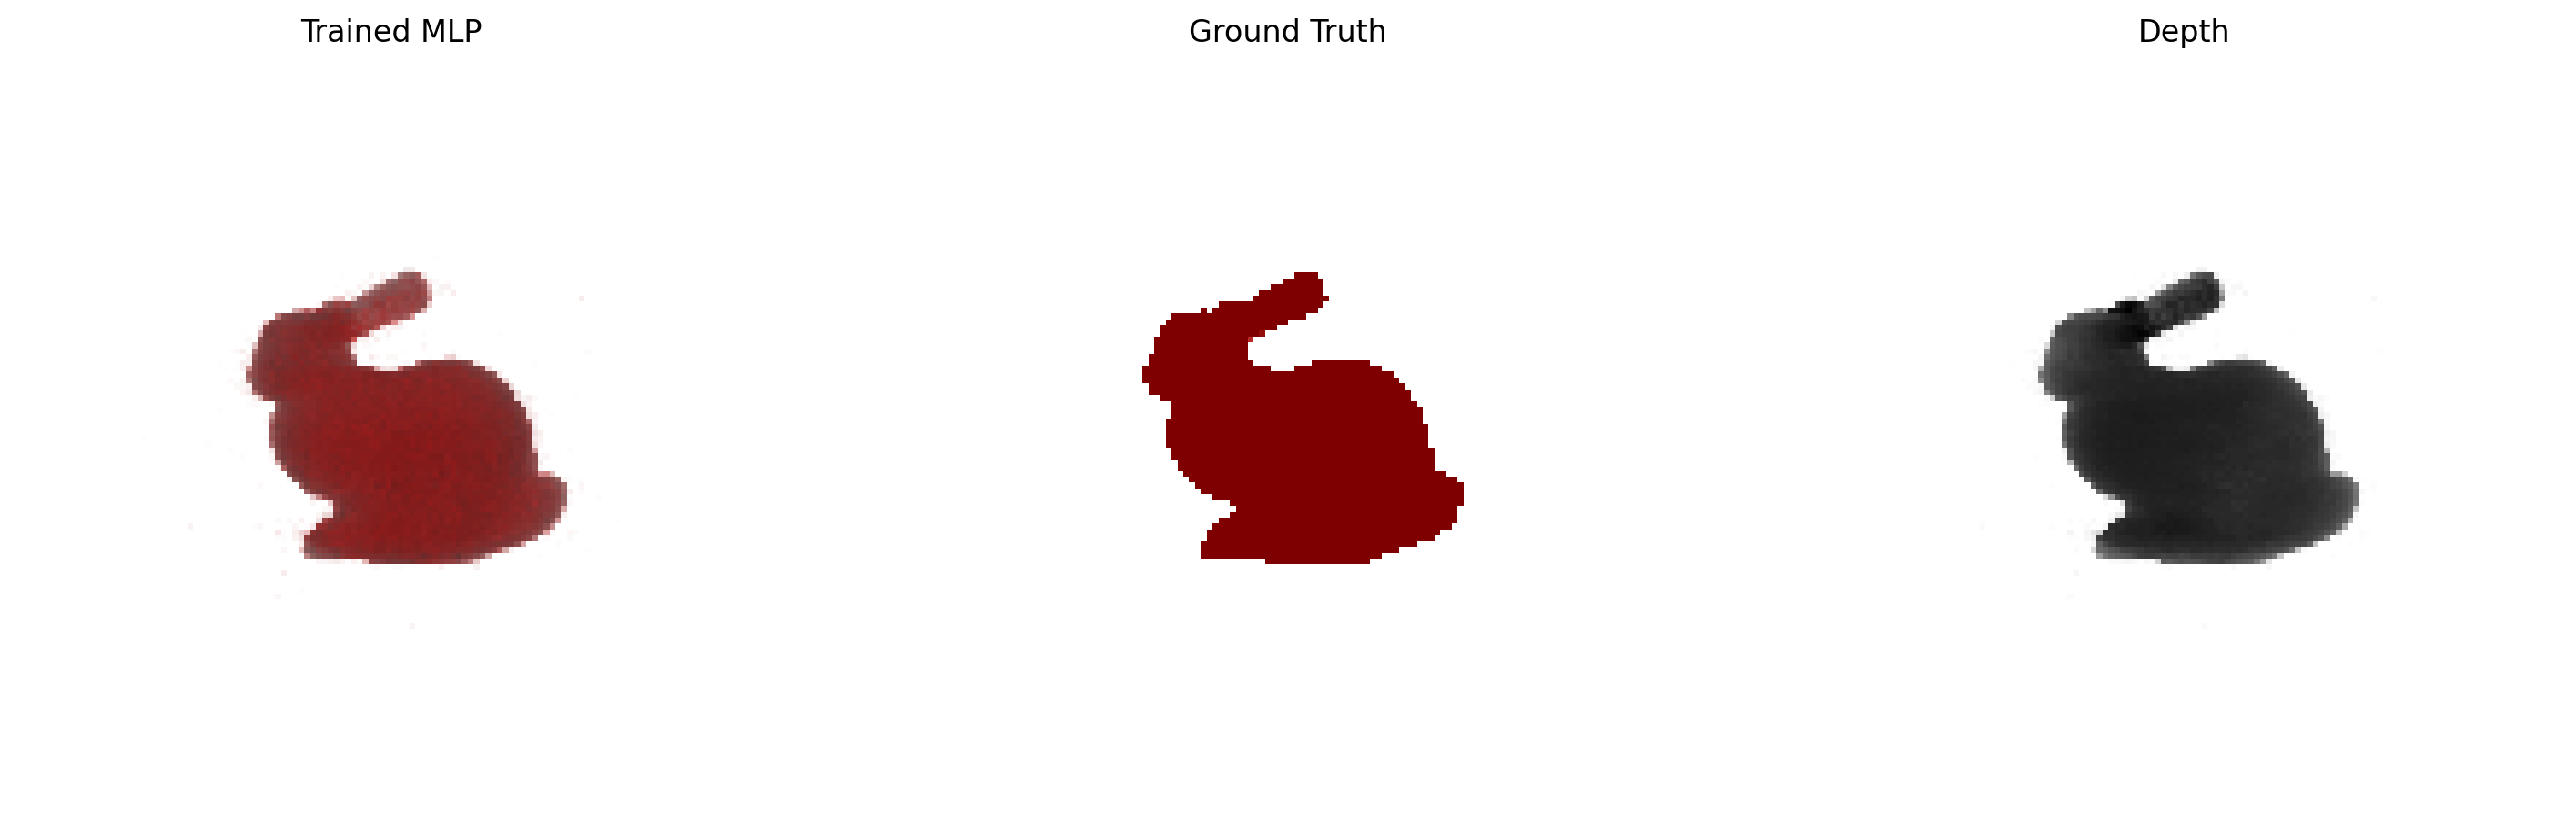

Step 800: loss = 0.00
torch.Size([1, 16384, 3])


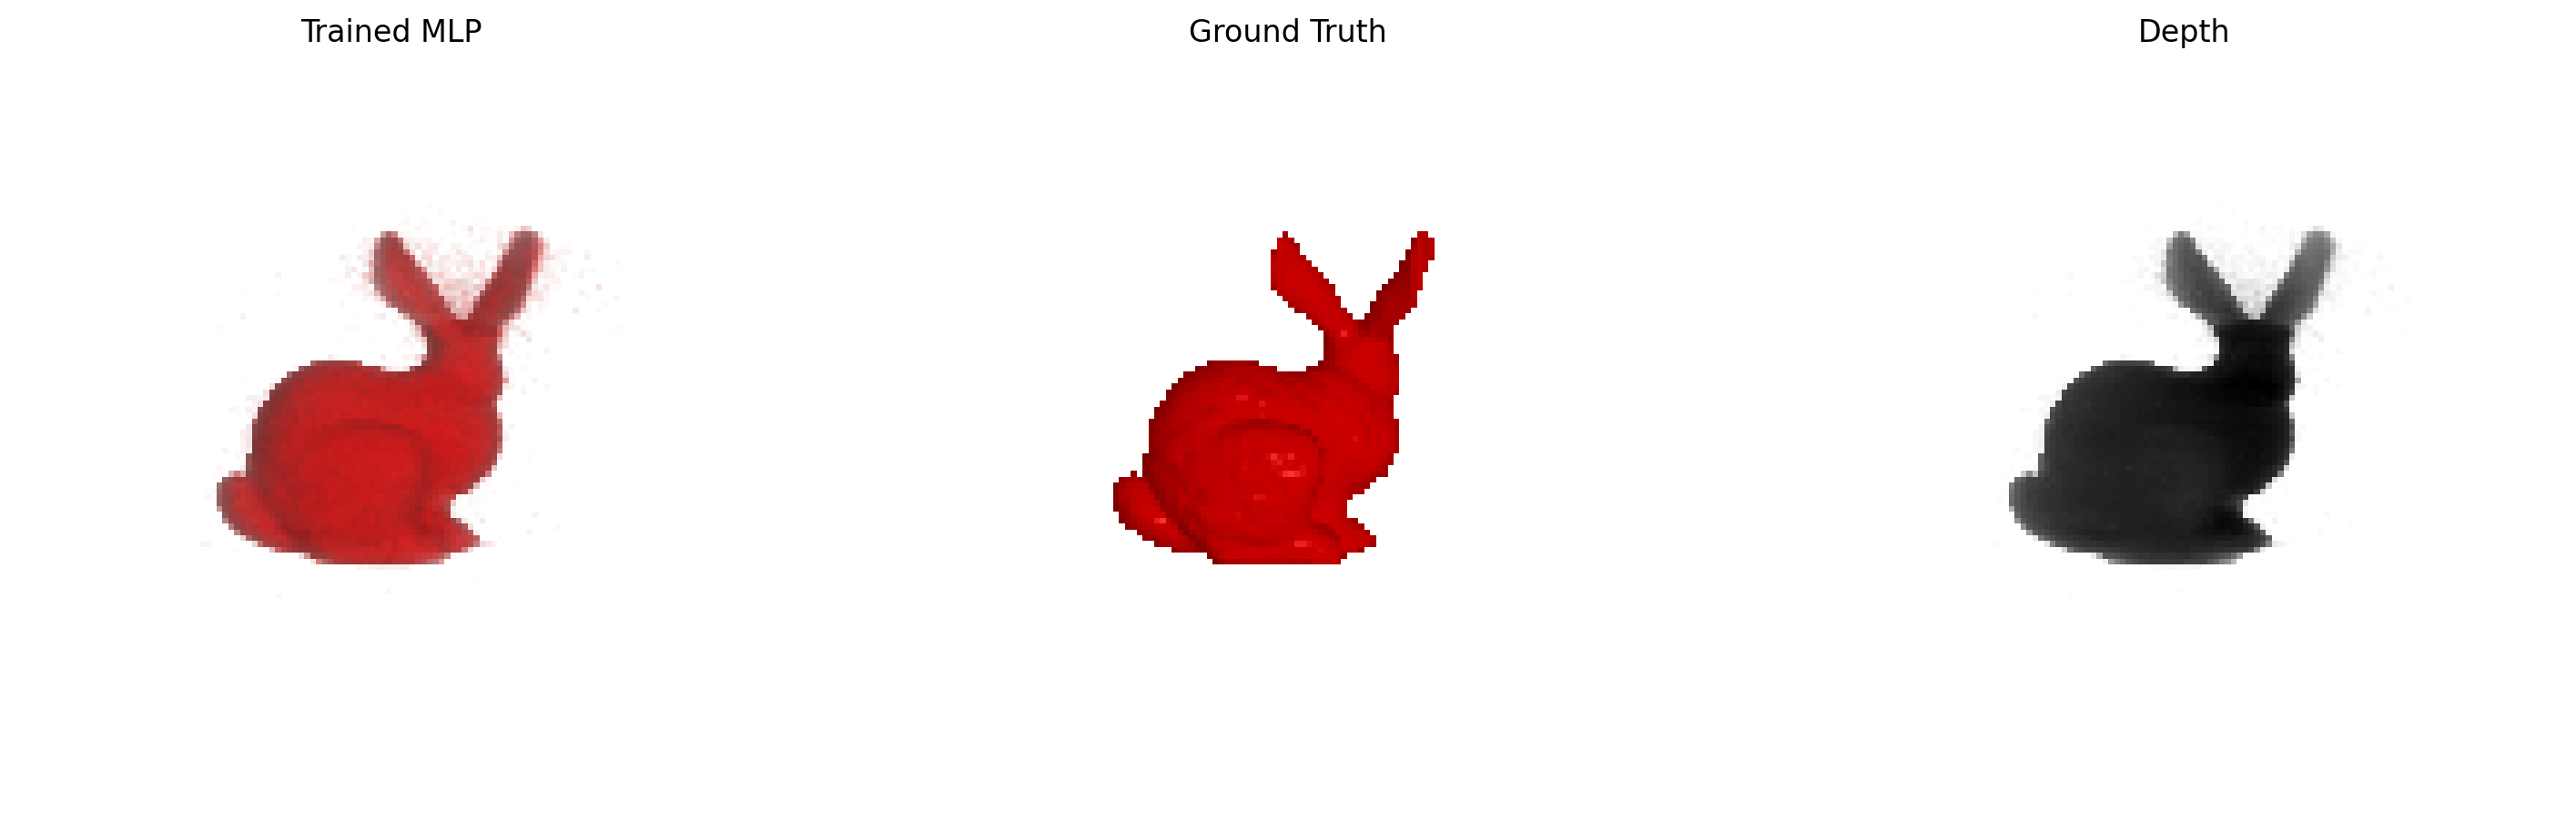

Step 900: loss = 0.00
torch.Size([1, 16384, 3])


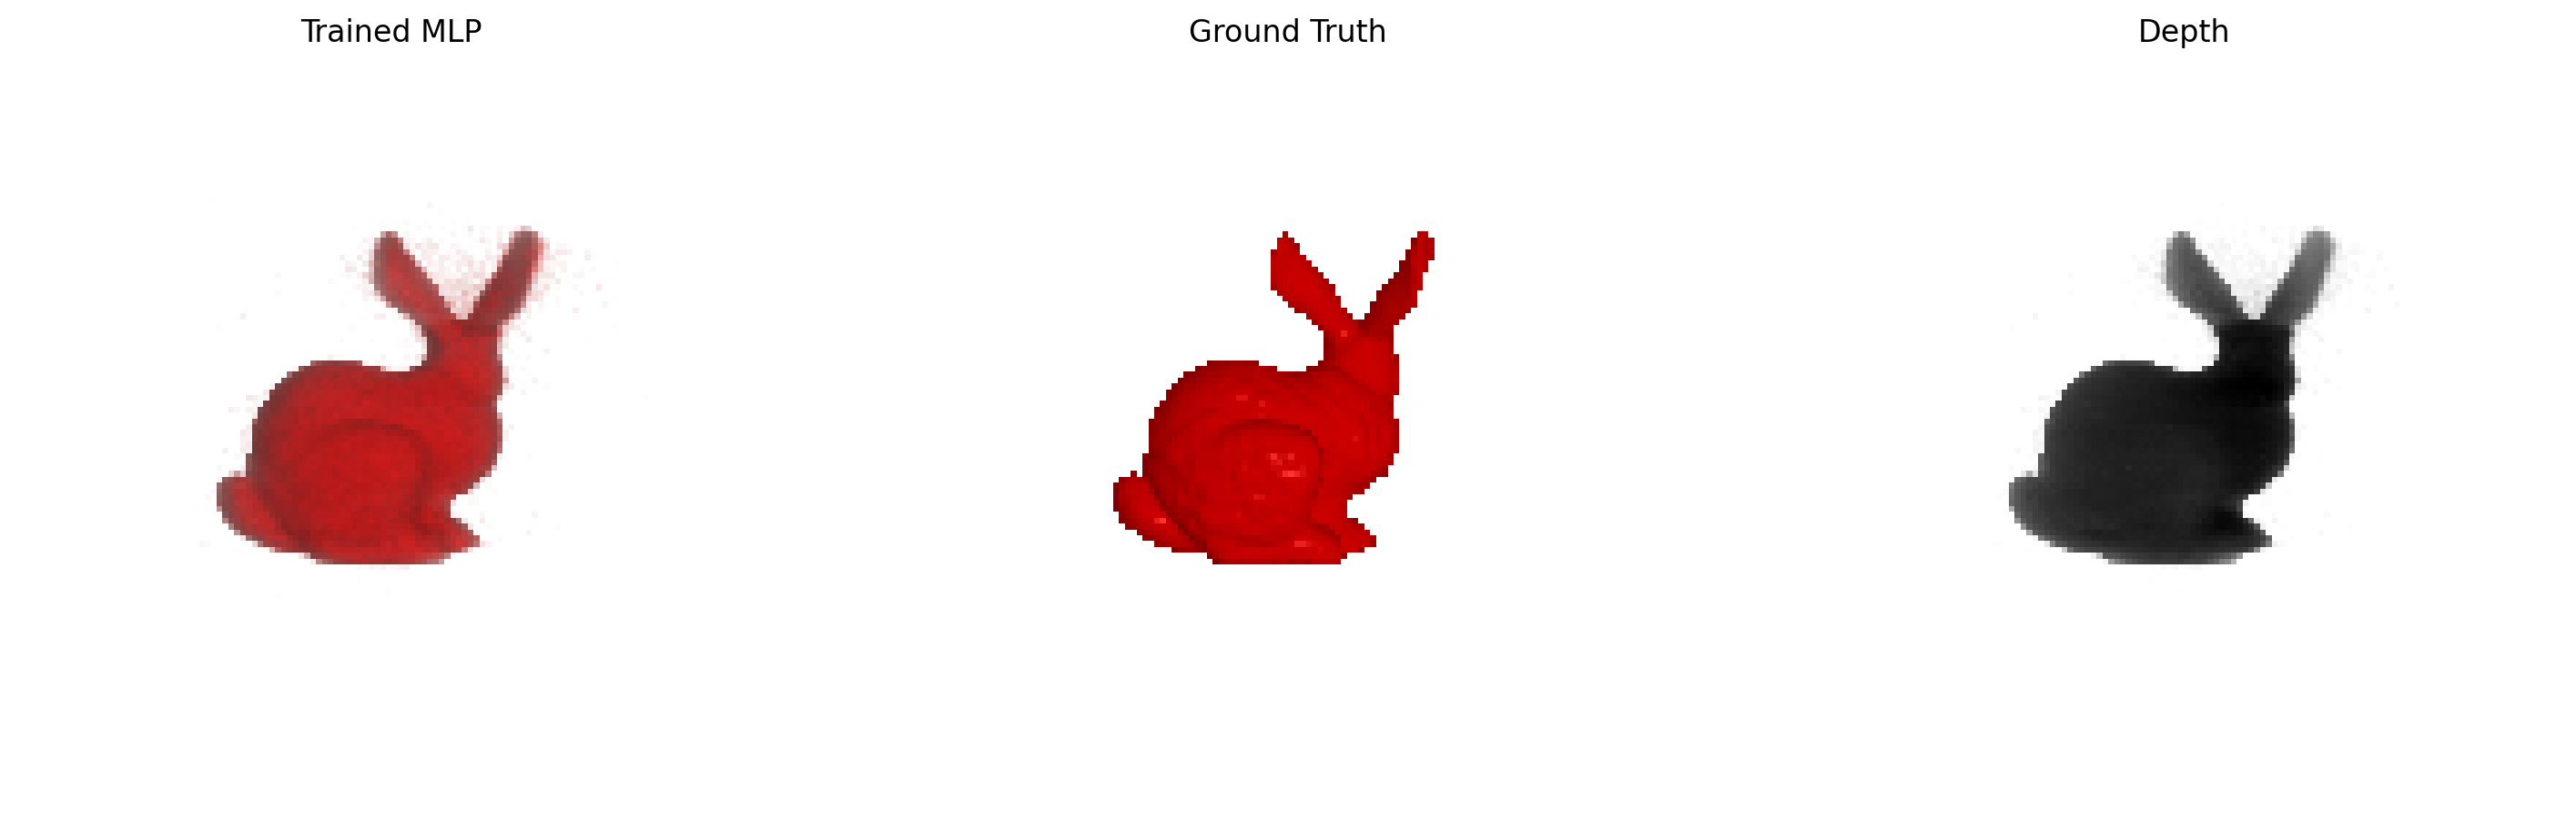

Step 1000: loss = 0.00
torch.Size([1, 16384, 3])


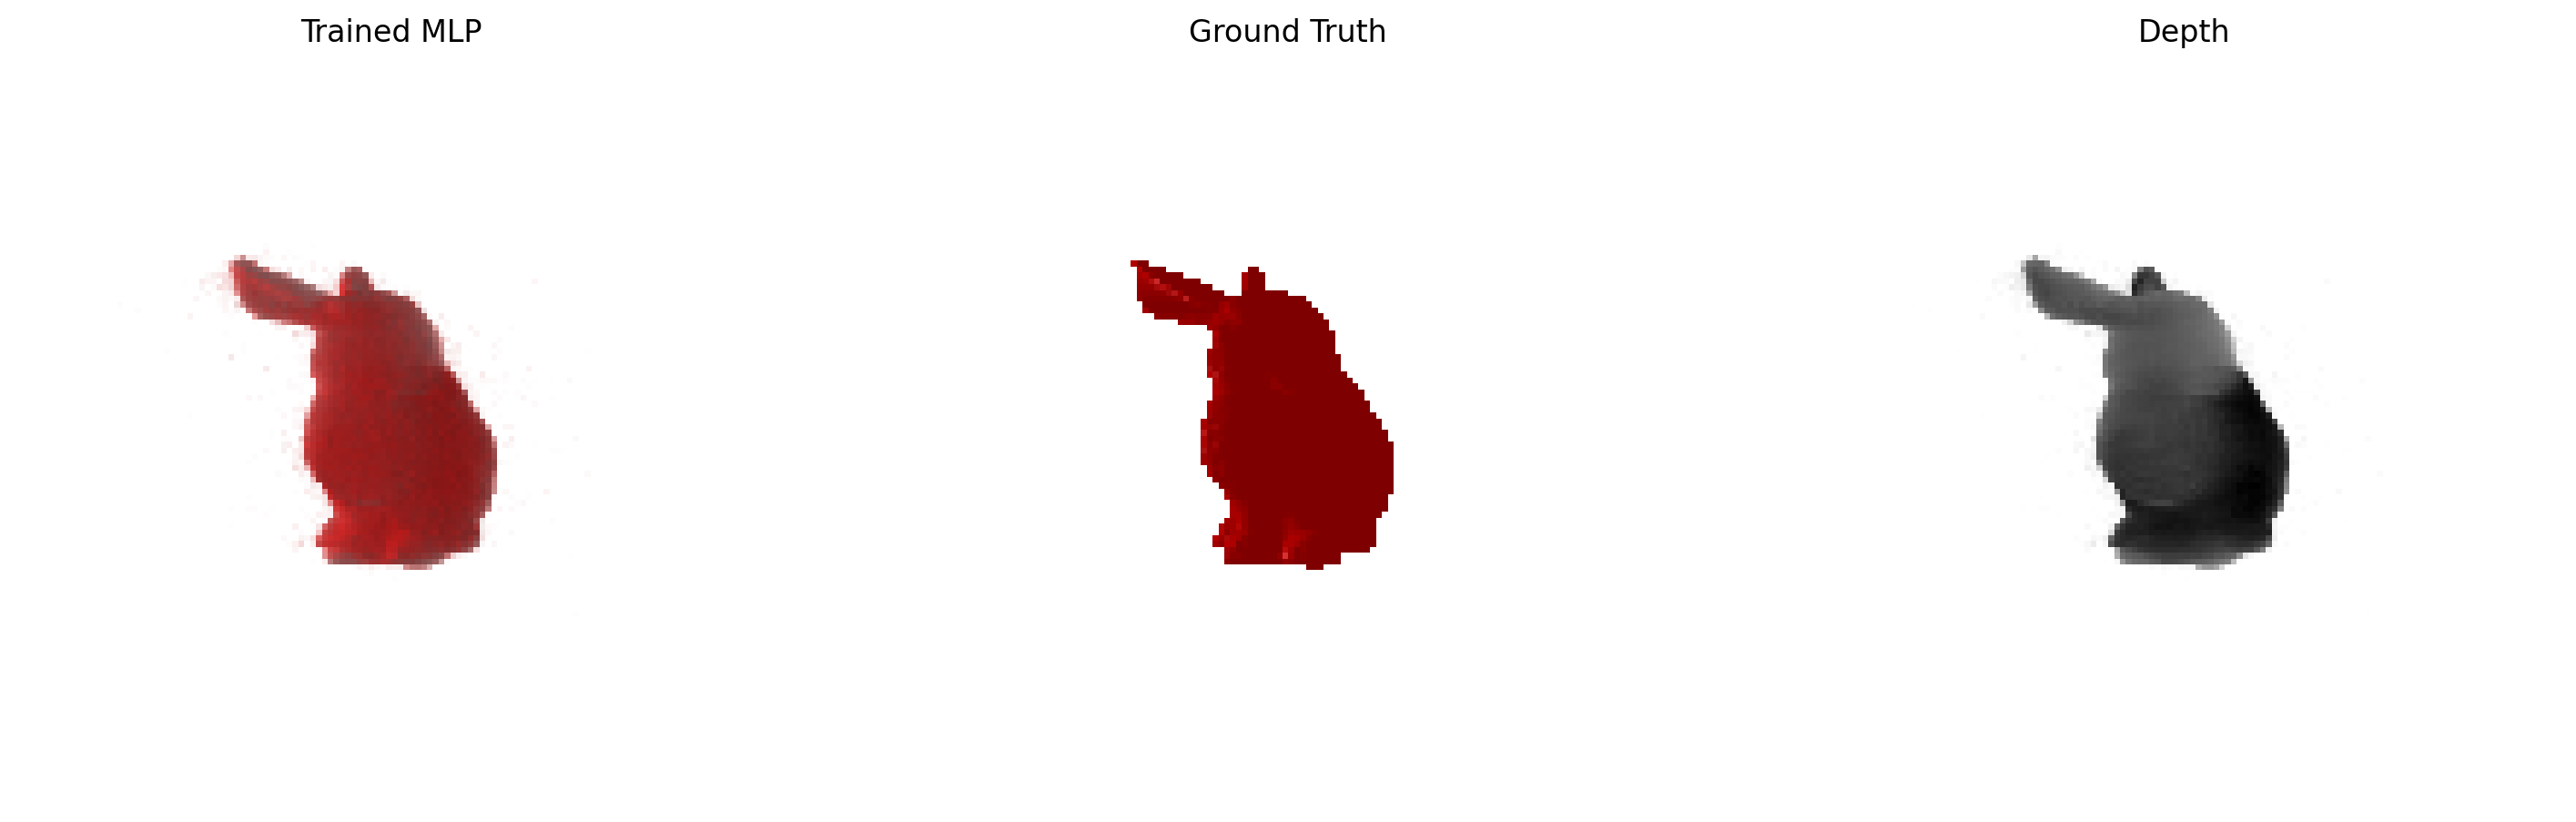

Step 1100: loss = 0.00
torch.Size([1, 16384, 3])


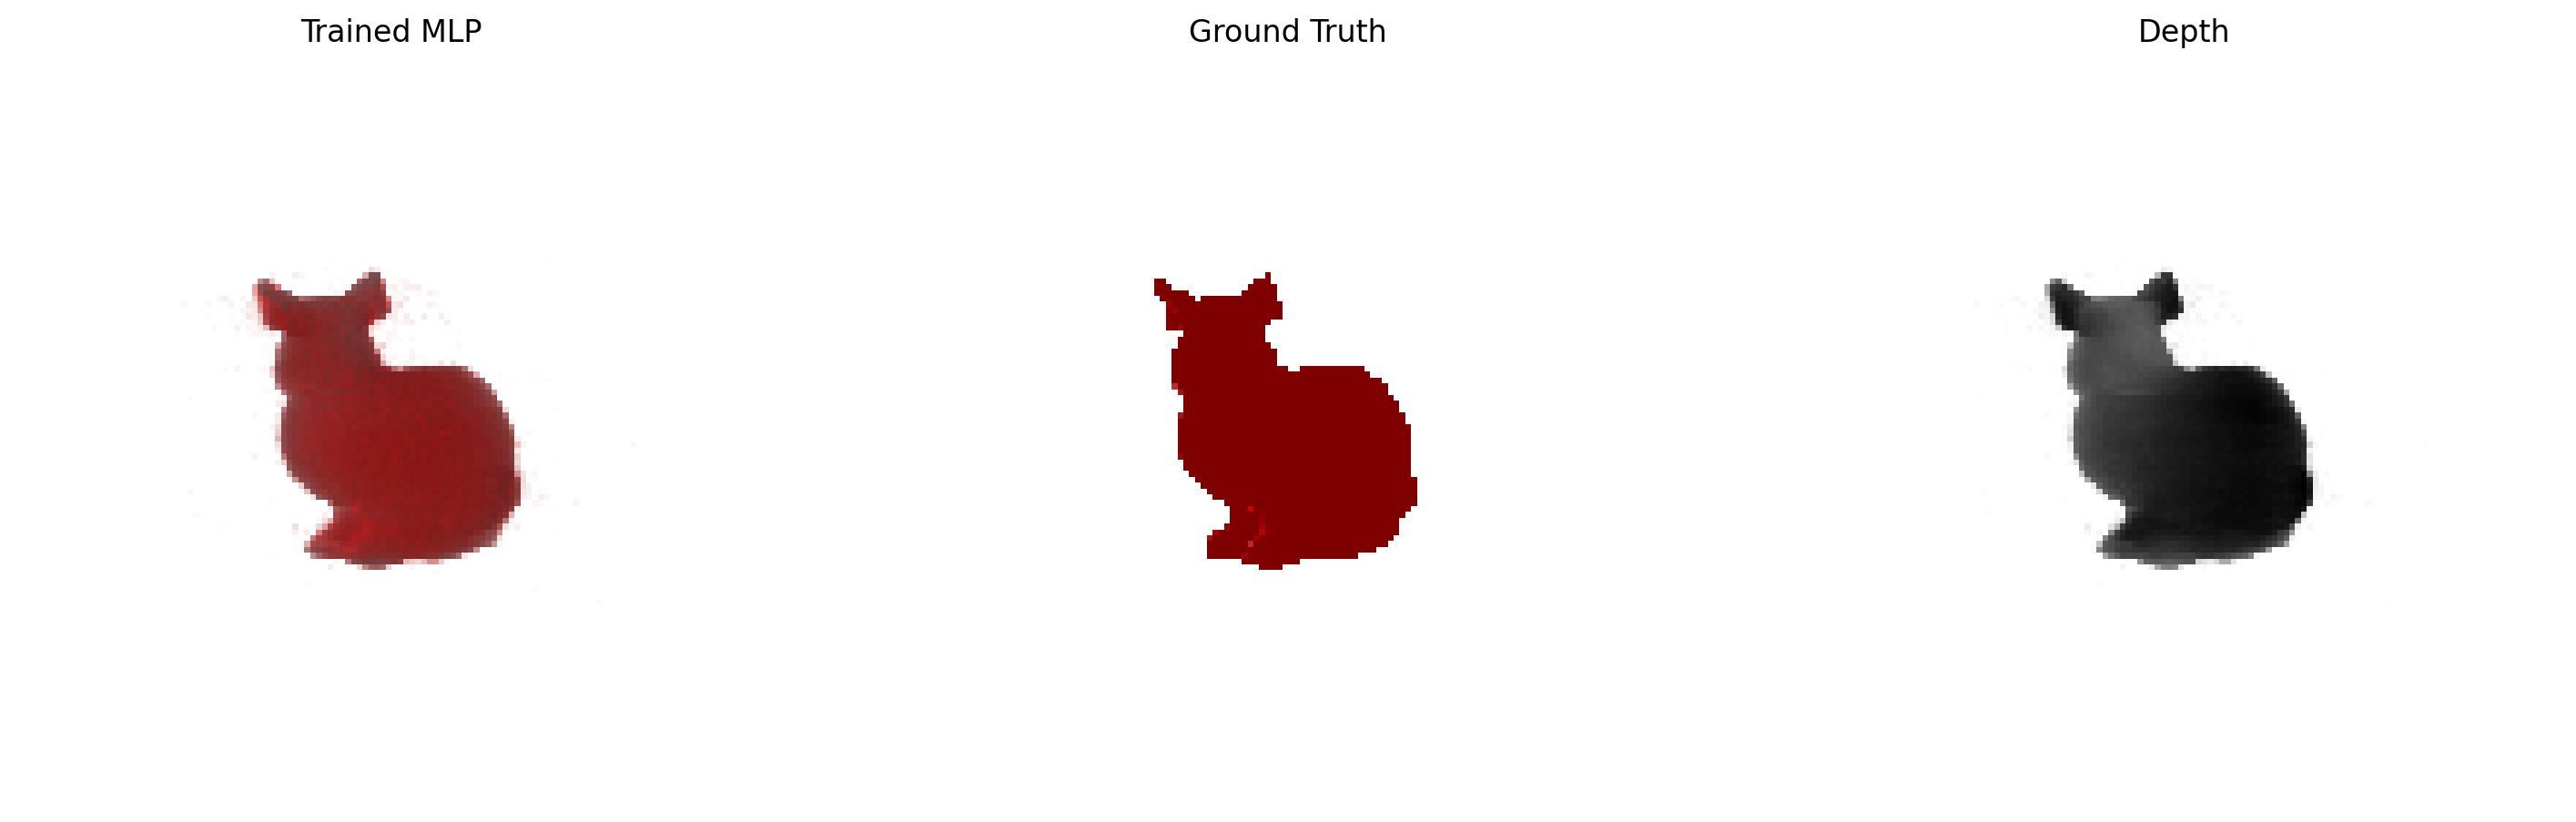

Step 1200: loss = 0.00
torch.Size([1, 16384, 3])


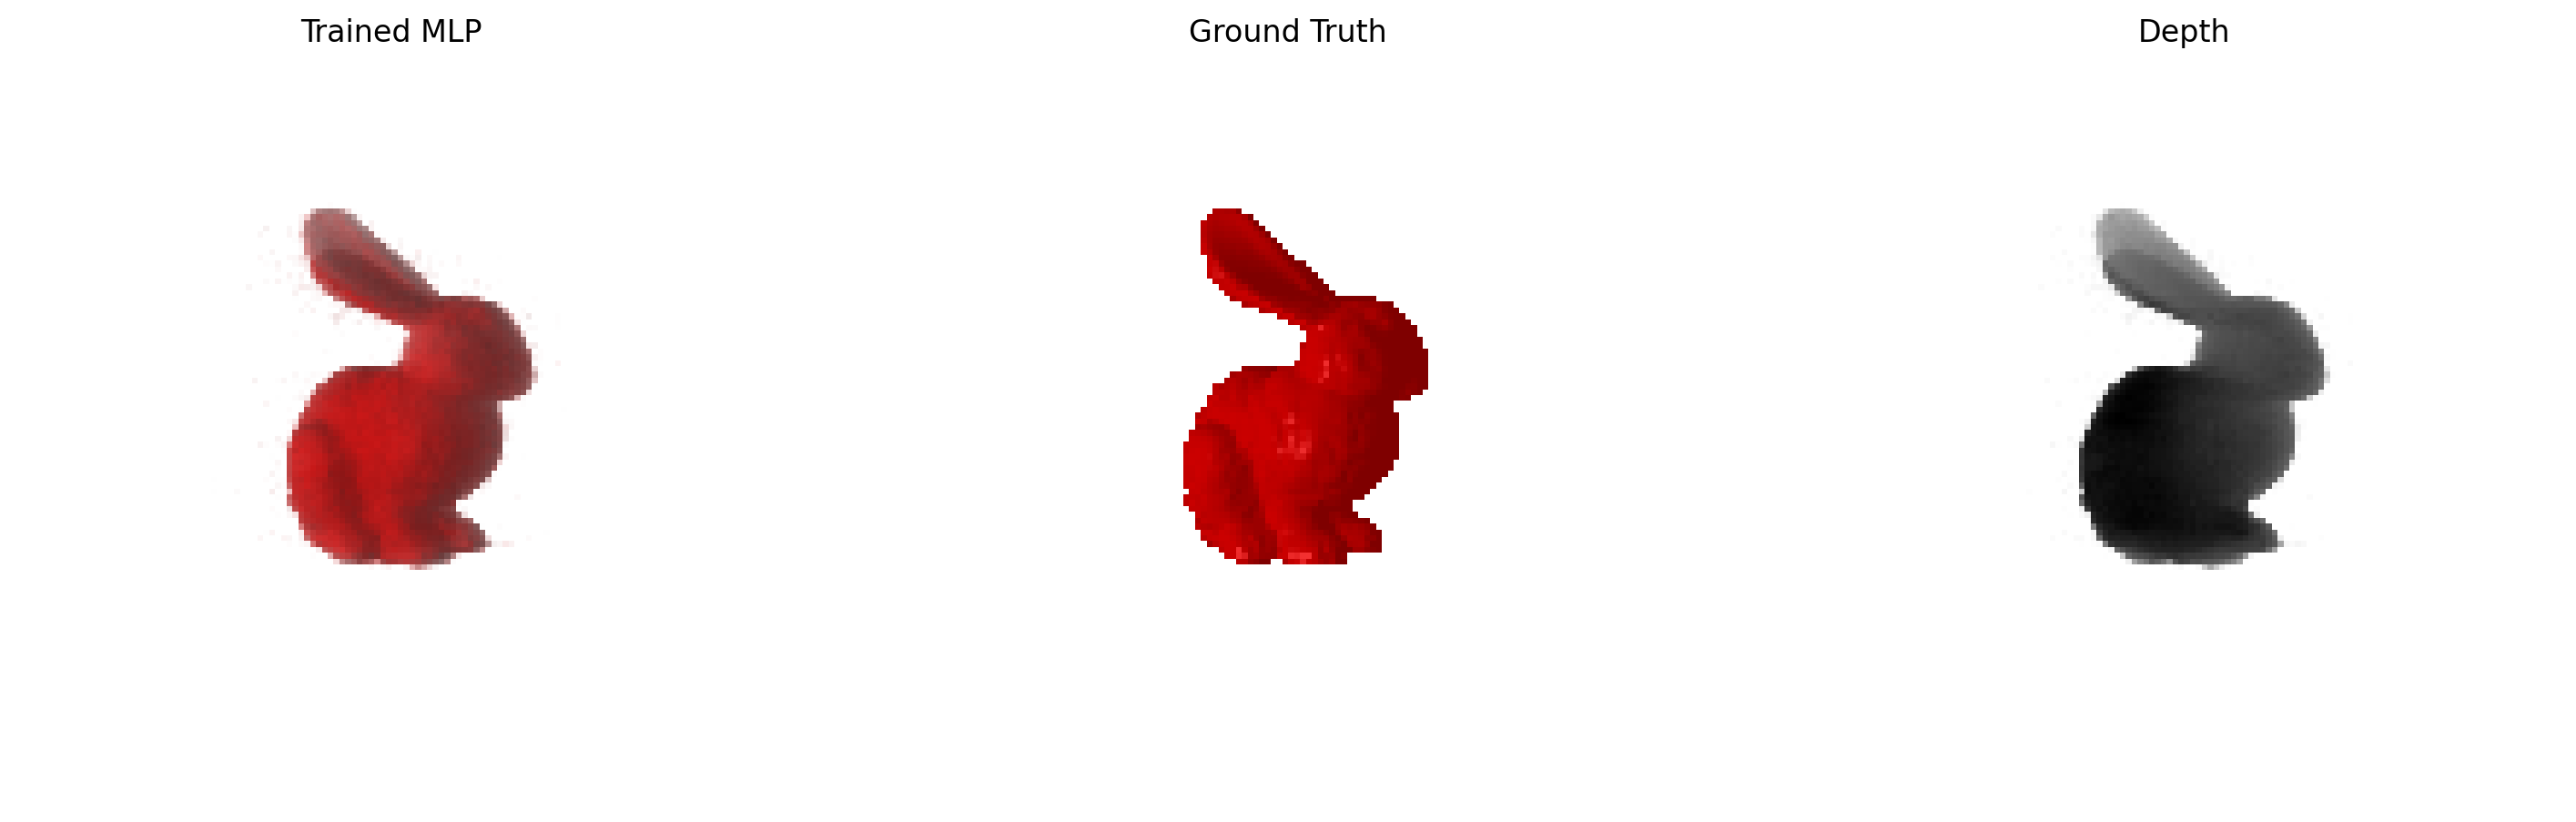

Step 1300: loss = 0.00
torch.Size([1, 16384, 3])


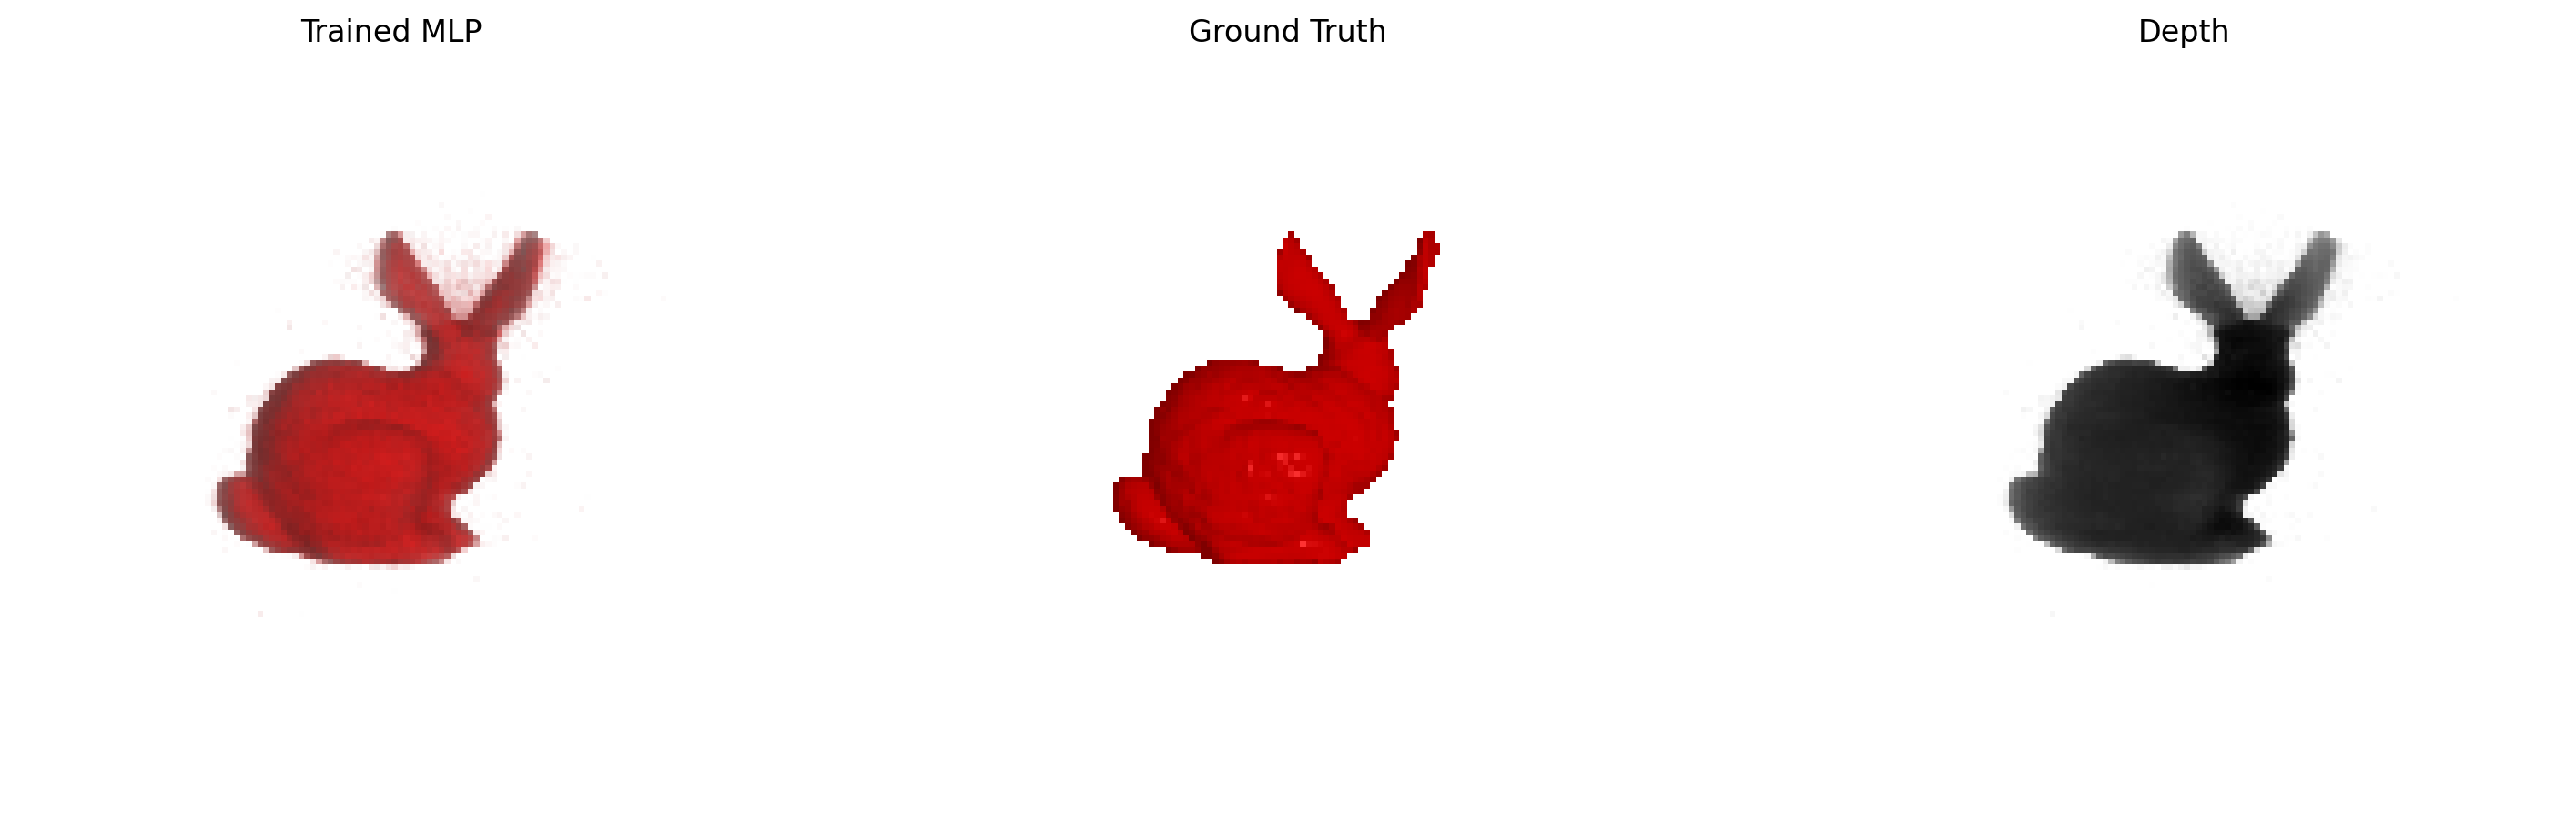

Step 1400: loss = 0.00
torch.Size([1, 16384, 3])


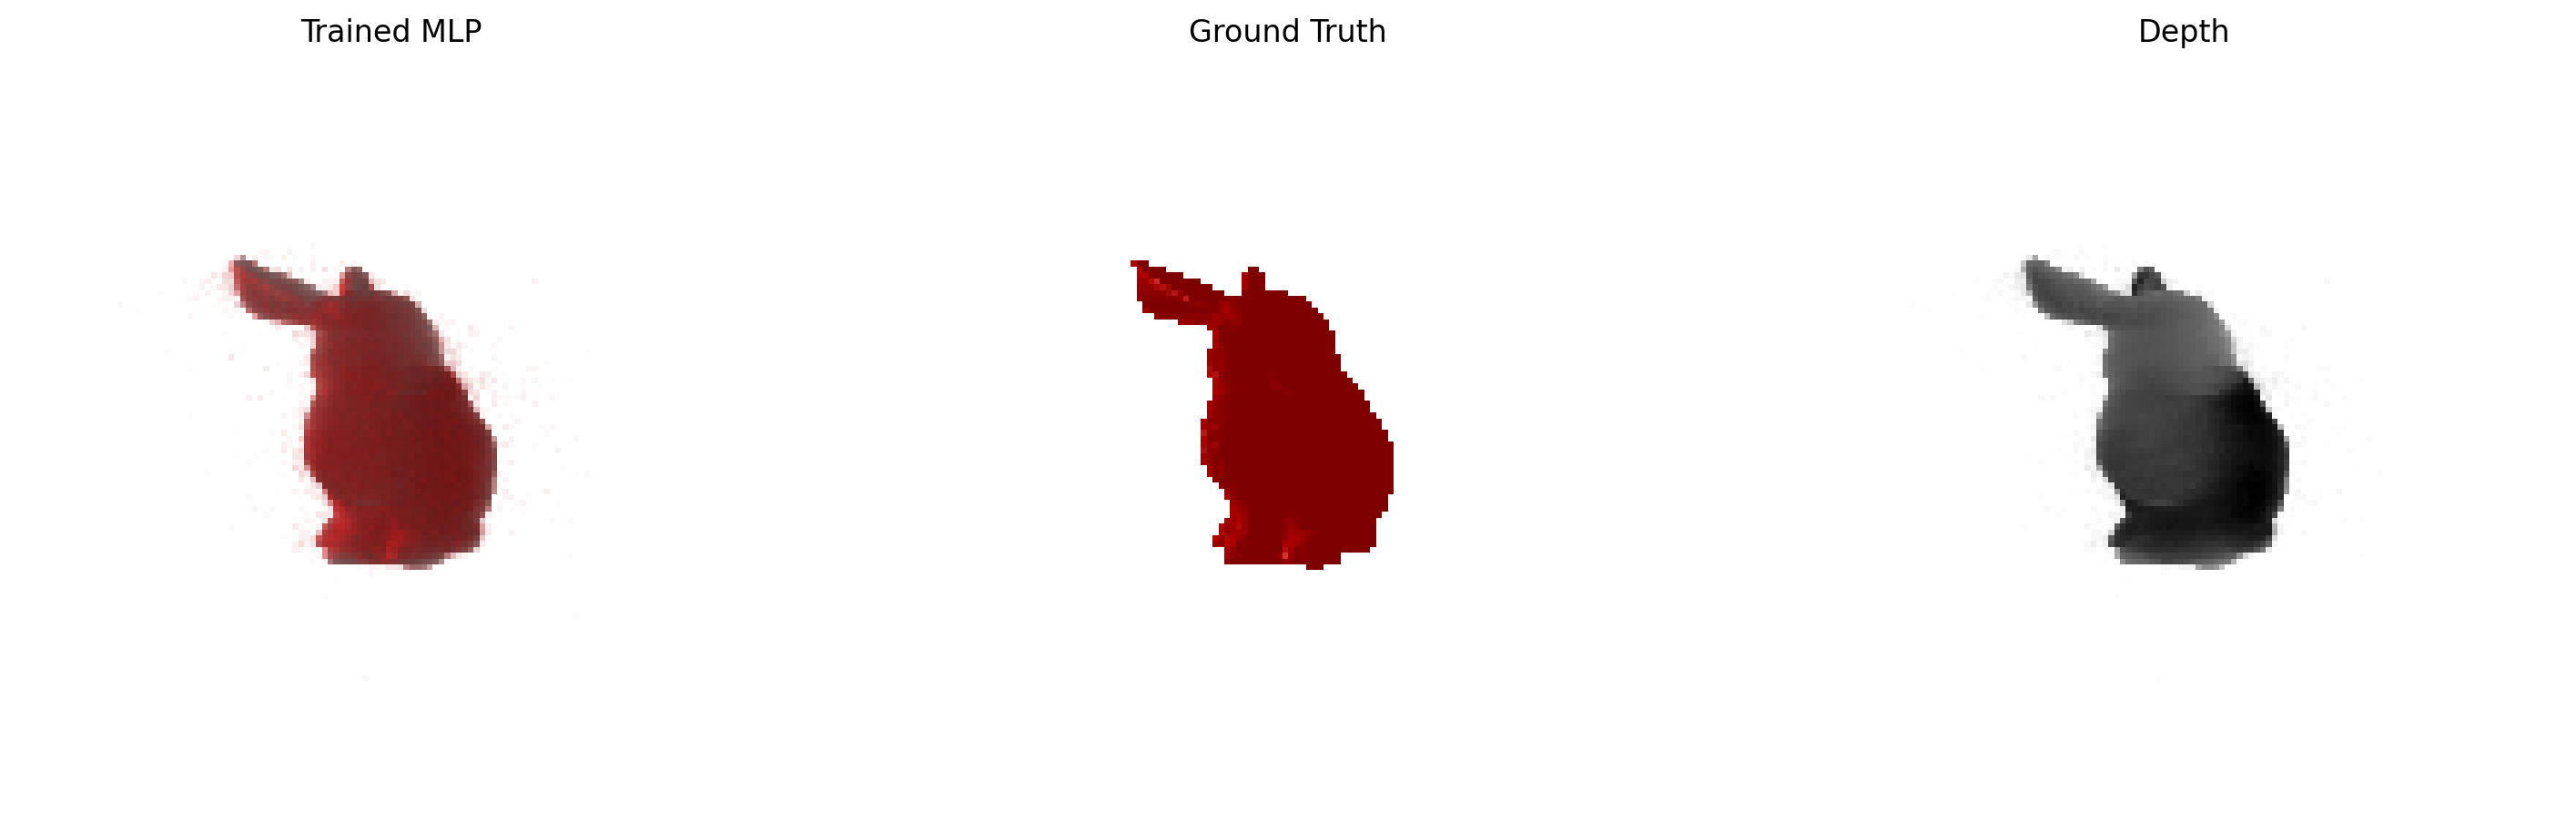

Step 1500: loss = 0.00
torch.Size([1, 16384, 3])


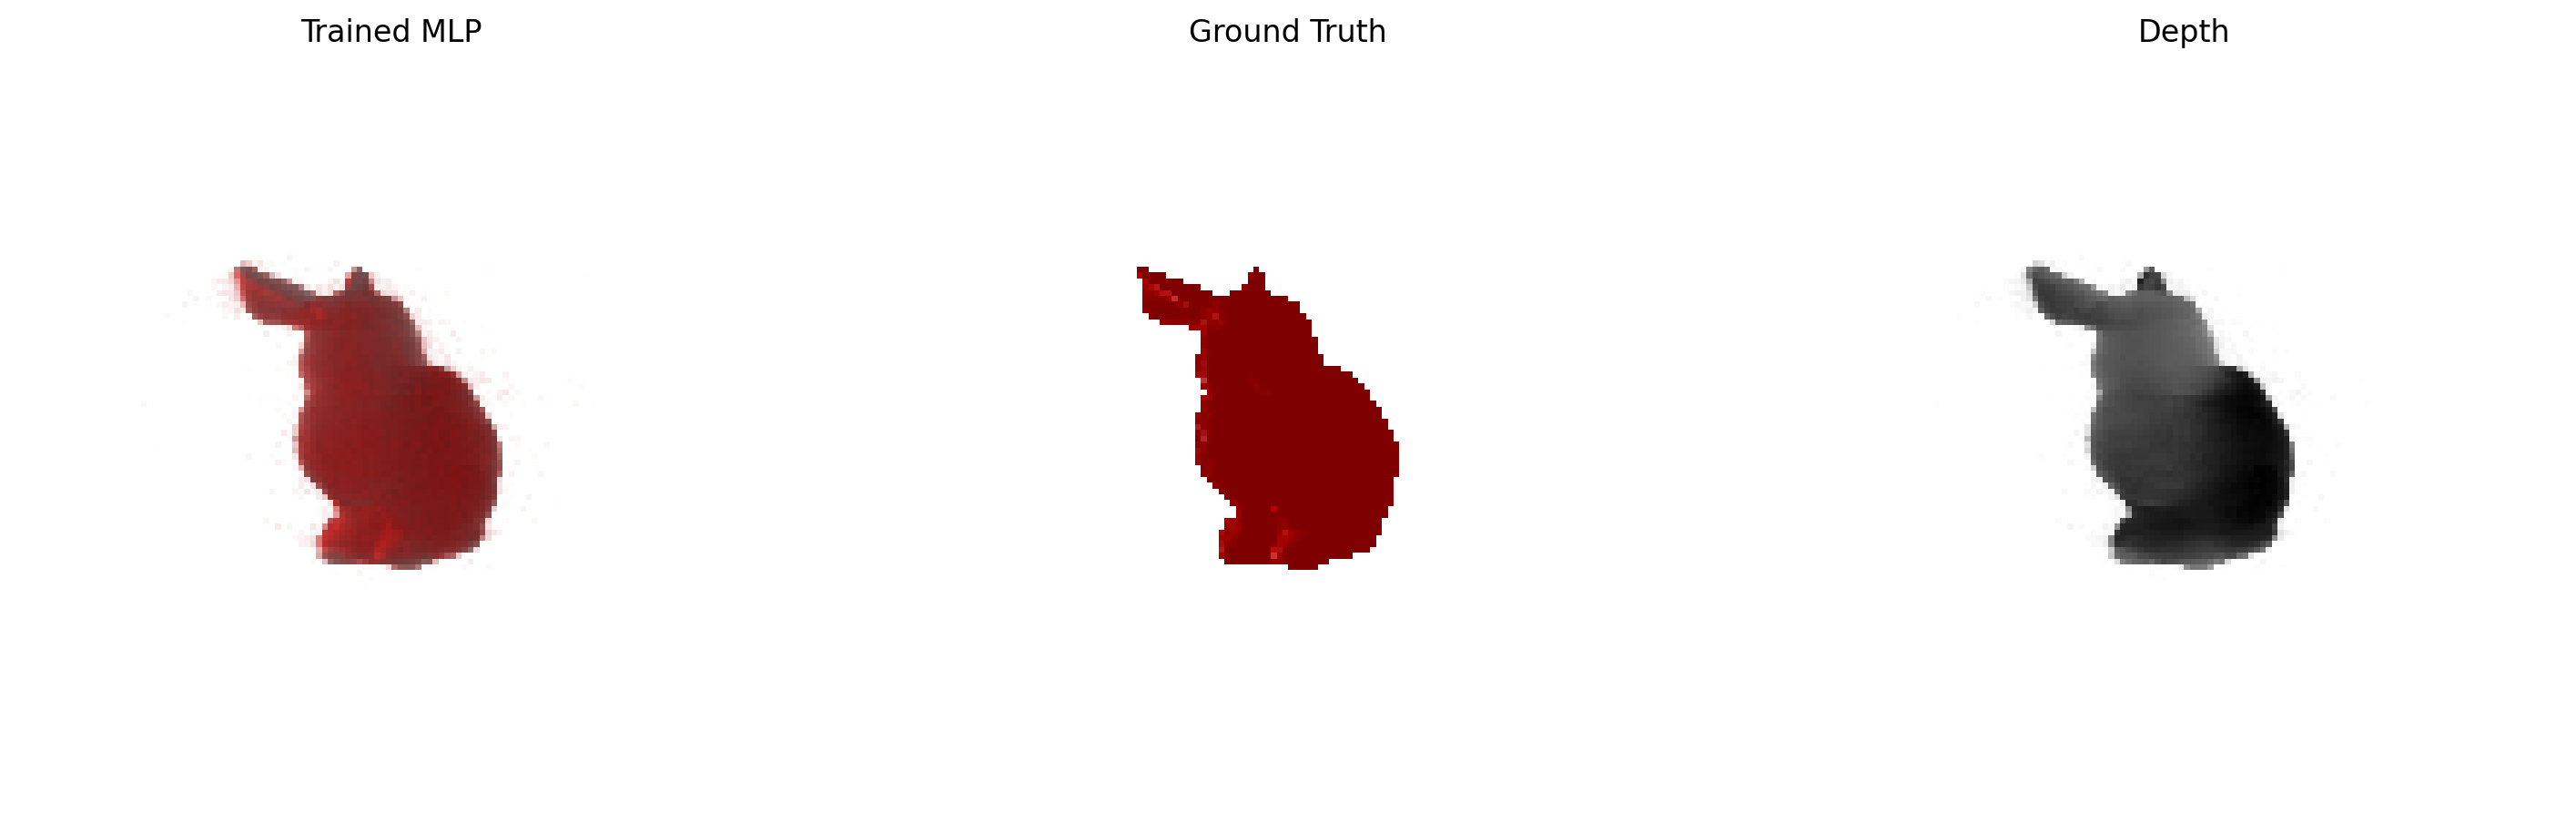

Step 1600: loss = 0.00
torch.Size([1, 16384, 3])


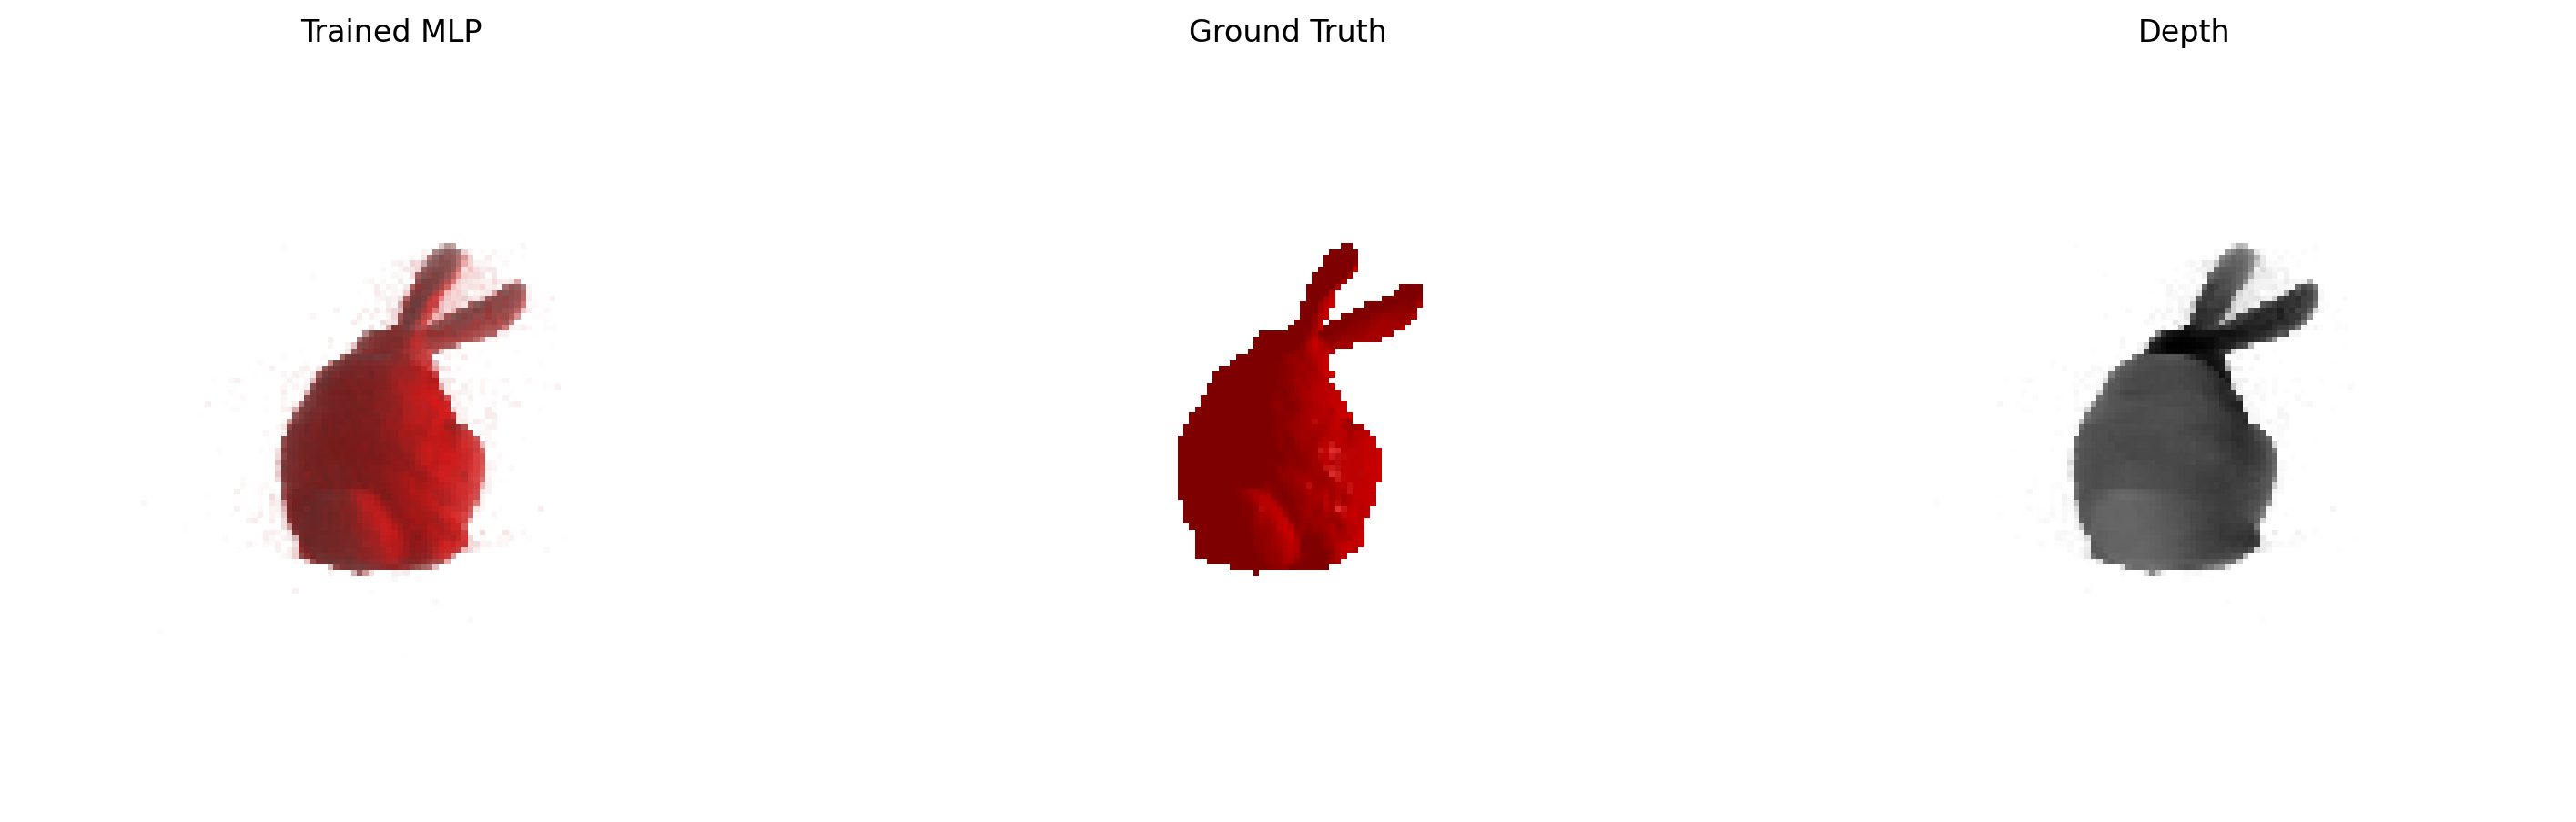

Step 1700: loss = 0.00
torch.Size([1, 16384, 3])


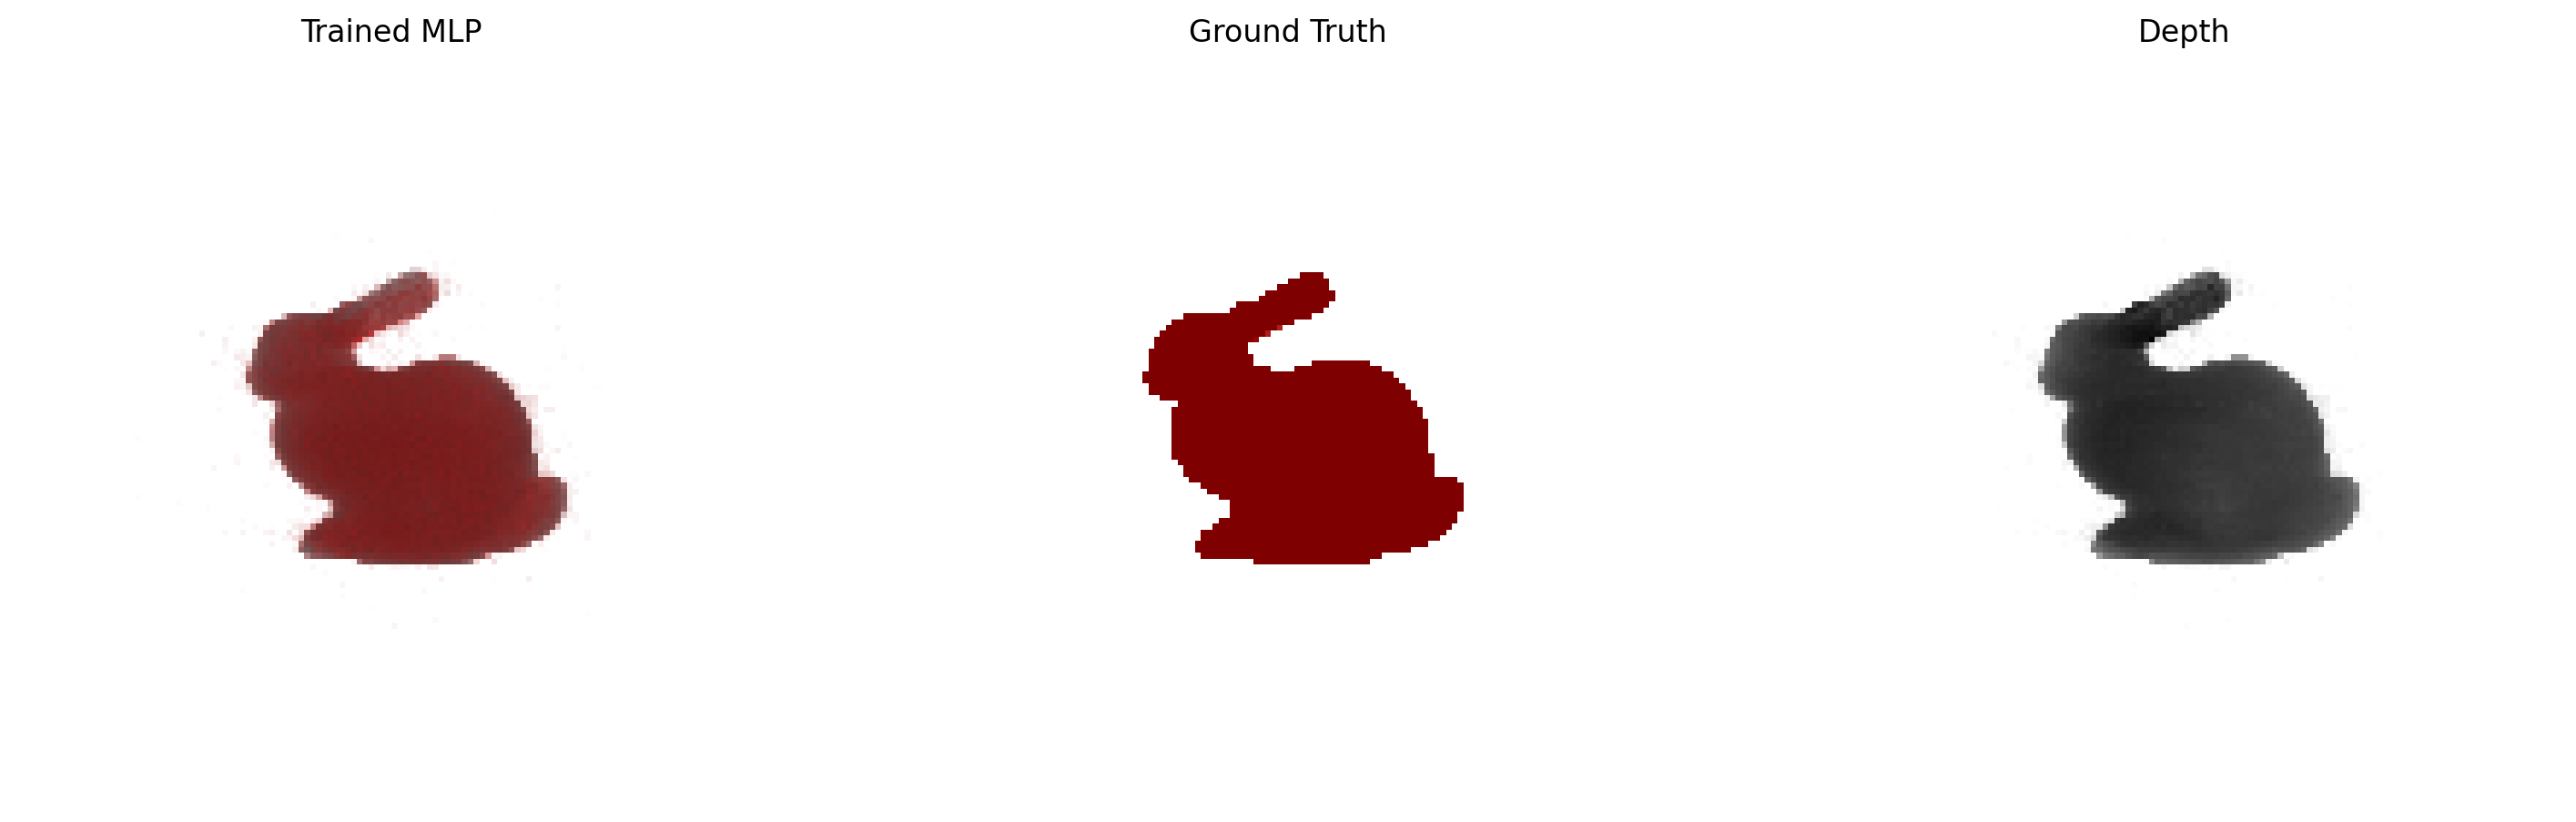

Step 1800: loss = 0.00
torch.Size([1, 16384, 3])


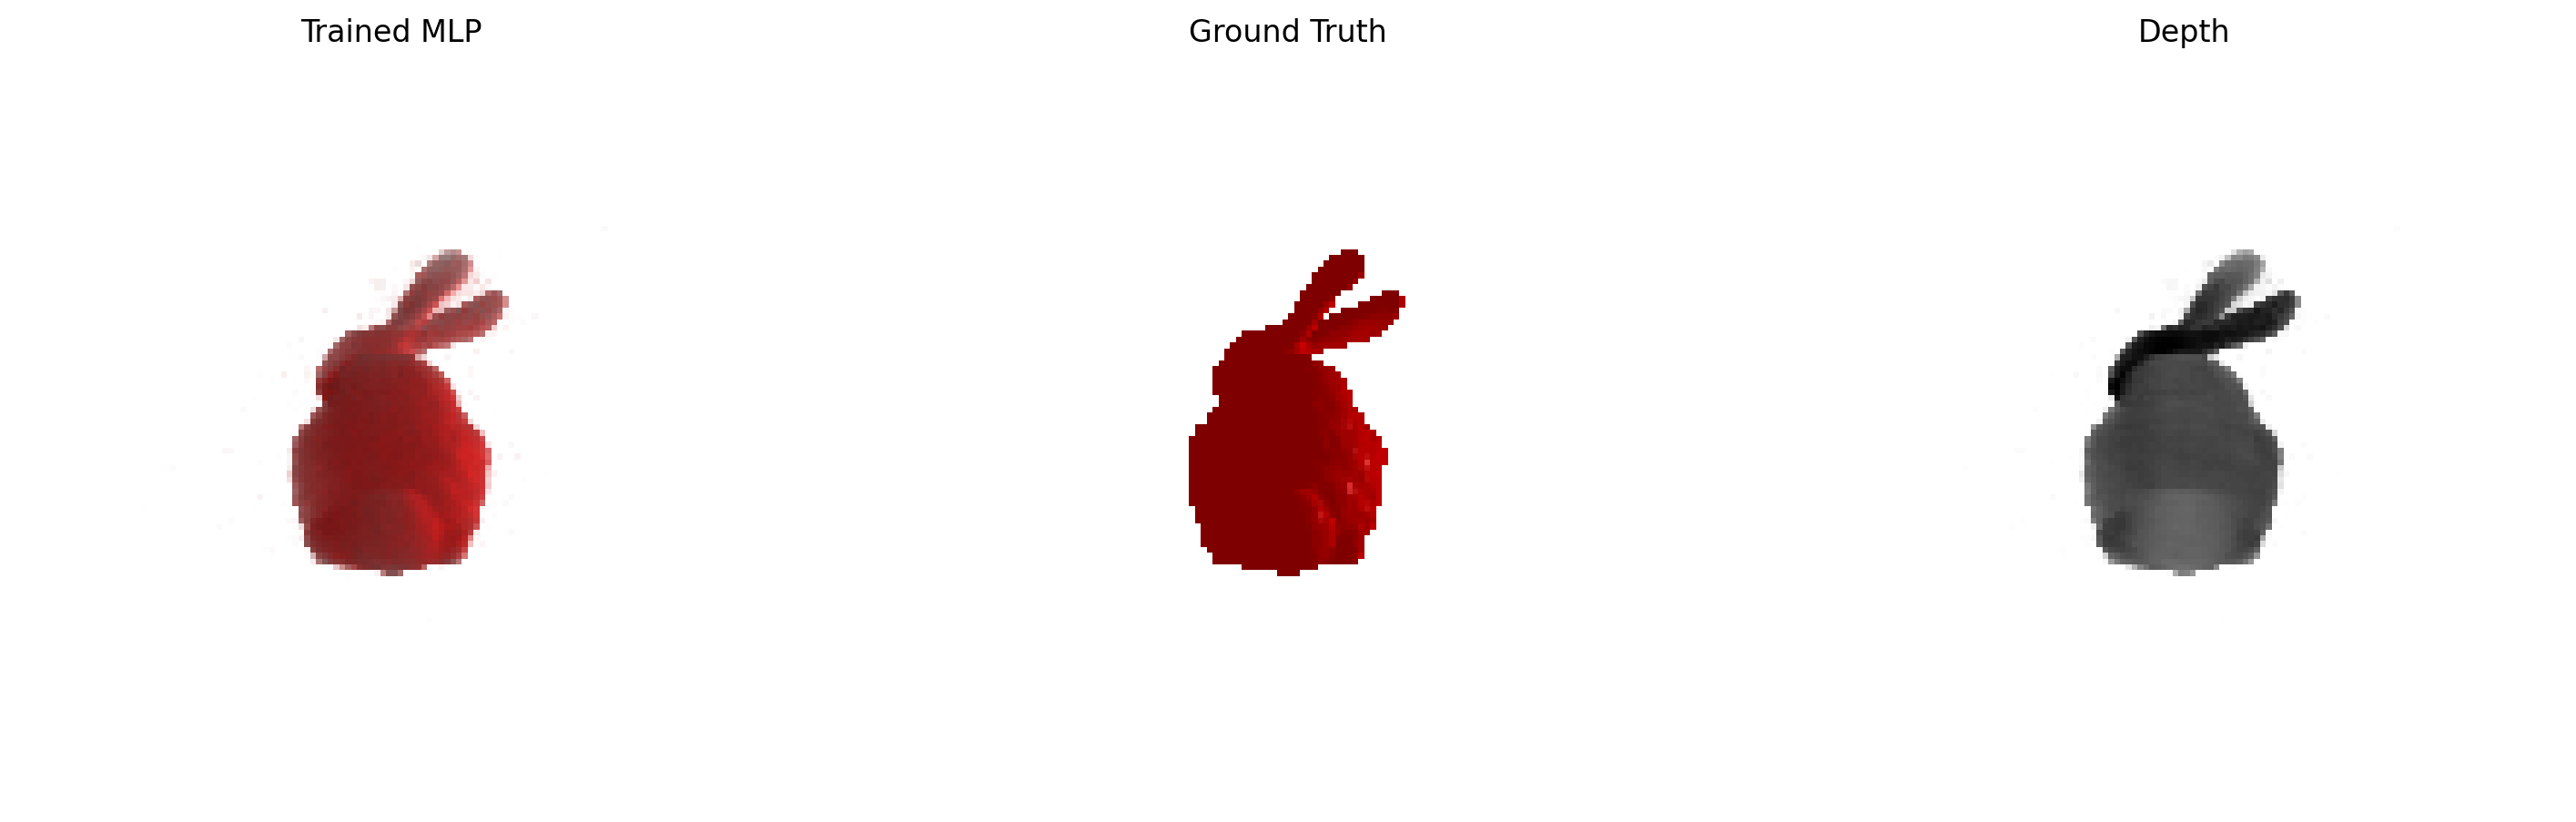

Step 1900: loss = 0.00
torch.Size([1, 16384, 3])


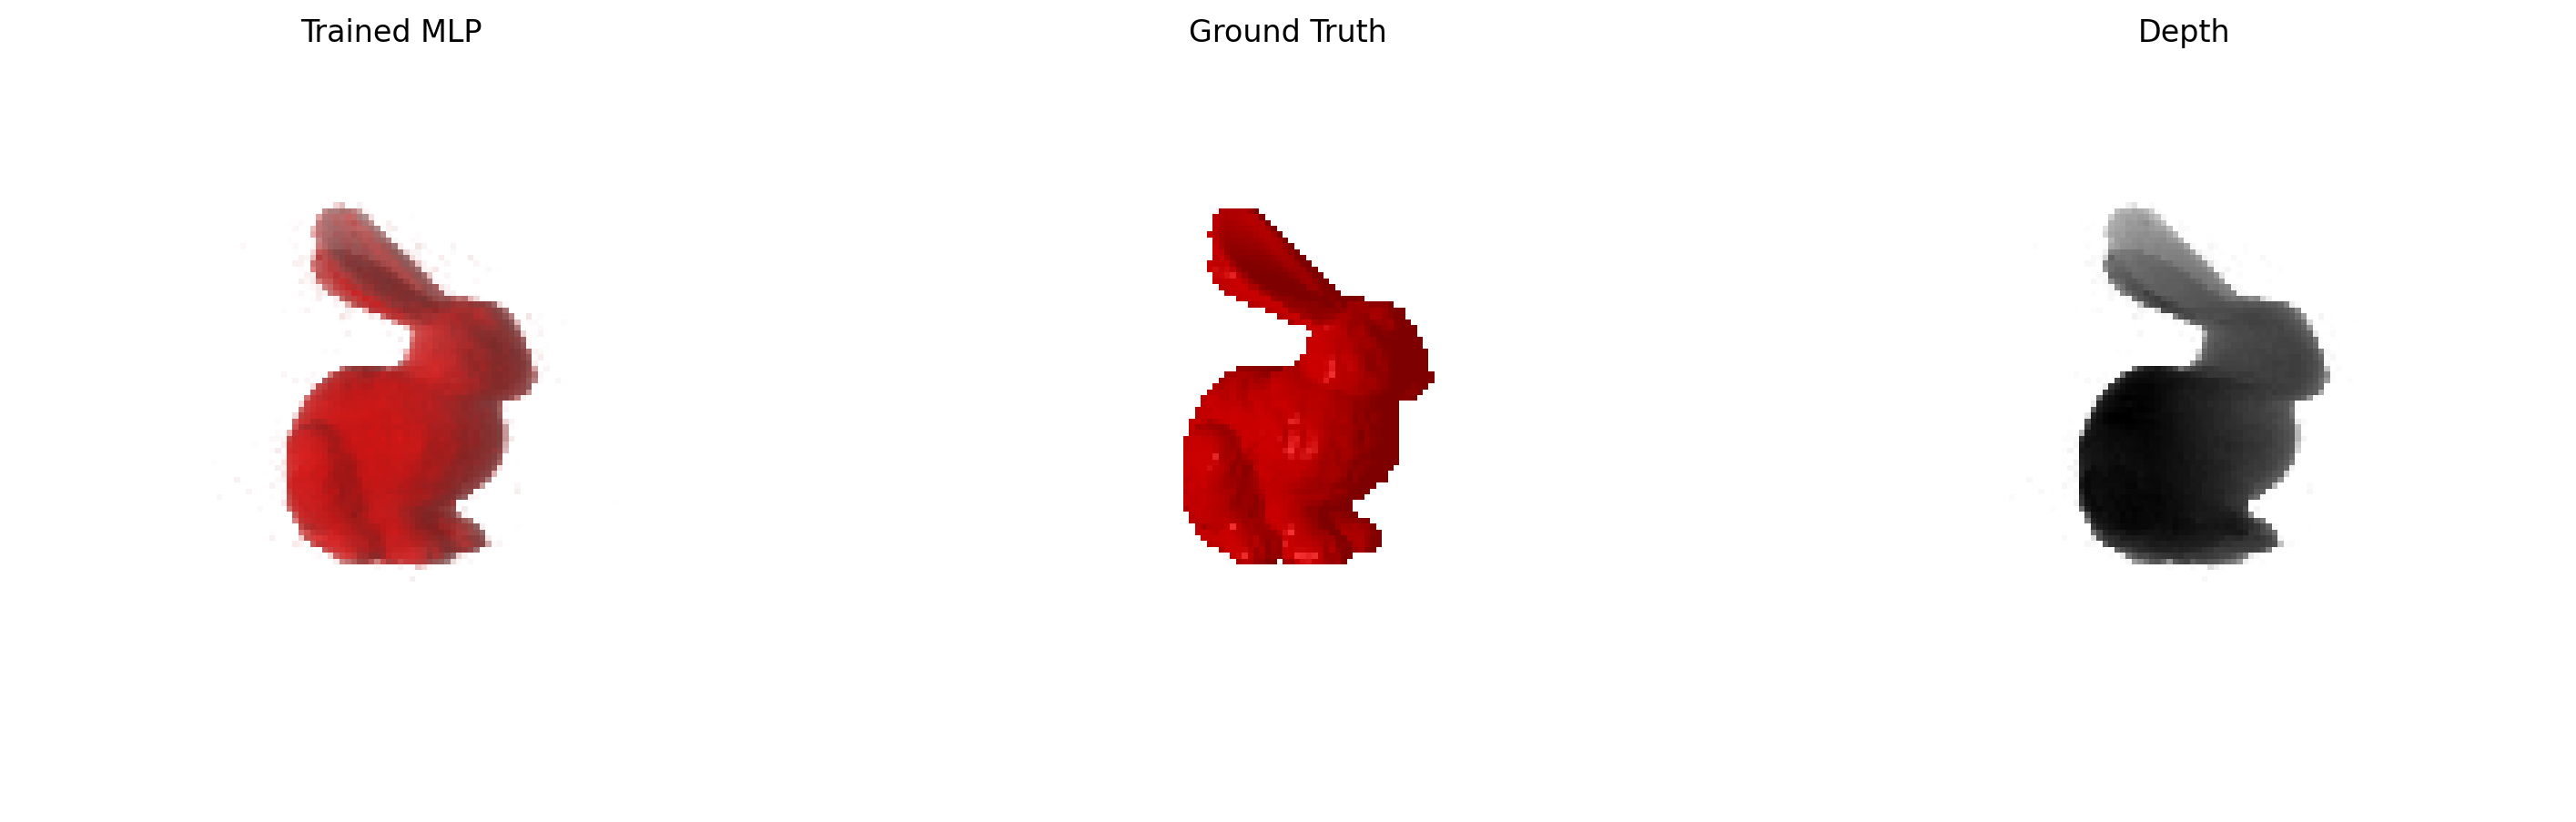

Step 2000: loss = 0.00
torch.Size([1, 16384, 3])


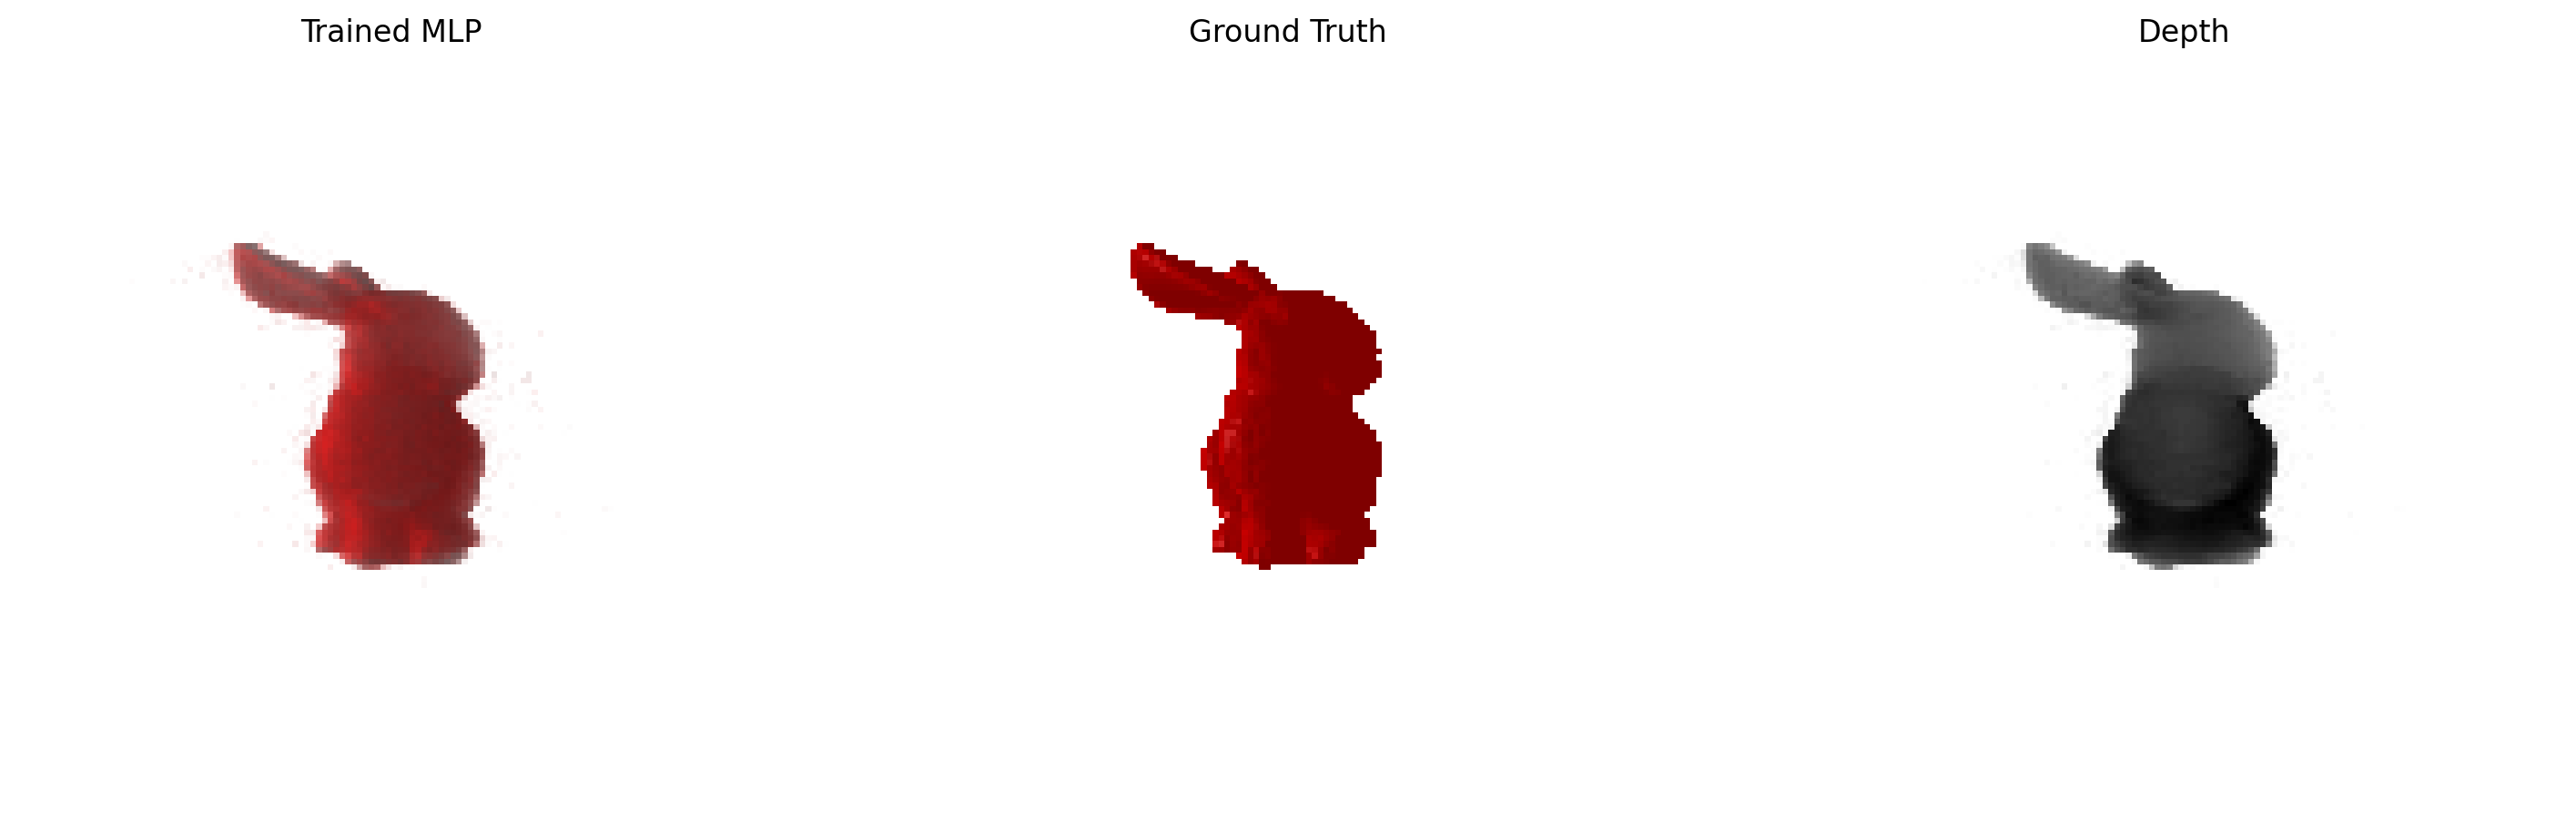

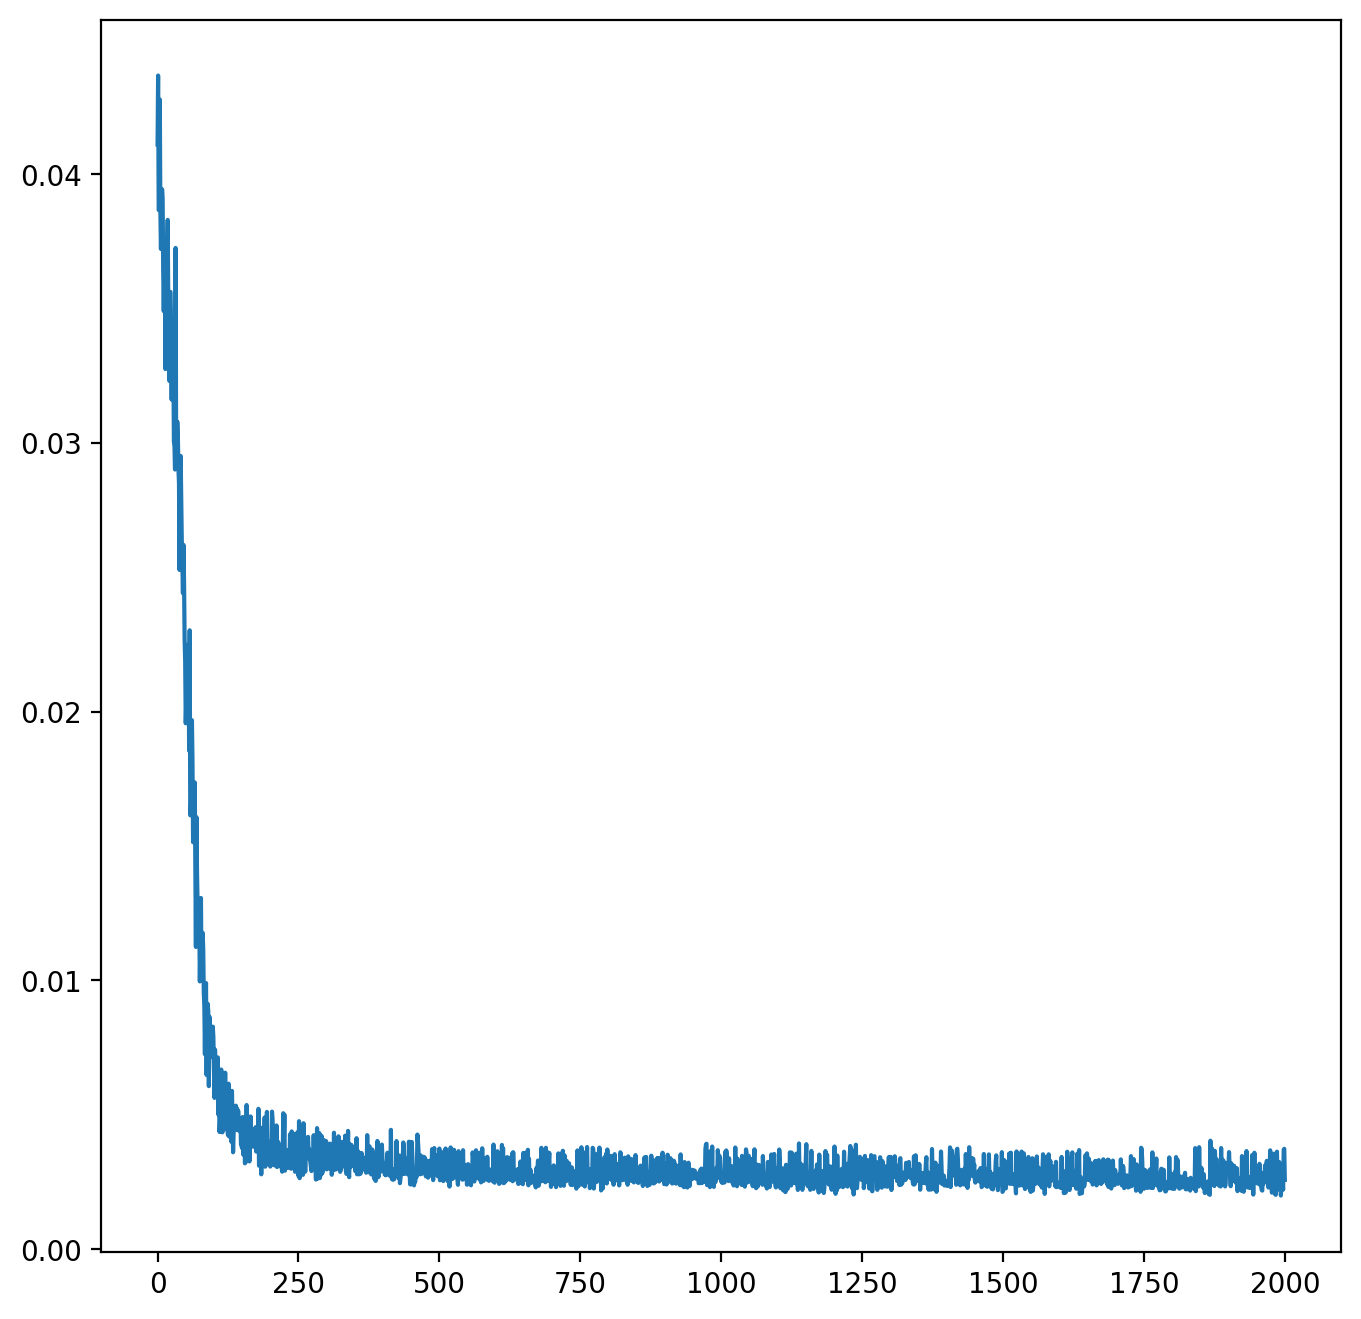

In [68]:

fit_inverse_graphics_representation(rf, renderer, bunny_dataset, (128, 128, 3), lr=1e-3, total_steps=2001)

### 3.1.6. Rendering a video

To properly inspect our result, we'll render out a video.

In [70]:
cam2world = np.load('cam2world.npy')
cam2world = torch.Tensor(cam2world).to(device)

images = images.cuda()
intrinsics = torch.tensor([[0.7, 0., 0.5],
                           [0., 0.7, 0.5],
                           [0., 0., 1.]]).to(device)

x_pix = get_opencv_pixel_coordinates(128, 128, device=device)
x_pix = x_pix.reshape(1, -1, 2)
with torch.no_grad():
    frames = []
    for i in range(len(cam2world)):
        model_in = {'cam2world': cam2world[i:i+1], 'intrinsics': intrinsics[None, ...], 'x_pix': x_pix}
        rgb, depth = renderer(model_in, rf)

        rgb = rgb.reshape(128, 128, 3).cpu().numpy()
        rgb *= 255
        rgb = np.clip(rgb, 0, 255).astype(np.uint8)
        frames.append(rgb)

In [ ]:
x_pix.shape

In [71]:
print(frames[0].shape)

f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

(128, 128, 3)


In [72]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# The End
This concludes Assignment 1. In summary, you have learned:


1.   Refresher on MLPs
2.   ReLU neural fields
3.   SIREN neural fields
4.   Neural field representations of images
5.   Fitting field representations
6.   Occupancy functions
7.   Hybrid continuous-discrete field parameterization
8.   Differentiable volume rendering
9.   Inverse graphics via differentiable volume rendering.

# Submission Instructions

1.   Click "Runtime -> Run all" and make sure all cells run without an error (you can tell by whether the *final* cell was executed. You can then be confident that you have implemented everything you were supposed to implement, or at least deleted the "raise NotImplementedError".
2.   Once you're certain, click "File -> Download -> Download .ipynb" and "File -> Download -> Download .py"
3.   Log in to Canvas
4.   Upload the `.py` and `.ipynb` file in a `.zip` archive with the filename being your Kerberos ID (e.g. `prafull.zip`).
5.   Done! Your homework will be auto-graded.